In [12]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import pickle
import numpy as np
import scipy as sci
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import matplotlib as mpl
from astropy import units 
import ChiantiPy.core as ch
from astropy.io import ascii
import matplotlib.pyplot as plt
from lightkurve import LightCurve
from astropy.table import Table
from astropy.table import Column
import astropy.constants as const
from dynesty import utils as dyfunc
from dynesty.plotting import _quantile
from scipy.interpolate import interp1d
from dynesty import DynamicNestedSampler
from matplotlib.gridspec import GridSpec

from lmfit.models import Model
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import (line_flux, equivalent_width,
                                gaussian_fwhm)
from astropy.nddata import StdDevUncertainty, NDUncertainty

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

distance = (9.72*units.pc).to(units.cm)
distanceErr = (0.004625*units.pc).to(units.cm)
radius   = (0.75*units.Rsun).to(units.cm)
radiusErr= (0.03*units.Rsun).to(units.cm)

surface_scaling = ((distance/radius)**2).value

parula = np.load('/Users/belugawhale/parula_colors.npy', allow_pickle=True)

sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from dem_modeling import ChiantiSetup, DEMModeling, setup_linelist
from utils import *
from cos_flares import FlaresWithCOS

outpath = '/Users/belugawhale/Documents/AUMic/final_dem_fits'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

_, flare_orbits, flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

In [14]:
line_table = Table.read('/Users/belugawhale/Documents/AUMic/aumic_linelist.csv',
                        format='csv', comment='#')
logT_range=[4,8]

In [15]:
fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
line_table = Table.read('/Users/belugawhale/Documents/AUMic/aumic_linelist.csv', format='csv')

In [16]:
mq = np.nansum(flare_mask,axis=0)==0
mean_quiescent = np.nanmean(fwc.flux[mq],axis=0)
mean_quiexcent_err = np.sqrt(np.nansum(fwc.flux_err[mq]**2, axis=0))/len(fwc.flux_err[mq])

mf = flare_mask[1]>0
mean_flare = np.nanmean(fwc.flux[mf],axis=0)
mean_flare_err = np.sqrt(np.nansum(fwc.flux_err[mf]**2, axis=0))/len(fwc.flux_err[mf])

# Creating dictionary for Hannah's code

In [26]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from dem_modeling import ChiantiSetup, DEMModeling, setup_linelist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
aumic_linelist_q = setup_linelist(fwc.wavelength[0], # wavelength array
                                    mean_quiescent,    # spectrum
                                    mean_quiexcent_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr) # stellar radius & error
print('----')
aumic_linelist_f = setup_linelist(fwc.wavelength[0], # wavelength array
                                    mean_flare,    # spectrum
                                    mean_flare_err,# spectrum error
                                    line_table,        # table of ions
                                    distance, distanceErr, # distance & error
                                    radius, radiusErr) # stellar radius & error

----


In [8]:
cs_q = ChiantiSetup(linelist=aumic_linelist_f,
                    logT_range=logT_range,
                    wave_range=[1,3200], setup=False,
                    abundance='sun_coronal_2012_schmelz_ext')

for k in list(aumic_linelist_q.keys()):
    chiname = cs_q.create_chiname(k)
    aumic_linelist_q[k]['CHIname'] = chiname
    aumic_linelist_f[k]['CHIname'] = chiname

In [21]:
gtab = Table.read(os.path.join(outpath,'gd/au_mic_q_linetable.ascii'), format='ascii')
gtab_ions = np.zeros(len(gtab), dtype='U32')
for i in range(len(gtab)):
    spec = gtab['Ion'][i].split(' ')
    gtab_ions[i] = ''.join(str(e) for e in spec)

In [23]:
def popem(dic, keys):
    for key in keys:
        dic.pop(key)
    return dic

In [29]:
pickle.dump(aumic_linelist_q, open(os.path.join(outpath,'hdl_full/aumic_linelist_q.pkl'),'wb'))
pickle.dump(aumic_linelist_f, open(os.path.join(outpath,'hdl_full/aumic_linelist_f.pkl'),'wb'))

In [29]:
rmv = []
for key in (aumic_linelist_q.keys()):
    if key not in gtab_ions:
        rmv.append(key)

In [30]:
aumic_linelist_q_short = popem(aumic_linelist_q, rmv)
aumic_linelist_f_short = popem(aumic_linelist_f, rmv)

In [34]:
pickle.dump(aumic_linelist_q_short, 
            open(os.path.join(outpath,'hdl_short/aumic_linelist_q.pkl'),'wb'))
pickle.dump(aumic_linelist_f_short, 
            open(os.path.join(outpath,'hdl_short/aumic_linelist_f.pkl'),'wb'))

In [184]:
q = mean_quiescent>0
np.save(os.path.join(outpath,'gd/spectrum_data_q.npy'),
       [fwc.wavelength[0][q], 
        np.append(fwc.wavelength[0][q][0], np.diff(fwc.wavelength[0][q])),
        mean_quiescent[q],
        mean_quiexcent_err[q]])

q = mean_flare>0
np.save(os.path.join(outpath,'gd/spectrum_data_f.npy'),
       [fwc.wavelength[0][q], 
        np.append(fwc.wavelength[0][q][0], np.diff(fwc.wavelength[0][q])),
        mean_flare[q],
        mean_flare_err[q]])

# Setting up Chianti Lists

In [47]:
def setup_gt(linelist, outpath, extension):
    global logT_range
    
    cs = ChiantiSetup(linelist=linelist,
                        logT_range=logT_range,
                        wave_range=[1,3200], setup=True,
                        abundance='sun_coronal_2012_schmelz_ext')

    cs.emissivity_functions()
    cs.get_all_ions(top=30)

    gt_filename = os.path.join(outpath, 'aumic_{0}_G_T.pkl'.format(extension))
    pickle.dump(cs.G_T, open(gt_filename,'wb'))
    
    updated = os.path.join(outpath, 'aumic_{0}_linelist_updated_ext.pkl'.format(extension))
    pickle.dump(cs.linelist, open(updated, 'wb'))
    
    return cs

In [91]:
subdir = 'hdl_full'

In [92]:
qlist = pd.read_pickle(os.path.join(outpath, os.path.join(subdir,r'aumic_linelist_q.pkl')))
flist = pd.read_pickle(os.path.join(outpath, os.path.join(subdir,r'aumic_linelist_f.pkl')))

In [78]:
cs_q = setup_gt(qlist,
                outpath=os.path.join(outpath, subdir),
                extension='q')
cs_f = setup_gt(flist,
                outpath=os.path.join(outpath, subdir),
                extension='f')

Setting up Chianti spectrum. This may take a few minutes . . .
 elapsed seconds =      582.000


  0%|                                                                                                                   | 0/255 [00:00<?, ?it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_10     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    39.9440     9.60e-29     2.10e+11 N
al_10     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    42.4600     4.89e-29     2.91e+11 N
al_10     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    45.0720     1.06e-28     2.36e+11 N
al_10     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    45.9480     7.55e-29     5.25e+10 N
al_10     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    51.9320     1.10e-28     1.29e+10 N
al_10     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    51.9790     7.52e-28     4.50e+11 Y
al_10     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0  

  0%|▍                                                                                                          | 1/255 [00:04<19:39,  4.64s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_11     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   33.0066     1.05e-30     7.41e+10 Y
al_11     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   33.0066     2.11e-30     7.41e+10 Y
al_11     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   34.9948     1.28e-30     1.24e+11 N
al_11     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   35.0642     2.30e-30     1.48e+11 N
al_11     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   35.1657     4.37e-31     9.88e+09 Y
al_11     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   35.2374     8.65e-31     1.96e+10 Y
al_11     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

  1%|▊                                                                                                          | 2/255 [00:09<20:03,  4.76s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_12     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     6.1755     7.51e-39     1.70e+12 Y
al_12     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     6.3139     2.51e-38     3.30e+12 Y
al_12     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     6.6348     1.83e-37     7.88e+12 Y
al_12     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     6.6447     3.36e-39     2.00e+10 Y
al_12     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     7.7573     1.64e-35     2.79e+13 Y
al_12     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                     7.8070     5.56e-36     6.71e+10 Y
al_12     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

  1%|█▎                                                                                                         | 3/255 [00:11<13:58,  3.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_13     1    19                  1s 2S0.5 - 5p 2P1.5                        5.6048     9.59e-50     9.87e+11 Y
al_13     1    18                  1s 2S0.5 - 5p 2P0.5                        5.6050     4.82e-50     9.86e+11 Y
al_13     1    12                  1s 2S0.5 - 4p 2P1.5                        5.7391     3.51e-49     1.96e+12 Y
al_13     1    11                  1s 2S0.5 - 4p 2P0.5                        5.7396     1.75e-49     1.96e+12 Y
al_13     1     7                  1s 2S0.5 - 3p 2P1.5                        6.0525     3.20e-48     4.80e+12 Y
al_13     1     6                  1s 2S0.5 - 3p 2P0.5                        6.0537     1.61e-48     4.80e+12 Y
al_13     1     4                  1s 2S0.5 - 2p 2P1.5     

  2%|██                                                                                                         | 5/255 [00:11<06:48,  1.64s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_3     3    46                  3p 2P1.5 - 2p5 3s 3p 2P1.5               169.8010     2.39e-38     6.60e+09 Y
 al_3     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5               170.2450     3.77e-38     1.17e+10 Y
 al_3     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5               172.6220     2.95e-38     2.20e+08 Y
 al_3     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5               172.8500     8.23e-38     2.57e+01 Y
 al_3     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5               175.0260     8.25e-38     1.84e+07 Y
 al_3     1    24                  3s 2S0.5 - 6p 2P1.5                      511.1380     4.90e-38     3.93e+07 Y
 al_3     1    23                  3s 2S0.5 - 6p 2P0.5     

  2%|██▌                                                                                                        | 6/255 [00:15<08:44,  2.10s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_4     1   173             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                93.6310     1.52e-34     1.97e+10 N
 al_4     1   167             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0              106.9900     9.74e-34     1.77e+10 Y
 al_4     1   162             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0              107.3700     9.41e-34     1.76e+10 Y
 al_4     1   141             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0              108.5260     1.22e-33     1.83e+10 Y
 al_4     1   137             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0              108.9130     8.98e-34     1.38e+10 Y
 al_4     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0              111.1960     2.72e-33     3.53e+10 Y
 al_4     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

  3%|██▉                                                                                                        | 7/255 [00:23<15:45,  3.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_5     1   128             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5               90.6310     1.94e-31     7.92e+10 Y
 al_5     1   132             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5               90.6460     2.22e-31     5.10e+10 Y
 al_5     1   100             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5               93.7550     6.15e-31     1.39e+11 Y
 al_5     1    95             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5               93.8560     2.11e-31     8.26e+10 Y
 al_5     1    65             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5               99.2900     2.31e-31     2.80e+10 Y
 al_5     1    57             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              103.8030     5.05e-31     6.64e+10 Y
 al_5     1    55             2s2 2p5 2P1.5 - 2s2 2p4 3d 2F

  3%|███▎                                                                                                       | 8/255 [00:29<18:59,  4.61s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_6     1     9                 2p4 3P2.0 - 2s.2p5 1P1.0                  221.5410     2.41e-32     6.81e+07 Y
 al_6     2     9                 2p4 3P1.0 - 2s.2p5 1P1.0                  222.8910     5.38e-34     1.53e+06 Y
 al_6     3     9                 2p4 3P0.0 - 2s.2p5 1P1.0                  223.4360     1.12e-33     3.20e+06 Y
 al_6     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                     232.4730     8.80e-35     1.68e+07 Y
 al_6     4     9                 2p4 1D2.0 - 2s.2p5 1P1.0                  243.7620     1.32e-29     4.10e+10 Y
 al_6     5     9                 2p4 1S0.0 - 2s.2p5 1P1.0                  275.3480     7.11e-31     2.50e+09 Y
 al_6     1     7                 2p4 3P2.0 - 2s.2p5 3P1.0 

  4%|████▏                                                                                                     | 10/255 [00:29<10:22,  2.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_8     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                67.2880     1.40e-27     4.48e+11 Y
 al_8     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                67.3600     1.47e-27     4.95e+11 Y
 al_8     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                67.4070     2.98e-27     6.42e+11 Y
 al_8     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                67.4370     6.35e-28     2.14e+11 Y
 al_8     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                67.4640     3.03e-27     7.22e+11 Y
 al_8     6    37              2s 2p3 5S2.0 - 2s 2p2 3s 5P3.0                74.8420     5.47e-28     5.87e+10 Y
 al_8     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2

  4%|████▌                                                                                                     | 11/255 [01:06<44:15, 10.88s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_9     1   114              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   47.7550     3.70e-28     1.40e+11 Y
 al_9     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 56.8990     5.12e-28     2.19e+11 Y
 al_9     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 56.9450     2.96e-28     2.69e+11 Y
 al_9     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   60.8960     4.43e-27     5.49e+11 Y
 al_9     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   61.0690     3.01e-27     6.55e+11 Y
 al_9     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   61.0780     8.76e-28     1.09e+11 Y
 al_9     7    55              2s 2p2 2D2.5 - 2s 2p 3d 2F3.

  5%|████▉                                                                                                     | 12/255 [01:13<40:20,  9.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_10     1   142             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           31.4910     5.36e-29     8.69e+11 Y
ar_10     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           36.5530     7.36e-29     4.26e+11 Y
ar_10     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           37.4310     3.40e-28     2.13e+12 Y
ar_10     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           37.4912     2.49e-28     2.56e+12 Y
ar_10     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           37.5747     9.43e-29     1.88e+12 Y
ar_10     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           37.5980     3.24e-29     5.96e+10 Y
ar_10     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

  5%|█████▍                                                                                                    | 13/255 [01:14<30:03,  7.45s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_11     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           33.6790     1.08e-29     8.42e+11 Y
ar_11     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 1D2.0           33.8883     1.80e-30     1.57e+12 Y
ar_11     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           34.0910     5.89e-30     2.03e+12 Y
ar_11     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           34.2241     1.60e-29     2.25e+12 Y
ar_11     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0           34.3300     2.12e-29     2.18e+12 Y
ar_11     4    74             2s2.2p4 1D2.0 - 2s2.2p3(2P).3d 3F3.0           34.8000     2.43e-30     6.71e+11 Y
ar_11     1    54             2s2.2p4 3P2.0 - 2s2.2p3(4S).3

  5%|█████▊                                                                                                    | 14/255 [01:14<21:54,  5.46s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_12     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           31.3026     2.06e-31     3.86e+12 N
ar_12     1    55             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           31.3470     3.98e-31     3.69e+12 Y
ar_12     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           31.3883     5.51e-31     3.39e+12 Y
ar_12     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4D2.5           31.5827     7.78e-32     3.67e+11 N
ar_12     3    56             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5           32.3443     2.38e-32     5.36e+11 Y
ar_12     2    52             2s2.2p3 2D1.5 - 2s2.2p2(3P).3d 2F2.5           32.4593     2.64e-32     4.72e+11 Y
ar_12     3    51             2s2.2p3 2D2.5 - 2s2.2p2(3P).3

  6%|██████▏                                                                                                   | 15/255 [01:14<15:52,  3.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_13     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                29.1840     4.27e-34     3.17e+12 N
ar_13     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                29.3190     4.81e-33     3.09e+12 Y
ar_13     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                29.4040     1.30e-33     8.35e+11 Y
ar_13     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                31.8640     6.18e-34     2.84e+11 Y
ar_13     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                31.9140     5.54e-34     1.70e+11 N
ar_13     8    47              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                33.0430     1.23e-33     3.00e+11 N
ar_13    11    47              2s 2p3 3P1.0 - 2s 2p2 3s 3P0

  6%|██████▌                                                                                                 | 16/255 [02:09<1:14:11, 18.63s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_14     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 25.7374     4.57e-37     1.15e+12 Y
ar_14     4    43              2s 2p2 4P1.5 - 2s 2p 3d 4D2.5                 27.3926     2.87e-37     3.39e+12 N
ar_14     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   27.4690     4.89e-36     2.85e+12 Y
ar_14     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   27.6310     1.44e-36     3.37e+12 Y
ar_14     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   27.6410     9.59e-37     5.62e+11 Y
ar_14     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 28.3009     7.50e-37     2.95e+12 N
ar_14     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5 

  7%|██████▉                                                                                                 | 17/255 [02:16<1:00:39, 15.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_15     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    18.8010     3.14e-41     9.86e+11 N
ar_15     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    20.4030     3.15e-41     1.12e+12 Y
ar_15     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    24.7000     2.64e-40     6.41e+11 N
ar_15     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    24.7370     4.67e-40     1.64e+12 Y
ar_15     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    25.7900     1.44e-40     3.28e+12 Y
ar_15     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    25.7900     7.88e-41     2.45e+12 Y
ar_15     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0  

  7%|███████▍                                                                                                  | 18/255 [02:21<48:09, 12.19s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_16     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   15.9326     2.66e-46     3.31e+11 Y
ar_16     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   15.9367     1.33e-46     3.31e+11 Y
ar_16     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   16.5970     1.73e-46     5.49e+11 Y
ar_16     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   16.6666     3.12e-46     6.50e+11 Y
ar_16     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   16.7310     1.18e-46     7.85e+10 Y
ar_16     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                   17.7371     1.82e-45     6.41e+11 Y
ar_16     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5 

  7%|███████▉                                                                                                  | 19/255 [02:25<38:37,  9.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_17     3   226               1s.2p 3P0.0 - 2s.5s 3S1.0                     2.9832     0.00e+00     9.08e+10 N
ar_17     4   226               1s.2p 3P1.0 - 2s.5s 3S1.0                     2.9837     0.00e+00     2.53e+11 N
ar_17     6   226               1s.2p 3P2.0 - 2s.5s 3S1.0                     2.9857     0.00e+00     1.04e+11 N
ar_17     7   226               1s.2p 1P1.0 - 2s.5s 3S1.0                     2.9953     0.00e+00     1.74e+10 N
ar_17     7   225               1s.2p 1P1.0 - 2p.4f 3G5.0                     3.0499     0.00e+00     5.20e+12 N
ar_17     9   226               1s.3p 3P0.0 - 2s.5s 3S1.0                     3.4445     0.00e+00     2.26e+09 N
ar_17    10   226               1s.3p 3P1.0 - 2s.5s 3S1.0  

  8%|████████▎                                                                                                 | 20/255 [02:27<28:53,  7.38s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_18     1    14                  1s 2S0.5 - 4d 2D2.5                        2.9872     0.00e+00     1.10e+10 Y
ar_18     1    13                  1s 2S0.5 - 4p 2P1.5                        2.9873     0.00e+00     7.16e+12 Y
ar_18     1    12                  1s 2S0.5 - 4d 2D1.5                        2.9873     0.00e+00     8.80e+07 Y
ar_18     3    14                  2p 2P0.5 - 4d 2D2.5                       14.8878     0.00e+00     1.86e+08 Y
ar_18     3    12                  2p 2P0.5 - 4d 2D1.5                       14.8913     0.00e+00     1.83e+12 Y
ar_18     3    13                  2p 2P0.5 - 4p 2P1.5                       14.8913     0.00e+00     1.83e+08 Y
ar_18     2    15                  2s 2S0.5 - 4f 2F2.5     

  9%|█████████▌                                                                                                | 23/255 [02:27<12:41,  3.28s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_5     2     5             3s2.3p2 3P1.0 - 3s2.3p2 1S0.0                2692.0240     1.83e-34     6.72e+00 Y
 ar_5     3     5             3s2.3p2 3P2.0 - 3s2.3p2 1S0.0                2786.8190     1.78e-36     6.76e-02 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_7     1    68                 3s2 1S0.0 - 3s 5p 1P1.0                   134.7990     1.15e-30     9.19e+09 Y
 ar_7     1    32                 3s2 1S0.0 - 3s 4p 1P1.0                   175.501

 10%|██████████▍                                                                                               | 25/255 [02:34<12:39,  3.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_8     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                51.1750     1.37e-29     2.69e+03 N
 ar_8     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                51.6160     1.20e-29     6.80e+08 N
 ar_8     1    15                  3s 2S0.5 - 5p 2P1.5                      120.0840     9.16e-30     5.90e+09 Y
 ar_8     1    14                  3s 2S0.5 - 5p 2P0.5                      120.1550     4.59e-30     6.01e+09 Y
 ar_8     3    26                  3p 2P1.5 - 6d 2D2.5                      123.0200     6.41e-30     7.11e+09 Y
 ar_8     3    22                  3p 2P1.5 - 6s 2S0.5                      128.0960     5.04e-30     4.52e+09 Y
 ar_8     2    16                  3p 2P0.5 - 5d 2D1.5     

 10%|██████████▊                                                                                               | 26/255 [02:37<12:59,  3.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_9     1   177             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               30.7455     4.14e-29     1.55e+11 N
 ar_9     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               30.9009     5.55e-29     2.16e+11 N
 ar_9     1   151             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               31.3958     7.05e-29     2.30e+11 N
 ar_9     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               31.5558     7.53e-29     2.45e+11 N
 ar_9     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               32.6671     1.70e-28     4.53e+11 Y
 ar_9     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               32.8470     1.13e-28     2.93e+11 Y
 ar_9     1    67             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P

 11%|███████████▏                                                                                              | 27/255 [02:45<16:46,  4.42s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_1     1    41                 2p2 3P0.0 - 2p 3d 3P1.0                  1260.7350     6.54e-42     5.17e+07 Y
  c_1     2    42                 2p2 3P1.0 - 2p 3d 3P0.0                  1260.9260     6.87e-42     1.63e+08 Y
  c_1     2    40                 2p2 3P1.0 - 2p 3d 3P2.0                  1261.1220     7.80e-42     3.63e+07 Y
  c_1     3    41                 2p2 3P2.0 - 2p 3d 3P1.0                  1261.4260     8.53e-42     6.74e+07 Y
  c_1     3    40                 2p2 3P2.0 - 2p 3d 3P2.0                  1261.5520     2.58e-41     1.20e+08 Y
  c_1     1    33                 2p2 3P0.0 - 2p 3d 3D1.0                  1277.2450     1.04e-41     1.21e+08 Y
  c_1     2    35                 2p2 3P1.0 - 2p 3d 3D2.0  

 11%|███████████▋                                                                                              | 28/255 [02:46<13:00,  3.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_2     2    44              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                530.3590     2.09e-36     4.14e+08 Y
  c_2     2    38              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                549.5110     1.95e-36     4.60e+08 Y
  c_2     1    25              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  594.8000     1.68e-36     8.83e+08 Y
  c_2     2    26              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  595.0220     3.20e-36     1.06e+09 Y
  c_2     1    15              2s2 2p 2P0.5 - 2s2 3d 2D1.5                  687.0530     7.41e-36     2.30e+09 Y
  c_2     2    16              2s2 2p 2P1.5 - 2s2 3d 2D2.5                  687.3450     1.75e-35     2.76e+09 Y
  c_2     2    15              2s2 2p 2P1.5 - 2s2 3d 2D1.5 

 11%|████████████                                                                                              | 29/255 [02:53<16:25,  4.36s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_3     1    61                 2s2 1S0.0 - 2s 5p 1P1.0                   291.3260     1.14e-32     1.28e+09 Y
  c_3     1    42                 2s2 1S0.0 - 2s 4p 1P1.0                   310.1700     6.81e-33     5.79e+08 Y
  c_3     1    25                 2s2 1S0.0 - 2p 3s 1P1.0                   322.5740     5.97e-33     1.00e+09 Y
  c_3     4    67               2s 2p 3P2.0 - 2s 5d 3D3.0                   341.2390     4.93e-33     1.78e+09 Y
  c_3     4    33               2s 2p 3P2.0 - 2s 4d 3D3.0                   371.7430     1.15e-32     4.39e+09 Y
  c_3     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                   386.2030     8.66e-32     3.59e+09 Y
  c_3     5    72               2s 2p 1P1.0 - 2s 5d 1D2.0  

 12%|████████████▍                                                                                             | 30/255 [02:54<12:58,  3.46s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_4     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             41.3808     3.97e-30     6.65e+11 N
  c_4     1    68              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P0.5             41.3809     1.95e-30     6.63e+11 N
  c_4     8    67              1s2.3d 2D2.5 - 1s.2s(3S).2p 4P2.5             48.8188     2.50e-30     4.99e+00 N
  c_4     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  222.7850     1.45e-29     1.25e+09 Y
  c_4     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  222.7890     7.27e-30     1.25e+09 Y
  c_4     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  244.9030     3.28e-29     2.31e+09 Y
  c_4     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5 

 12%|████████████▉                                                                                             | 31/255 [02:58<13:41,  3.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_5     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    32.7542     7.51e-28     6.42e+10 Y
  c_5     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    33.4262     1.46e-27     1.21e+11 Y
  c_5     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    34.9728     4.33e-27     2.78e+11 Y
  c_5     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    40.2674     2.96e-26     9.23e+11 Y
  c_5     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    40.7302     2.20e-27     2.24e+07 Y
  c_5     1     2                 1s2 1S0.0 - 1s.2s 3S1.0                    41.4715     3.14e-26     4.05e+01 Y
  c_5     2    34               1s.2s 3S1.0 - 1s.5p 3P1.0  

 13%|█████████████▎                                                                                            | 32/255 [03:00<11:26,  3.08s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_6     1    19                  1s 2S0.5 - 5p 2P1.5                       26.3572     3.49e-28     4.40e+10 Y
  c_6     1    18                  1s 2S0.5 - 5p 2P0.5                       26.3574     1.74e-28     4.38e+10 Y
  c_6     1    12                  1s 2S0.5 - 4p 2P1.5                       26.9896     8.10e-28     8.79e+10 Y
  c_6     1    11                  1s 2S0.5 - 4p 2P0.5                       26.9901     4.05e-28     8.77e+10 Y
  c_6     1     7                  1s 2S0.5 - 3p 2P1.5                       28.4652     2.81e-27     2.16e+11 Y
  c_6     1     6                  1s 2S0.5 - 3p 2P0.5                       28.4663     1.40e-27     2.16e+11 Y
  c_6     1     4                  1s 2S0.5 - 2p 2P1.5     

 13%|██████████████▏                                                                                           | 34/255 [03:03<09:06,  2.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_11     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               22.1844     1.63e-29     3.38e+11 N
ca_11     1   151             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               22.5470     2.78e-29     4.04e+11 N
ca_11     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               22.6862     3.47e-29     5.11e+11 N
ca_11     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               23.4747     7.07e-29     7.86e+11 N
ca_11     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               23.6273     6.15e-29     6.69e+11 N
ca_11     1    67             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               25.3267     2.88e-28     1.88e+12 Y
ca_11     1    57             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D

 14%|██████████████▌                                                                                           | 35/255 [03:10<13:16,  3.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_12     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           27.4130     3.66e-30     7.74e+11 Y
ca_12     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           27.9730     1.33e-29     5.08e+12 Y
ca_12     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           27.9730     1.88e-29     4.45e+12 Y
ca_12     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           28.0680     1.81e-30     1.45e+11 Y
ca_12     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           28.0954     4.89e-30     3.59e+12 Y
ca_12     2    57             2s2.2p5 2P0.5 - 2s2.2p4(1D).3d 2P0.5           28.1304     1.76e-30     4.77e+12 Y
ca_12     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

 14%|██████████████▉                                                                                           | 36/255 [03:11<10:29,  2.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_13     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           25.5300     2.88e-32     1.02e+12 Y
ca_13     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0           25.7100     6.00e-33     2.81e+12 Y
ca_13     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           25.8800     2.72e-32     4.58e+12 Y
ca_13     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           25.9770     5.25e-32     2.54e+12 Y
ca_13     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0           26.0330     7.82e-32     4.27e+12 Y
ca_13     4    74             2s2.2p4 1D2.0 - 2s2.2p3(2P).3d 3F3.0           26.3762     1.16e-32     1.31e+12 Y
ca_13     4    69             2s2.2p4 1D2.0 - 2s2.2p3(2D).3

 15%|███████████████▍                                                                                          | 37/255 [03:11<07:53,  2.17s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_14     1    60             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P0.5           24.0615     4.99e-35     6.37e+12 N
ca_14     1    59             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P1.5           24.0859     9.35e-35     5.96e+12 Y
ca_14     1    58             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P2.5           24.1330     1.19e-34     5.03e+12 Y
ca_14     1    49             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4D2.5           24.2901     2.40e-35     8.17e+11 N
ca_14     1    18             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3s 4P2.5           26.3720     8.19e-35     3.36e+11 Y
ca_14     1    17             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3s 4P1.5           26.5140     4.22e-35     3.35e+11 Y
ca_14     1    16             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3

 15%|███████████████▊                                                                                          | 38/255 [03:11<06:00,  1.66s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_15     3    39             2s2 2p2 3P2.0 - 2s2 2p 3d 3F3.0                23.0230     6.51e-38     5.03e+11 Y
ca_15     4    39             2s2 2p2 1D2.0 - 2s2 2p 3d 3F3.0                23.4150     8.72e-39     6.85e+10 Y
ca_15     6    34              2s 2p3 5S2.0 - 2s 2p2 3s 5P1.0                24.4090     4.23e-39     4.77e+11 N
ca_15     7    30              2s 2p3 3D2.0 - 2s2 2p 3p 3S1.0                26.4830     9.32e-39     2.76e+10 N
ca_15     8    30              2s 2p3 3D1.0 - 2s2 2p 3p 3S1.0                26.4870     4.09e-39     1.21e+10 N
ca_15    12    30              2s 2p3 3P2.0 - 2s2 2p 3p 3S1.0                27.1330     5.47e-39     1.66e+10 N
ca_15     1    13             2s2 2p2 3P0.0 - 2s 2p3 3S1.0 

 15%|████████████████▏                                                                                         | 39/255 [03:15<08:10,  2.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_16     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   21.4500     2.92e-42     4.72e+12 Y
ca_16     2    21              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   21.6100     8.92e-43     5.57e+12 Y
ca_16     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   21.6194     5.69e-43     9.28e+11 Y
ca_16     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 22.1211     3.95e-43     4.53e+12 Y
ca_16     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5                   22.7080     4.39e-43     2.61e+11 N
ca_16     2    16              2s2 2p 2P1.5 - 2s2 3s 2S0.5                   22.8961     9.22e-43     5.52e+11 N
ca_16     6    24              2s 2p2 2D1.5 - 2s 2p 3s 2P0.

 16%|████████████████▋                                                                                         | 40/255 [03:22<12:45,  3.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_17     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    14.8320     5.21e-49     1.56e+12 N
ca_17     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    19.5580     1.09e-47     2.19e+12 Y
ca_17     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    19.5580     9.36e-48     1.55e+12 Y
ca_17     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    20.2840     2.11e-48     3.98e+12 N
ca_17     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    20.3200     3.90e-48     5.32e+12 Y
ca_17     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0                    20.3340     1.56e-48     2.96e+12 N
ca_17     4    19               2s 2p 3P2.0 - 2s 3d 3D3.0  

 16%|█████████████████                                                                                         | 41/255 [03:27<14:08,  3.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_18     2   407              1s2.2p 2P0.5 - 1s.2p(3P).6p 4D0.5              2.5410     0.00e+00     6.64e+11 N
ca_18     3   407              1s2.2p 2P1.5 - 1s.2p(3P).6p 4D0.5              2.5437     0.00e+00     8.37e+09 N
ca_18     5   407              1s2.3p 2P0.5 - 1s.2p(3P).6p 4D0.5              2.9150     0.00e+00     1.18e+09 N
ca_18    11   407              1s2.4p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.0740     0.00e+00     2.27e+09 N
ca_18    20   407              1s2.5p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.1516     0.00e+00     1.41e+10 N
ca_18    27   407              1s2.6p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.1946     0.00e+00     2.13e+11 N
ca_18    26   407              1s2.6p 2P1.5 - 1s.2p(3P).6p 

 16%|█████████████████▍                                                                                        | 42/255 [03:31<14:27,  4.07s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_19     2   224               1s.2s 3S1.0 - 2p.4d 1P1.0                     2.4445     0.00e+00     2.31e+10 N
ca_19     5   224               1s.2s 1S0.0 - 2p.4d 1P1.0                     2.4557     0.00e+00     1.65e+11 N
ca_19     7   224               1s.2p 1P1.0 - 2p.4d 1P1.0                     2.4645     0.00e+00     1.70e+10 N
ca_19    16   224               1s.3d 1D2.0 - 2p.4d 1P1.0                     2.8501     0.00e+00     1.24e+10 N
ca_19    18   224               1s.4s 3S1.0 - 2p.4d 1P1.0                     3.0121     0.00e+00     5.55e+10 N
ca_19    23   224               1s.4d 3D1.0 - 2p.4d 1P1.0                     3.0153     0.00e+00     1.08e+12 N
ca_19    24   224               1s.4d 3D2.0 - 2p.4d 1P1.0  

 17%|█████████████████▊                                                                                        | 43/255 [03:33<11:54,  3.37s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_2     2    38              3p6.3d 2D1.5 - 3p6.8f 2F2.5                 1329.8380     7.42e-43     3.02e+06 Y
 ca_2     3    39              3p6.3d 2D2.5 - 3p6.8f 2F3.5                 1330.8950     1.22e-42     3.65e+06 Y
 ca_2     1    17              3p6.4s 2S0.5 - 3p6.6p 2P1.5                 1341.8900     8.57e-43     1.79e+06 Y
 ca_2     1    16              3p6.4s 2S0.5 - 3p6.6p 2P0.5                 1342.5540     4.97e-43     2.08e+06 Y
 ca_2     2    32              3p6.3d 2D1.5 - 3p6.7f 2F2.5                 1368.4220     2.07e-42     4.32e+07 Y
 ca_2     3    33              3p6.3d 2D2.5 - 3p6.7f 2F3.5                 1369.5410     2.99e-42     4.66e+07 Y
 ca_2     2    26              3p6.3d 2D1.5 - 3p6.6f 2F3.5 

 17%|██████████████████▎                                                                                       | 44/255 [03:33<08:29,  2.42s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_20     1    12                  1s 2S0.5 - 4p 2P1.5                        2.4172     0.00e+00     1.10e+13 Y
ca_20     1    11                  1s 2S0.5 - 4p 2P0.5                        2.4177     0.00e+00     1.10e+13 Y
ca_20     1     7                  1s 2S0.5 - 3p 2P1.5                        2.5490     0.00e+00     2.71e+13 Y
ca_20     1     6                  1s 2S0.5 - 3p 2P0.5                        2.5501     0.00e+00     2.70e+13 Y
ca_20     3    13                  2p 2P0.5 - 4d 2D1.5                       12.0489     0.00e+00     2.80e+12 Y
ca_20     2    12                  2s 2S0.5 - 4p 2P1.5                       12.0515     0.00e+00     1.58e+12 Y
ca_20     3    10                  2p 2P0.5 - 4s 2S0.5     

 18%|███████████████████▌                                                                                      | 47/255 [03:33<03:45,  1.08s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_7     4    26             3s2.3p2 1D2.0 - 3s2.3p3d 1F3.0                330.0100     8.21e-30     4.19e+10 Y
 ca_7     1    23             3s2.3p2 3P0.0 - 3s2.3p3d 3D1.0                338.8250     1.75e-29     1.74e+10 Y
 ca_7     2    24             3s2.3p2 3P1.0 - 3s2.3p3d 3D2.0                339.9660     3.95e-29     2.43e+10 Y
 ca_7     2    23             3s2.3p2 3P1.0 - 3s2.3p3d 3D1.0                340.7000     1.92e-29     1.92e+10 Y
 ca_7     3    25             3s2.3p2 3P2.0 - 3s2.3p3d 3D3.0                342.3950     8.02e-29     3.82e+10 Y
 ca_7     3    24             3s2.3p2 3P2.0 - 3s2.3p3d 3D2.0                342.8170     2.29e-29     1.42e+10 Y
 ca_7     3    23             3s2.3p2 3P2.0 - 3s2.3p3d 3D1.

 19%|███████████████████▉                                                                                      | 48/255 [03:33<03:01,  1.14it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_8     6    36              3s.3p2 2D1.5 - 3s.3p(1P).3d 2F2.5            316.9520     8.14e-30     1.62e+10 Y
 ca_8     7    35              3s.3p2 2D2.5 - 3s.3p(1P).3d 2F3.5            318.0970     8.70e-30     1.74e+10 Y
 ca_8     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  354.1670     6.51e-28     2.03e+10 Y
 ca_8     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5                  359.3670     7.86e-28     2.36e+10 Y
 ca_8     2    11              3s2.3p 2P1.5 - 3s2.3d 2D1.5                  359.6530     1.33e-28     4.21e+09 Y
 ca_8     7    32              3s.3p2 2D2.5 - 3s.3p(3P).3d 2F3.5            362.8080     5.41e-29     8.86e+09 Y
 ca_8     9    39              3s.3p2 2P0.5 - 3s.3p(1P).3d 

 19%|████████████████████▎                                                                                     | 49/255 [03:34<02:24,  1.42it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_9     5    65               3s 3p 1P1.0 - 3s 5s 1S0.0                   116.1900     1.08e-28     3.55e+10 Y
 ca_9     1    32                 3s2 1S0.0 - 3s 4p 1P1.0                   120.1470     1.87e-28     3.46e+10 Y
 ca_9     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                   129.9350     6.82e-29     4.29e+10 Y
 ca_9     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                   141.3560     1.37e-28     1.96e+10 Y
 ca_9    14   101               3s 3d 1D2.0 - 3s 5f 1F3.0                   144.3430     4.40e-29     3.86e+10 Y
 ca_9     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                   159.5390     6.91e-29     2.53e+10 Y
 ca_9     4    27               3s 3p 3P2.0 - 3s 4s 3S1.0  

 20%|████████████████████▊                                                                                     | 50/255 [03:42<08:57,  2.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_16     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    41.0940     1.39e-36     1.67e+11 N
co_16     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    47.4830     4.42e-36     2.96e+11 Y
co_16     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    47.7210     1.64e-36     1.13e+11 N
co_16     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    50.3580     1.73e-36     5.59e+11 Y
co_16     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    53.0430     6.55e-36     3.13e+11 Y
co_16     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    56.8840     2.16e-36     2.55e+11 Y
co_16     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 20%|█████████████████████▏                                                                                    | 51/255 [03:57<19:33,  5.75s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_17     3    26                  3p 2P1.5 - 6d 2D2.5                       31.3858     4.77e-40     1.77e+11 Y
co_17     1    15                  3s 2S0.5 - 5p 2P1.5                       32.9946     1.29e-39     1.32e+11 Y
co_17     1    14                  3s 2S0.5 - 5p 2P0.5                       33.0458     6.71e-40     1.36e+11 Y
co_17     2    16                  3p 2P0.5 - 5d 2D1.5                       35.6168     1.14e-39     2.53e+11 Y
co_17     5    28                  3d 2D2.5 - 6f 2F3.5                       35.7068     3.65e-40     2.31e+11 Y
co_17     3    17                  3p 2P1.5 - 5d 2D2.5                       35.9317     2.06e-39     3.09e+11 Y
co_17     2    13                  3p 2P0.5 - 5s 2S0.5     

 20%|█████████████████████▌                                                                                    | 52/255 [04:00<17:19,  5.12s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_18     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               10.9745     1.13e-43     7.54e+12 Y
co_18     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               11.1074     1.24e-43     7.01e+12 Y
co_18     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                12.6060     2.37e-43     4.16e+12 Y
co_18     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                12.6670     1.47e-43     5.73e+11 Y
co_18     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               13.6340     6.40e-42     2.88e+13 Y
co_18     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D1.0               13.8681     2.45e-42     8.05e+12 Y
co_18     1    17             2s2 2p6 1S0.0 - 2s2 2p5 3d 3P

 21%|██████████████████████                                                                                    | 53/255 [04:08<19:45,  5.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_19     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                   88.3500     2.18e-45     1.02e+11 Y
co_19     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                   99.0200     6.80e-46     3.55e+10 Y
co_19     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                 819.9410     2.53e-46     3.32e+04 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_20     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   74.102

 22%|███████████████████████▎                                                                                  | 56/255 [04:08<08:56,  2.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_22     2   334             2s2 2p2 3P1.0 - 2s 2p2 4f 5D2.0                 8.2870     0.00e+00     4.70e+07 N
co_22     3   334             2s2 2p2 3P2.0 - 2s 2p2 4f 5D2.0                 8.3220     0.00e+00     2.21e+08 N
co_22     4   334             2s2 2p2 1D2.0 - 2s 2p2 4f 5D2.0                 8.4220     0.00e+00     4.39e+07 N
co_22     9   334              2s 2p3 3D3.0 - 2s 2p2 4f 5D2.0                 8.8620     0.00e+00     1.96e+08 N
co_22    16   334                 2p4 3P2.0 - 2s 2p2 4f 5D2.0                 9.6160     0.00e+00     3.88e+07 N
co_22    91   590           2s 2p2 3p 3F3.0 - 2p3 4f 3F4.0                   25.6820     0.00e+00     3.82e+08 N
co_22    41   334           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5D2

 22%|███████████████████████▋                                                                                  | 57/255 [05:03<44:25, 13.46s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_23     4   113              2s 2p2 4P1.5 - 2p2 3d 2G3.5                    9.9589     0.00e+00     1.64e+08 N
co_23     5   114              2s 2p2 4P2.5 - 2p2 3d 2G4.5                    9.9999     0.00e+00     4.87e+08 N
co_23     6   115              2s 2p2 2D1.5 - 2p2 3d 2D1.5                   10.2073     0.00e+00     3.19e+09 N
co_23     6   113              2s 2p2 2D1.5 - 2p2 3d 2G3.5                   10.2543     0.00e+00     6.97e+09 N
co_23     7   114              2s 2p2 2D2.5 - 2p2 3d 2G4.5                   10.2662     0.00e+00     1.24e+10 N
co_23     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   10.2866     0.00e+00     2.70e+09 N
co_23    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5 

 23%|████████████████████████                                                                                  | 58/255 [05:10<39:29, 12.03s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_24     3    87               2s 2p 3P1.0 - 2p 4d 3P2.0                     7.5160     0.00e+00     7.67e+07 N
co_24     4    86               2s 2p 3P2.0 - 2p 4d 3P1.0                     7.5810     0.00e+00     2.16e+09 N
co_24     5    87               2s 2p 1P1.0 - 2p 4d 3P2.0                     7.7540     0.00e+00     2.05e+08 N
co_24     7    87                 2p2 3P1.0 - 2p 4d 3P2.0                     7.9310     0.00e+00     9.98e+11 N
co_24     8    87                 2p2 3P2.0 - 2p 4d 3P2.0                     7.9650     0.00e+00     3.68e+12 N
co_24     9    87                 2p2 1D2.0 - 2p 4d 3P2.0                     8.0640     0.00e+00     3.57e+12 N
co_24    14   166               2s 3p 3P1.0 - 2p 5f 1D2.0  

 23%|████████████████████████▌                                                                                 | 59/255 [05:15<33:19, 10.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_25     1   112                  2s 2S0.5 - 1s 2s 4p 2P1.5                  1.3979     0.00e+00     3.07e+13 N
co_25     3   112                  2p 2P1.5 - 1s 2s 4p 2P1.5                  1.4089     0.00e+00     3.39e+08 N
co_25     4   112                  3s 2S0.5 - 1s 2s 4p 2P1.5                  1.6266     0.00e+00     2.63e+10 N
co_25     8   112                  3d 2D2.5 - 1s 2s 4p 2P1.5                  1.6323     0.00e+00     8.06e+08 N
co_25     9   112                  4s 2S0.5 - 1s 2s 4p 2P1.5                  1.7237     0.00e+00     9.26e+11 N
co_25    12   112                  4d 2D1.5 - 1s 2s 4p 2P1.5                  1.7261     0.00e+00     9.43e+09 N
co_25    13   112                  4d 2D2.5 - 1s 2s 4p 2P1.

 24%|████████████████████████▉                                                                                 | 60/255 [05:21<30:08,  9.28s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_13     5    89               3s 3p 1P1.0 - 3s 5s 1S0.0                    60.1720     4.00e-30     8.83e+10 N
cr_13     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    66.9830     8.89e-30     1.35e+11 Y
cr_13     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    67.3220     2.50e-30     4.16e+10 N
cr_13     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    71.3980     3.36e-30     2.32e+11 Y
cr_13     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    76.1700     1.13e-29     1.24e+11 Y
cr_13     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                    82.8010     4.50e-30     1.16e+11 Y
cr_13     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 24%|█████████████████████████▎                                                                                | 61/255 [05:35<33:52, 10.48s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_14     3    26                  3p 2P1.5 - 6d 2D2.5                       44.8690     2.88e-32     8.06e+10 Y
cr_14     3    22                  3p 2P1.5 - 6s 2S0.5                       46.1261     2.11e-32     2.91e+10 Y
cr_14     1    15                  3s 2S0.5 - 5p 2P1.5                       46.4680     6.34e-32     6.06e+10 Y
cr_14     1    14                  3s 2S0.5 - 5p 2P0.5                       46.5270     3.15e-32     6.20e+10 Y
cr_14     2    16                  3p 2P0.5 - 5d 2D1.5                       50.8120     5.48e-32     1.13e+11 Y
cr_14     3    17                  3p 2P1.5 - 5d 2D2.5                       51.1620     9.95e-32     1.39e+11 Y
cr_14     5    28                  3d 2D2.5 - 6f 2F3.5     

 24%|█████████████████████████▊                                                                                | 62/255 [05:38<27:14,  8.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_15     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               13.8600     1.48e-34     1.86e+12 Y
cr_15     1    94             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               13.9899     1.95e-34     2.24e+12 Y
cr_15     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               15.0580     8.99e-34     4.56e+12 Y
cr_15     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               15.2034     6.98e-34     3.13e+12 Y
cr_15     1    39             2s2 2p6 1S0.0 - 2s2 2p5 4s 1P1.0               15.7572     1.44e-34     1.98e+11 Y
cr_15     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                16.8890     9.39e-34     2.27e+12 Y
cr_15     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1

 25%|██████████████████████████▏                                                                               | 63/255 [05:46<26:06,  8.16s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_16     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  106.6170     1.15e-34     7.14e+10 Y
cr_16     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  115.3340     4.12e-35     2.76e+10 Y
cr_16     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                1410.5960     1.09e-35     6.00e+03 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_17     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   89.600

 26%|███████████████████████████▍                                                                              | 66/255 [05:46<11:40,  3.71s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_19    11   334              2s 2p3 3P1.0 - 2s 2p2 4f 5D2.0                11.8520     0.00e+00     1.76e+07 N
cr_19    16   334                 2p4 3P2.0 - 2s 2p2 4f 5D2.0                12.8600     0.00e+00     4.59e+07 N
cr_19    69   590           2s 2p2 3p 3D3.0 - 2p3 4f 3F4.0                   31.4780     0.00e+00     2.06e+07 N
cr_19    32   334           2s2 2p 3p 3P2.0 - 2s 2p2 4f 5D2.0                38.8080     0.00e+00     1.38e+08 N
cr_19    33   334           2s2 2p 3p 1D2.0 - 2s 2p2 4f 5D2.0                39.6550     0.00e+00     2.98e+07 N
cr_19    34   334           2s 2p2 3s 5P1.0 - 2s 2p2 4f 5D2.0                39.9020     0.00e+00     1.15e+09 N
cr_19    68   334           2s 2p2 3p 5S2.0 - 2s 2p2 4f 5D2

 26%|███████████████████████████▊                                                                              | 67/255 [06:39<43:55, 14.02s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_2     1    85                 3d5 6S2.5 - 3d4 (5D)4p 6P3.5             2056.2570     2.69e-43     1.75e+08 Y
 cr_2     1    84                 3d5 6S2.5 - 3d4 (5D)4p 6P2.5             2062.2360     2.07e-43     1.71e+08 Y
 cr_2     1    83                 3d5 6S2.5 - 3d4 (5D)4p 6P1.5             2066.1640     1.55e-43     1.69e+08 Y
 cr_2     5    91          3d4 (5D)4s 6D3.5 - 3d4 (5D)4p 6D3.5             2677.9510     1.69e-43     1.31e+08 Y
 cr_2     6    93          3d4 (5D)4s 6D4.5 - 3d4 (5D)4p 6D4.5             2677.9550     3.59e-43     2.37e+08 Y
 cr_2     5    84          3d4 (5D)4s 6D3.5 - 3d4 (5D)4p 6P2.5             2763.4050     1.40e-43     1.55e+08 Y
 cr_2     6    85          3d4 (5D)4s 6D4.5 - 3d4 (5D)4p 6P

 27%|████████████████████████████▎                                                                             | 68/255 [06:58<46:53, 15.04s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_20     2   112              2s2 2p 2P1.5 - 2p2 3d 2D1.5                   12.4029     0.00e+00     3.20e+10 N
cr_20     5   113              2s 2p2 4P2.5 - 2p2 3d 2G3.5                   12.9614     0.00e+00     3.60e+07 N
cr_20     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   13.3462     0.00e+00     2.99e+08 N
cr_20     8   112              2s 2p2 2P0.5 - 2p2 3d 2D1.5                   13.5407     0.00e+00     2.00e+09 N
cr_20    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5                   13.7280     0.00e+00     4.75e+08 N
cr_20    11   112                 2p3 4S1.5 - 2p2 3d 2D1.5                   14.1970     0.00e+00     3.97e+10 N
cr_20    13   114                 2p3 2D2.5 - 2p2 3d 2G4.5 

 27%|████████████████████████████▋                                                                             | 69/255 [07:05<40:36, 13.10s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_21     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                     9.4320     0.00e+00     1.65e+09 N
cr_21     4    87               2s 2p 3P2.0 - 2p 4d 3P1.0                     9.8100     0.00e+00     1.04e+09 N
cr_21     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                     9.8100     0.00e+00     9.54e+08 N
cr_21     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                    10.2750     0.00e+00     2.72e+08 N
cr_21     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                    10.3250     0.00e+00     2.95e+12 N
cr_21     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                    10.3670     0.00e+00     1.43e+12 N
cr_21     9    87                 2p2 1D2.0 - 2p 4d 3P1.0  

 27%|█████████████████████████████                                                                             | 70/255 [07:09<33:37, 10.91s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_22     1   145              1s2.2s 2S0.5 - 1s.2p(1P).3d 2P1.5              1.8582     0.00e+00     2.83e+11 Y
cr_22     1   140              1s2.2s 2S0.5 - 1s.2p(1P).3d 2D1.5              1.8603     0.00e+00     8.85e+10 Y
cr_22     2   139              1s2.2p 2P0.5 - 1s.2p(1P).3p 2S0.5              1.8727     0.00e+00     7.43e+11 Y
cr_22     3   139              1s2.2p 2P1.5 - 1s.2p(1P).3p 2S0.5              1.8759     0.00e+00     8.09e+11 Y
cr_22     4   145              1s2.3s 2S0.5 - 1s.2p(1P).3d 2P1.5              2.1732     0.00e+00     1.59e+12 Y
cr_22     4   140              1s2.3s 2S0.5 - 1s.2p(1P).3d 2D1.5              2.1761     0.00e+00     4.46e+11 Y
cr_22     5   139              1s2.3p 2P0.5 - 1s.2p(1P).3p 

 28%|█████████████████████████████▌                                                                            | 71/255 [07:10<24:55,  8.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_23     4   222               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.6953     0.00e+00     5.89e+11 N
cr_23     7   222               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.7017     0.00e+00     1.83e+13 N
cr_23     7   221               1s.2p 1P1.0 - 2p.4d 1F3.0                     1.7018     0.00e+00     5.22e+10 N
cr_23    21   222               1s.4p 3P1.0 - 2p.4p 1S0.0                     2.0873     0.00e+00     5.75e+12 N
cr_23    25   222               1s.4p 1P1.0 - 2p.4p 1S0.0                     2.0883     0.00e+00     1.76e+14 N
cr_23    24   221               1s.4d 3D2.0 - 2p.4d 1F3.0                     2.0884     0.00e+00     5.79e+13 N
cr_23    27   223               1s.4f 3F2.0 - 2p.4f 3D1.0  

 28%|█████████████████████████████▉                                                                            | 72/255 [07:12<19:11,  6.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_7     1    13             3s2.3p6 1S0.0 - 3s2.3p5.3d 1P1.0              202.8250     3.91e-27     2.02e+11 Y
 cr_7     1    12             3s2.3p6 1S0.0 - 3s2.3p5.3d 1F3.0              256.9200     2.84e-30     1.46e+00 Y
 cr_7     1     9             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D2.0              258.6540     1.54e-29     2.06e+01 Y
 cr_7     1    10             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D1.0              259.1830     2.15e-29     1.21e+08 Y
 cr_7     1     8             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D3.0              261.2760     3.71e-30     4.98e-01 Y
 cr_7     1    11             3s2.3p6 1S0.0 - 3s2.3p5.3d 1D2.0              261.3130     5.03e-30     5.27e+00 Y
 cr_7     1     7             3s2.3p6 1S0.0 - 3s2.3p5.3d 3F

 29%|██████████████████████████████▊                                                                           | 74/255 [07:15<13:05,  4.34s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_9     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          208.5200     5.56e-28     3.03e+10 Y
 cr_9     4    46             3s2.3p4 1D2.0 - 3s2.3p3(2D).3d 1F3.0          209.4380     1.11e-28     1.87e+11 Y
 cr_9     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          209.5870     1.58e-27     6.56e+10 N
 cr_9     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          210.5540     6.39e-28     6.41e+10 Y
 cr_9     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          210.6110     1.58e-26     1.60e+11 Y
 cr_9     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          211.3220     8.97e-28     9.02e+10 Y
 cr_9     2    40             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 29%|███████████████████████████████▏                                                                          | 75/255 [07:16<10:02,  3.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_10     1   202             3s2 3p5 2P1.5 - 3s2 3p4 4s 2D2.5               94.0120     2.36e-26     3.75e+10 Y
fe_10     3   429              3s 3p6 2S0.5 - 3s 3p5 4s 2P1.5                96.0070     4.56e-26     4.76e+10 Y
fe_10     1   183             3s2 3p5 2P1.5 - 3s2 3p4 4s 2P1.5               96.1210     2.39e-26     8.71e+10 Y
fe_10    28   302          3s2 3p4 3d 2P1.5 - 3s2 3p4 4p 2P1.5              156.7150     1.57e-26     1.33e+10 Y
fe_10    30   302          3s2 3p4 3d 2D2.5 - 3s2 3p4 4p 2P1.5              158.8950     2.70e-26     2.32e+10 Y
fe_10     1    30             3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5              174.5310     1.40e-24     1.86e+11 Y
fe_10     2    31             3s2 3p5 2P0.5 - 3s2 3p4 3d 2D

 30%|███████████████████████████████▌                                                                          | 76/255 [07:23<13:11,  4.42s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_11     6   596              3s 3p5 3P2.0 - 3s 3p4 4s 3P2.0                88.9330     2.33e-26     7.71e+10 Y
fe_11     6   454              3s 3p5 3P2.0 - 3s2 3p3 4p 3P2.0              100.5750     1.62e-26     1.08e+10 Y
fe_11     1    43             3s2 3p4 3P2.0 - 3s2 3p3 3d 3D2.0              178.0580     2.72e-26     2.85e+10 Y
fe_11     1    42             3s2 3p4 3P2.0 - 3s2 3p3 3d 3D3.0              180.4010     7.89e-25     1.38e+11 Y
fe_11     2    44             3s2 3p4 3P1.0 - 3s2 3p3 3d 3D1.0              180.5940     2.11e-26     5.57e+10 Y
fe_11     3    44             3s2 3p4 3P0.0 - 3s2 3p3 3d 3D1.0              181.1300     2.97e-26     7.86e+10 Y
fe_11     2    43             3s2 3p4 3P1.0 - 3s2 3p3 3d 3D

 30%|████████████████████████████████                                                                          | 77/255 [07:43<25:32,  8.61s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_12     6   467              3s 3p4 4P2.5 - 3s 3p3 4s 4S1.5                82.6720     3.56e-27     7.99e+10 Y
fe_12     2    36             3s2 3p3 2D1.5 - 3s2 3p2 3d 2F2.5              186.8540     3.46e-27     1.01e+11 Y
fe_12     3    39             3s2 3p3 2D2.5 - 3s2 3p2 3d 2F3.5              186.8870     1.54e-26     1.08e+11 Y
fe_12     6    84              3s 3p4 4P2.5 - 3s 3p3 3d 4D3.5               187.0000     2.76e-27     7.19e+10 Y
fe_12     1    30             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P0.5              192.3940     4.84e-26     8.83e+10 Y
fe_12     1    29             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P1.5              193.5090     1.03e-25     8.88e+10 Y
fe_12     1    27             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P

 31%|████████████████████████████████▍                                                                         | 78/255 [08:00<31:54, 10.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_13     7   331              3s 3p3 3D1.0 - 3s 3p2 4s 3P0.0                76.5070     4.78e-28     1.40e+11 Y
fe_13     1    23             3s2 3p2 3P0.0 - 3s2 3p 3d 3D1.0               197.4310     9.37e-28     1.01e+10 Y
fe_13     2    24             3s2 3p2 3P1.0 - 3s2 3p 3d 3D2.0               200.0210     6.67e-28     2.56e+10 Y
fe_13     2    23             3s2 3p2 3P1.0 - 3s2 3p 3d 3D1.0               201.1260     3.75e-27     4.12e+10 Y
fe_13     1    20             3s2 3p2 3P0.0 - 3s2 3p 3d 3P1.0               202.0440     1.93e-26     4.52e+10 Y
fe_13     7    60              3s 3p3 3D1.0 - 3s 3p2 3d 3F2.0               203.7720     5.06e-28     2.48e+10 Y
fe_13     3    24             3s2 3p2 3P2.0 - 3s2 3p 3d 3D2

 31%|████████████████████████████████▊                                                                         | 79/255 [08:11<31:41, 10.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_14     1   137              3s2.3p 2P0.5 - 3s2.4d 2D1.5                   58.9630     1.29e-29     2.66e+11 Y
fe_14     2    96              3s2.3p 2P1.5 - 3s2.4s 2S0.5                   70.6130     1.22e-29     1.93e+11 Y
fe_14     6   136              3s.3p2 2D1.5 - 3s.3p.4s 2P0.5                 71.9390     3.27e-29     1.72e+11 Y
fe_14    11   147              3s2.3d 2D1.5 - 3s2.4f 2F2.5                   76.0220     1.87e-29     5.99e+11 Y
fe_14     6   122              3s.3p2 2D1.5 - 3s2.4p 2P0.5                   80.5030     1.25e-29     3.06e+10 Y
fe_14    11   122              3s2.3d 2D1.5 - 3s2.4p 2P0.5                   93.6140     1.27e-29     3.61e+10 Y
fe_14     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5 

 31%|█████████████████████████████████▎                                                                        | 80/255 [08:16<27:06,  9.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_15     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    46.2870     9.42e-32     1.37e+11 N
fe_15     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    52.9110     2.66e-31     2.31e+11 Y
fe_15     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    53.1650     9.44e-32     8.42e+10 N
fe_15     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    56.2000     1.06e-31     4.27e+11 Y
fe_15     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    59.4050     3.81e-31     2.36e+11 Y
fe_15     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    63.9570     1.33e-31     2.00e+11 Y
fe_15     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 32%|█████████████████████████████████▋                                                                        | 81/255 [08:29<30:04, 10.37s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_16     3    26                  3p 2P1.5 - 6d 2D2.5                       35.1059     9.45e-35     1.39e+11 Y
fe_16     3    22                  3p 2P1.5 - 6s 2S0.5                       35.9990     6.77e-35     4.59e+10 Y
fe_16     1    15                  3s 2S0.5 - 5p 2P1.5                       36.7490     2.37e-34     1.04e+11 Y
fe_16     1    14                  3s 2S0.5 - 5p 2P0.5                       36.8030     1.16e-34     1.06e+11 Y
fe_16     2    16                  3p 2P0.5 - 5d 2D1.5                       39.8271     2.04e-34     1.97e+11 Y
fe_16     3    17                  3p 2P1.5 - 5d 2D2.5                       40.1531     3.76e-34     2.42e+11 Y
fe_16     5    28                  3d 2D2.5 - 6f 2F3.5     

 32%|██████████████████████████████████                                                                        | 82/255 [08:32<23:36,  8.19s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_17     1    71             2s2.2p6 1S0.0 - 2s2.2p5.4d 1P1.0               12.1241     1.20e-37     6.43e+12 Y
fe_17     1    59             2s2.2p6 1S0.0 - 2s2.2p5.4d 3D1.0               12.2640     1.17e-37     5.48e+12 Y
fe_17     1    33             2s2.2p6 1S0.0 - 2s.2p6.3p 1P1.0                13.8250     2.08e-37     3.43e+12 Y
fe_17     1    31             2s2.2p6 1S0.0 - 2s.2p6.3p 3P1.0                13.8900     7.91e-38     4.10e+11 Y
fe_17     1    27             2s2.2p6 1S0.0 - 2s2.2p5.3d 1P1.0               15.0130     5.20e-36     2.41e+13 Y
fe_17     1    23             2s2.2p6 1S0.0 - 2s2.2p5.3d 3D1.0               15.2620     1.67e-36     5.72e+12 Y
fe_17     1    17             2s2.2p6 1S0.0 - 2s2.2p5.3d 3P

 33%|██████████████████████████████████▌                                                                       | 83/255 [08:39<22:06,  7.71s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_18     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           14.2039     4.91e-42     2.05e+13 Y
fe_18     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           14.2088     2.82e-42     1.94e+13 Y
fe_18     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           14.2580     6.42e-43     1.13e+12 Y
fe_18     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           14.2580     1.19e-42     1.50e+13 Y
fe_18     2    57             2s2.2p5 2P0.5 - 2s2.2p4(1D).3d 2D1.5           14.3525     6.19e-43     1.33e+13 Y
fe_18     1    49             2s2.2p5 2P1.5 - 2s2.2p4(3P).3d 2D2.5           14.3730     2.29e-42     7.13e+12 Y
fe_18     1    47             2s2.2p5 2P1.5 - 2s2.2p4(3P).3

 33%|██████████████████████████████████▉                                                                       | 84/255 [08:40<16:55,  5.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_19     9   636          1s2.2s.2p5 1P1.0 - 1s.2s(1S).2p6 1S0.0             1.9229     0.00e+00     5.70e+14 N
fe_19     3   278         1s2.2s2.2p4 3P1.0 - 1s2.2s2.2p3.4p 3D2.0           10.7556     0.00e+00     3.91e+07 N
fe_19     9   278          1s2.2s.2p5 1P1.0 - 1s2.2s2.2p3.4p 3D2.0           12.3428     0.00e+00     2.18e+10 N
fe_19    11   277      1s2.2s2.2p3.3s 5S2.0 - 1s2.2s2.2p3.4p 3P1.0           36.4834     0.00e+00     8.59e+06 N
fe_19    14   278      1s2.2s2.2p3.3s 3D1.0 - 1s2.2s2.2p3.4p 3D2.0           38.7022     0.00e+00     3.80e+07 N
fe_19    39   278      1s2.2s2.2p3.3p 1D2.0 - 1s2.2s2.2p3.4p 3D2.0           45.3301     0.00e+00     1.38e+07 N
fe_19    41   278      1s2.2s2.2p3.3p 3D2.0 - 1s2.2s2.2p3.4

 33%|███████████████████████████████████▎                                                                      | 85/255 [08:45<15:33,  5.49s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_2    31   142          3d6(3G).4s 4G2.5 - 3d6(3F1).4p 4F1.5            1486.4790     0.00e+00     1.27e+08 Y
 fe_2     8    90                 3d7 4F2.5 - 3d6(3F2).4p 4D1.5            1649.4260     0.00e+00     2.10e+07 Y
 fe_2     9    91                 3d7 4F1.5 - 3d6(3F2).4p 4D0.5            1654.4780     0.00e+00     2.59e+07 Y
 fe_2     9    90                 3d7 4F1.5 - 3d6(3F2).4p 4D1.5            1657.0650     0.00e+00     5.15e+06 Y
 fe_2     6    92                 3d7 4F4.5 - 3d6(3F2).4p 4F4.5            1658.7730     0.00e+00     4.42e+07 Y
 fe_2     6    93                 3d7 4F4.5 - 3d6(3F2).4p 4F3.5            1661.3240     0.00e+00     4.97e+06 Y
 fe_2     7    92                 3d7 4F3.5 - 3d6(3F2).4p 4

 34%|███████████████████████████████████▋                                                                      | 86/255 [08:46<12:08,  4.31s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_20    15   375                 2p5 2P0.5 - 1s.2p6 2S0.5                    1.9047     0.00e+00     1.98e+14 N
fe_20    79   195      2s2.2p2(1D).3d 2S0.5 - 2s.2p3(3S).3d 4D1.5           128.1090     0.00e+00     5.45e+07 N
fe_20    80   195      2s2.2p2(1D).3d 2P1.5 - 2s.2p3(3S).3d 4D1.5           128.3000     0.00e+00     2.75e+06 N
fe_20    81   195      2s2.2p2(1D).3d 2F2.5 - 2s.2p3(3S).3d 4D1.5           128.3830     0.00e+00     8.61e+07 N
fe_20    85   195      2s2.2p2(1S).3d 2D2.5 - 2s.2p3(3S).3d 4D1.5           142.2940     0.00e+00     2.45e+07 N
fe_20    86   195      2s2.2p2(1S).3d 2D1.5 - 2s.2p3(3S).3d 4D1.5           144.4310     0.00e+00     3.16e+08 N
fe_20    95   195       2s.2p3(3D).3p 4D0.5 - 2s.2p3(3S).3d

 34%|████████████████████████████████████▏                                                                     | 87/255 [08:49<11:00,  3.93s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_21   220   620              2p3 3d 3P1.0 - 1s.2p5 1P1.0                    2.2259     0.00e+00     2.20e+11 N
fe_21     8   337              2s 2p3 3D2.0 - 2s 2p2 4f 5F4.0                 9.6530     0.00e+00     2.54e+07 N
fe_21    30   337           2s2 2p 3p 3D3.0 - 2s 2p2 4f 5F4.0                32.1090     0.00e+00     1.46e+08 N
fe_21    41   337           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5F4.0                34.0960     0.00e+00     9.78e+08 N
fe_21    57   336           2s 2p2 3p 5D3.0 - 2s 2p2 4f 5F3.0                36.1810     0.00e+00     2.96e+07 N
fe_21    61   337           2s 2p2 3p 5P3.0 - 2s 2p2 4f 5F4.0                36.6830     0.00e+00     4.12e+08 N
fe_21    62   337           2s 2p2 3p 5D4.0 - 2s 2p2 4f 5F4

 35%|████████████████████████████████████▌                                                                     | 88/255 [09:43<52:22, 18.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_22   120   548      1s2.2p2(1S).3p 2P1.5 - 1s.2p4 2S0.5                    2.2263     0.00e+00     4.84e+10 N
fe_22     2   247          1s2.2s2.2p 2P1.5 - 1s2.2p2(3P).4d 2D2.5            8.2475     0.00e+00     5.53e+10 N
fe_22    11   247             1s2.2p3 4S1.5 - 1s2.2p2(3P).4d 2D2.5            9.1000     0.00e+00     1.18e+09 N
fe_22    12   247             1s2.2p3 2D1.5 - 1s2.2p2(3P).4d 2D2.5            9.2182     0.00e+00     3.42e+12 N
fe_22    13   247             1s2.2p3 2D2.5 - 1s2.2p2(3P).4d 2D2.5            9.2452     0.00e+00     1.86e+12 N
fe_22    15   247             1s2.2p3 2P1.5 - 1s2.2p2(3P).4d 2D2.5            9.4233     0.00e+00     6.45e+11 N
fe_22    18   247          1s2.2s2.3p 2P1.5 - 1s2.2p2(3P).4

 35%|████████████████████████████████████▉                                                                     | 89/255 [09:46<38:37, 13.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_23    20   196               2s 3d 1D2.0 - 1s.2p3 1P1.0                    2.2023     0.00e+00     1.73e+11 N
fe_23     1    91                 2s2 1S0.0 - 2p 4f 3D2.0                     7.9120     0.00e+00     4.50e+07 N
fe_23     3    91               2s 2p 3P1.0 - 2p 4f 3D2.0                     8.1590     0.00e+00     2.81e+07 N
fe_23     3    87               2s 2p 3P1.0 - 2p 4d 3P2.0                     8.1730     0.00e+00     6.18e+07 Y
fe_23     5    91               2s 2p 1P1.0 - 2p 4f 3D2.0                     8.4210     0.00e+00     9.53e+09 N
fe_23     6    91                 2p2 3P0.0 - 2p 4f 3D2.0                     8.5640     0.00e+00     1.13e+08 N
fe_23     7    91                 2p2 3P1.0 - 2p 4f 3D2.0  

 35%|█████████████████████████████████████▍                                                                    | 90/255 [09:51<30:48, 11.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_24     2   386              1s2.2p 2P0.5 - 1s.2s(3S).6d 2D1.5              1.4732     0.00e+00     2.58e+10 N
fe_24     3   386              1s2.2p 2P1.5 - 1s.2s(3S).6d 2D1.5              1.4760     0.00e+00     3.00e+09 N
fe_24    41   386              1s2.7f 2F2.5 - 1s.2s(3S).6d 2D1.5              1.8847     0.00e+00     5.74e+08 N
fe_24    54   386              1s2.8f 2F2.5 - 1s.2s(3S).6d 2D1.5              1.8955     0.00e+00     2.98e+08 N
fe_24    66   386        1s.2s(3S).2p 4P1.5 - 1s.2s(3S).6d 2D1.5              6.7066     0.00e+00     4.15e+08 N
fe_24    67   386        1s.2s(3S).2p 4P2.5 - 1s.2s(3S).6d 2D1.5              6.7485     0.00e+00     1.34e+09 N
fe_24    68   386        1s.2s(1S).2p 2P0.5 - 1s.2s(3S).6d 

 36%|█████████████████████████████████████▊                                                                    | 91/255 [09:54<24:32,  8.98s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_25     4   220               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.4414     0.00e+00     7.92e+11 N
fe_25     7   220               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.4469     0.00e+00     2.58e+13 N
fe_25    21   220               1s.4p 3P1.0 - 2p.4p 1S0.0                     1.7768     0.00e+00     7.62e+12 N
fe_25    25   220               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.7778     0.00e+00     2.49e+14 N
fe_25    27   218               1s.4f 3F2.0 - 2p.4f 3D3.0                     1.7780     0.00e+00     6.77e+12 N
fe_25    28   218               1s.4f 3F3.0 - 2p.4f 3D3.0                     1.7780     0.00e+00     1.03e+13 N
fe_25    30   218               1s.4f 3F4.0 - 2p.4f 3D3.0  

 36%|██████████████████████████████████████▏                                                                   | 92/255 [09:56<18:22,  6.76s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_26     1    12                  1s 2S0.5 - 4p 2P1.5                        1.4249     0.00e+00     3.18e+13 Y
fe_26     1    11                  1s 2S0.5 - 4p 2P0.5                        1.4253     0.00e+00     3.17e+13 Y
fe_26     1     7                  1s 2S0.5 - 3p 2P1.5                        1.5023     0.00e+00     7.80e+13 Y
fe_26     1     6                  1s 2S0.5 - 3p 2P0.5                        1.5035     0.00e+00     7.77e+13 Y
fe_26     3    13                  2p 2P0.5 - 4d 2D1.5                        7.0878     0.00e+00     8.09e+12 Y
fe_26     2    12                  2s 2S0.5 - 4p 2P1.5                        7.0901     0.00e+00     4.55e+12 Y
fe_26     3    10                  2p 2P0.5 - 4s 2S0.5     

 37%|███████████████████████████████████████                                                                   | 94/255 [10:13<20:09,  7.51s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_4    15    37             3d5 (3) 2D2.5 - 3d5 (1) 2D1.5                1703.0900     1.26e-40     2.36e+00 Y
 fe_4    17    37             3d5 (2) 2F3.5 - 3d5 (1) 2D1.5                1758.5790     1.02e-40     1.98e+00 Y
 fe_4    17    36             3d5 (2) 2F3.5 - 3d5 (1) 2D2.5                1759.0800     1.02e-39     1.25e+01 Y
 fe_4    18    37             3d5 (2) 2F2.5 - 3d5 (1) 2D1.5                1782.7980     4.94e-40     9.66e+00 Y
 fe_4    18    36             3d5 (2) 2F2.5 - 3d5 (1) 2D2.5                1783.3130     1.11e-40     1.38e+00 Y
 fe_4     2    32                 3d5 4G5.5 - 3d5 (1) 2G4.5                1974.3570     9.22e-41     1.32e-01 Y
 fe_4     4    33                 3d5 4G2.5 - 3d5 (1) 2G3.5

 37%|███████████████████████████████████████▍                                                                  | 95/255 [10:13<15:16,  5.73s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_5    24    34             3d4 (2) 1D2.0 - 3d4 (1) 1S0.0                1336.2020     3.42e-36     6.24e+01 Y
 fe_5     3    30                 3d4 5D2.0 - 3d4 (1) 3P1.0                1600.0790     3.52e-36     6.49e-01 Y
 fe_5     4    26                 3d4 5D3.0 - 3d4 (1) 3P2.0                1637.9670     4.59e-36     4.79e-01 Y
 fe_5    18    33             3d4 (2) 1G4.0 - 3d4 (1) 1D2.0                1746.8470     1.81e-35     3.22e+01 Y
 fe_5    24    33             3d4 (2) 1D2.0 - 3d4 (1) 1D2.0                2103.4430     3.53e-36     7.56e+00 Y
 fe_5     7    29                 3d4 3H4.0 - 3d4 (1) 3F3.0                2671.5180     3.50e-36     6.53e-01 Y
 fe_5     7    28                 3d4 3H4.0 - 3d4 (1) 3F2.0

 38%|███████████████████████████████████████▉                                                                  | 96/255 [10:13<11:22,  4.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_6     4    84              3p63d3 4F4.5 - 3p53d4 6F5.5                  255.3430     3.65e-31     1.89e+05 N
 fe_6     4    71              3p63d3 4F4.5 - 3p53d4 6D4.5                  273.5830     3.57e-31     3.04e+06 N
 fe_6    15    79              3p63d3 2H5.5 - 3p63d24p 2H5.5                290.2730     3.18e-31     4.57e+09 Y
 fe_6     1    47              3p63d3 4F1.5 - 3p63d24p 4D0.5                291.0200     2.49e-31     1.05e+10 Y
 fe_6     4    50              3p63d3 4F4.5 - 3p63d24p 4D3.5                291.1870     3.91e-31     4.77e+09 Y
 fe_6    14    78              3p63d3 2H4.5 - 3p63d24p 2H4.5                291.2300     2.51e-31     4.41e+09 Y
 fe_6     3    48              3p63d3 4F3.5 - 3p63d24p 4D2.

 38%|████████████████████████████████████████▎                                                                 | 97/255 [10:15<09:18,  3.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_7     1   169             3p6 3d2 3F2.0 - 3p6 3d 4f 3G3.0               150.8070     1.94e-28     1.15e+11 Y
 fe_7     2   170             3p6 3d2 3F3.0 - 3p6 3d 4f 3G4.0               150.8530     3.56e-28     1.43e+11 Y
 fe_7     3   174             3p6 3d2 3F4.0 - 3p6 3d 4f 3G5.0               151.0230     4.42e-28     1.70e+11 Y
 fe_7     2   161             3p6 3d2 3F3.0 - 3p6 3d 4f 3F3.0               151.6750     1.68e-28     7.70e+10 Y
 fe_7     3   162             3p6 3d2 3F4.0 - 3p6 3d 4f 3F4.0               151.7820     1.74e-28     7.42e+10 Y
 fe_7     8   165             3p6 3d2 1G4.0 - 3p6 3d 4f 1G4.0               158.4810     1.67e-28     1.34e+11 Y
 fe_7     4   155             3p6 3d2 1D2.0 - 3p5 3d3(b 2D)

 38%|████████████████████████████████████████▋                                                                 | 98/255 [10:20<10:48,  4.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_8     1   213          3s2 3p6 3d 2D1.5 - 3s2 3p6 5f 2F2.5              107.8690     5.39e-27     7.46e+10 Y
 fe_8     2   215          3s2 3p6 3d 2D2.5 - 3s2 3p6 5f 2F3.5              108.0730     7.37e-27     8.02e+10 Y
 fe_8     1    64          3s2 3p6 3d 2D1.5 - 3s2 3p6 4f 2F2.5              130.9410     1.56e-26     1.57e+11 Y
 fe_8     2    65          3s2 3p6 3d 2D2.5 - 3s2 3p6 4f 2F3.5              131.2400     2.15e-26     1.69e+11 Y
 fe_8     1    50          3s2 3p6 3d 2D1.5 - 3s2 3p5 3d2 2D1.5             167.4860     6.78e-26     2.74e+11 Y
 fe_8     1    49          3s2 3p6 3d 2D1.5 - 3s2 3p5 3d2 2D2.5             167.6540     6.01e-27     1.67e+10 Y
 fe_8     2    50          3s2 3p6 3d 2D2.5 - 3s2 3p5 3d2 2

 39%|█████████████████████████████████████████▏                                                                | 99/255 [11:02<38:54, 14.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_9     1   224             3s2 3p6 1S0.0 - 3s2 3p5 4d 3D1.0               82.4300     1.45e-26     3.86e+10 Y
 fe_9     1   207             3s2 3p6 1S0.0 - 3s2 3p5 4d 1P1.0               83.4570     2.44e-26     1.23e+11 Y
 fe_9     1   101             3s2 3p6 1S0.0 - 3s2 3p5 4s 1P1.0              103.5660     5.01e-26     4.61e+10 Y
 fe_9     1    94             3s2 3p6 1S0.0 - 3s2 3p5 4s 3P1.0              105.2080     2.43e-26     1.94e+10 Y
 fe_9     5   301          3s2 3p5 3d 3F4.0 - 3s2 3p5 4f 3G5.0              113.7930     2.76e-26     2.40e+11 Y
 fe_9     6   308          3s2 3p5 3d 3F3.0 - 3s2 3p5 4f 3G4.0              114.0240     1.09e-26     1.96e+11 Y
 fe_9    13   353          3s2 3p5 3d 1P1.0 - 3s2 3p5 4f 1D

 39%|████████████████████████████████████████▍                                                              | 100/255 [12:57<1:53:12, 43.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  h_1     1    18                  1s 2S0.5 - 5p 2P0.5                      949.7430     8.31e-29     3.44e+07 Y
  h_1     1    19                  1s 2S0.5 - 5p 2P1.5                      949.7430     1.66e-28     3.44e+07 Y
  h_1     1    11                  1s 2S0.5 - 4p 2P0.5                      972.5370     1.85e-28     6.82e+07 Y
  h_1     1    12                  1s 2S0.5 - 4p 2P1.5                      972.5370     3.70e-28     6.82e+07 Y
  h_1     1     7                  1s 2S0.5 - 3p 2P1.5                     1025.7220     1.21e-27     1.67e+08 Y
  h_1     1     6                  1s 2S0.5 - 3p 2P0.5                     1025.7230     6.06e-28     1.67e+08 Y
  h_1     1     4                  1s 2S0.5 - 2p 2P1.5     

 40%|████████████████████████████████████████▊                                                              | 101/255 [12:57<1:19:51, 31.12s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 he_1     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                   515.6170     4.69e-32     1.28e+08 Y
 he_1     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                   522.2130     1.28e-31     2.46e+08 Y
 he_1     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                   537.0300     3.19e-31     5.66e+08 Y
 he_1     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                   584.3340     1.11e-30     1.80e+09 Y
 he_1     1     5                 1s2 1S0.0 - 1s.2p 3P1.0                   591.4120     2.84e-34     2.33e+02 Y
 he_1     1     2                 1s2 1S0.0 - 1s.2s 3S1.0                   625.5630     7.62e-35     1.73e-04 Y
 he_1     2    36               1s.2s 3S1.0 - 1s.5p 3P0.0  

 40%|██████████████████████████████████████████                                                               | 102/255 [12:58<56:02, 21.98s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 he_2     1    19                  1s 2S0.5 - 5p 2P1.5                      237.3310     4.30e-28     5.51e+08 Y
 he_2     1    18                  1s 2S0.5 - 5p 2P0.5                      237.3310     2.15e-28     5.50e+08 Y
 he_2     1    12                  1s 2S0.5 - 4p 2P1.5                      243.0260     9.69e-28     1.09e+09 Y
 he_2     1    11                  1s 2S0.5 - 4p 2P0.5                      243.0270     4.84e-28     1.09e+09 Y
 he_2     1     7                  1s 2S0.5 - 3p 2P1.5                      256.3170     2.87e-27     2.68e+09 Y
 he_2     1     6                  1s 2S0.5 - 3p 2P0.5                      256.3180     1.43e-27     2.68e+09 Y
 he_2     1     4                  1s 2S0.5 - 2p 2P1.5     

 41%|██████████████████████████████████████████▊                                                              | 104/255 [13:05<34:29, 13.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_11     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  152.4620     8.35e-29     3.67e+10 Y
 k_11     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  158.1350     3.55e-29     1.62e+10 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_12     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  126.6620     2.93e-33     1.54e+09 Y
 k_12     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  129.776

 42%|████████████████████████████████████████████                                                             | 107/255 [13:05<17:08,  6.95s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_14     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                25.5510     1.58e-36     4.08e+12 N
 k_14     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                25.6370     3.99e-37     1.03e+12 N
 k_14     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                27.7220     1.95e-37     3.63e+11 N
 k_14     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                27.8910     2.31e-37     2.25e+11 N
 k_14     8    45              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                28.8010     4.26e-37     3.99e+11 N
 k_14    11    45              2s 2p3 3P1.0 - 2s 2p2 3s 3P0.0                29.4800     1.66e-37     1.59e+11 N
 k_14     8    30              2s 2p3 3D1.0 - 2s2 2p 3p 3P0

 42%|████████████████████████████████████████████▍                                                            | 108/255 [14:03<40:28, 16.52s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_15     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 23.1460     3.47e-41     1.43e+12 Y
 k_15     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   24.2002     3.76e-40     3.69e+12 Y
 k_15     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   24.3280     1.11e-40     4.37e+12 Y
 k_15     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   24.3713     7.36e-41     7.28e+11 Y
 k_15     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 24.9461     5.48e-41     3.70e+12 Y
 k_15     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5                   25.6753     4.53e-41     2.08e+11 N
 k_15     2    16              2s2 2p 2P1.5 - 2s2 3s 2S0.5 

 43%|████████████████████████████████████████████▉                                                            | 109/255 [14:10<35:21, 14.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_16     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    18.0030     4.27e-46     1.44e+12 N
 k_16     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    21.8910     5.31e-45     1.04e+12 N
 k_16     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    21.9110     7.47e-45     1.91e+12 Y
 k_16     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    22.7840     1.35e-45     3.15e+12 N
 k_16     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    22.8130     2.52e-45     4.21e+12 Y
 k_16     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0                    22.8350     1.00e-45     2.34e+12 N
 k_16     4    19               2s 2p 3P2.0 - 2s 3d 3D3.0  

 43%|█████████████████████████████████████████████▎                                                           | 110/255 [14:15<29:41, 12.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_17     1   115                  2s 2S0.5 - 1s 2s 4d 4D1.5                  2.9068     0.00e+00     2.80e+07 N
 k_17     2   115                  2p 2P0.5 - 1s 2s 4d 4D1.5                  2.9301     0.00e+00     1.67e+08 N
 k_17    11   115                  4p 2P1.5 - 1s 2s 4d 4D1.5                  3.5646     0.00e+00     7.90e+07 N
 k_17    14   115                  4f 2F2.5 - 1s 2s 4d 4D1.5                  3.5664     0.00e+00     1.55e+07 N
 k_17    35   204            1s 2s 2p 2P1.5 - 1s 2p 4f 2D2.5                 15.3942     0.00e+00     2.24e+09 N
 k_17    27   115            1s 2s 2p 4P1.5 - 1s 2s 4d 4D1.5                 15.4172     0.00e+00     1.05e+12 N
 k_17    28   115            1s 2s 2p 4P2.5 - 1s 2s 4d 4D1.

 44%|█████████████████████████████████████████████▋                                                           | 111/255 [14:22<26:09, 10.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_18     1    23                 1s2 1S0.0 - 1s.4p 1P1.0                     2.8600     0.00e+00     1.43e+13 Y
 k_18     1    21                 1s2 1S0.0 - 1s.4p 3P1.0                     2.8612     0.00e+00     3.49e+11 N
 k_18     4    32               1s.2p 3P0.0 - 1s.5s 3S1.0                    13.1900     0.00e+00     1.72e+09 Y
 k_18     5    32               1s.2p 3P1.0 - 1s.5s 3S1.0                    13.2019     0.00e+00     1.48e+10 Y
 k_18     6    32               1s.2p 3P2.0 - 1s.5s 3S1.0                    13.2511     0.00e+00     4.27e+10 Y
 k_18     2    23               1s.2s 3S1.0 - 1s.4p 1P1.0                    14.3679     0.00e+00     2.42e+10 Y
 k_18     2    22               1s.2s 3S1.0 - 1s.4p 3P2.0  

 44%|██████████████████████████████████████████████                                                           | 112/255 [14:22<19:12,  8.06s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_19     1    12                  1s 2S0.5 - 4p 2P1.5                        2.6798     0.00e+00     8.98e+12 Y
 k_19     1    11                  1s 2S0.5 - 4p 2P0.5                        2.6802     0.00e+00     8.96e+12 Y
 k_19     1     7                  1s 2S0.5 - 3p 2P1.5                        2.8259     0.00e+00     2.20e+13 Y
 k_19     1     6                  1s 2S0.5 - 3p 2P0.5                        2.8270     0.00e+00     2.20e+13 Y
 k_19     3    13                  2p 2P0.5 - 4d 2D1.5                       13.3616     0.00e+00     2.28e+12 Y
 k_19     2    12                  2s 2S0.5 - 4p 2P1.5                       13.3643     0.00e+00     1.28e+12 Y
 k_19     3    10                  2p 2P0.5 - 4s 2S0.5     

 45%|██████████████████████████████████████████████▉                                                          | 114/255 [14:22<10:52,  4.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_5     1     5             3s2.3p3 4S1.5 - 3s2.3p3 2P1.5                2494.9980     4.00e-35     5.19e+00 Y
  k_5     1     4             3s2.3p3 4S1.5 - 3s2.3p3 2P0.5                2515.2110     1.39e-35     2.14e+00 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_6     2     5             3s2.3p2 3P1.0 - 3s2.3p2 1S0.0                2368.2430     1.17e-33     1.56e+01 Y
  k_6     3     5             3s2.3p2 3P2.0 - 3s2.3p2 1S0.0                2473.313

 46%|████████████████████████████████████████████████▏                                                        | 117/255 [14:30<08:29,  3.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_9     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                43.1080     2.95e-30     5.14e+03 N
  k_9     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                43.4526     2.47e-30     1.13e+09 N
  k_9     1    15                  3s 2S0.5 - 5p 2P1.5                       98.7940     2.66e-30     9.76e+09 Y
  k_9     1    14                  3s 2S0.5 - 5p 2P0.5                       98.8610     1.34e-30     9.95e+09 Y
  k_9     3    26                  3p 2P1.5 - 6d 2D2.5                       99.7600     1.53e-30     1.22e+10 Y
  k_9     3    22                  3p 2P1.5 - 6s 2S0.5                      103.5630     1.28e-30     6.68e+09 Y
  k_9     2    16                  3p 2P0.5 - 5d 2D1.5     

 46%|████████████████████████████████████████████████▌                                                        | 118/255 [14:33<08:25,  3.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_10     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   39.6684     3.46e-28     5.06e+10 Y
mg_10     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   39.6684     1.73e-28     5.06e+10 Y
mg_10     2    23              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   42.2943     1.95e-28     8.54e+10 Y
mg_10     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   42.5245     7.02e-29     6.99e+09 Y
mg_10     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   42.5965     1.39e-28     1.39e+10 Y
mg_10     1    11              1s2.2s 2S0.5 - 1s2.4p 2P0.5                   44.0500     1.16e-27     9.72e+10 Y
mg_10     1    10              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 47%|█████████████████████████████████████████████████                                                        | 119/255 [14:38<08:58,  3.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_11     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     7.3103     7.82e-35     1.22e+12 Y
mg_11     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     7.4731     2.34e-34     2.36e+12 Y
mg_11     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     7.8505     1.46e-33     5.63e+12 Y
mg_11     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     7.8630     1.67e-35     8.89e+09 Y
mg_11     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     9.1687     8.06e-32     1.98e+13 Y
mg_11     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                     9.2282     2.93e-33     1.04e+07 Y
mg_11     1     4                 1s2 1S0.0 - 1s.2p 3P1.0  

 47%|█████████████████████████████████████████████████▍                                                       | 120/255 [14:40<07:47,  3.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_12     1    19                  1s 2S0.5 - 5p 2P1.5                        6.5800     7.29e-44     7.16e+11 Y
mg_12     1    18                  1s 2S0.5 - 5p 2P0.5                        6.5802     3.65e-44     7.15e+11 Y
mg_12     1    12                  1s 2S0.5 - 4p 2P1.5                        6.7377     2.45e-43     1.42e+12 Y
mg_12     1    11                  1s 2S0.5 - 4p 2P0.5                        6.7382     1.23e-43     1.42e+12 Y
mg_12     1     7                  1s 2S0.5 - 3p 2P1.5                        7.1058     1.85e-42     3.48e+12 Y
mg_12     1     6                  1s 2S0.5 - 3p 2P0.5                        7.1069     9.27e-43     3.48e+12 Y
mg_12     1     4                  1s 2S0.5 - 2p 2P1.5     

 48%|██████████████████████████████████████████████████▏                                                      | 122/255 [14:44<06:20,  2.86s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_3     1   166             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0              157.7500     1.02e-35     6.59e+09 N
 mg_3     1   162             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0              158.2330     1.13e-35     7.49e+09 N
 mg_3     1   140             2s2 2p6 1S0.0 - 2s2 2p5 7s 1P1.0              159.7310     1.67e-36     8.00e+08 N
 mg_3     1   137             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0              160.1100     1.01e-35     5.09e+09 N
 mg_3     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0              161.1080     1.03e-35     4.64e+09 Y
 mg_3     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0              164.3940     2.65e-35     1.06e+10 Y
 mg_3     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 48%|██████████████████████████████████████████████████▋                                                      | 123/255 [14:54<09:31,  4.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_4     1   129             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              124.5400     7.58e-33     2.12e+10 Y
 mg_4     1   125             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              124.6500     7.68e-33     3.61e+10 Y
 mg_4     1   106             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              129.8570     2.99e-32     7.83e+10 Y
 mg_4     1   101             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              129.9680     1.06e-32     4.10e+10 Y
 mg_4     2   111             2s2 2p5 2P0.5 - 2s2 2p4 4d 2D1.5              133.2860     1.22e-32     7.46e+10 N
 mg_4     1    55             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              140.1720     1.97e-32     3.13e+10 Y
 mg_4     1    54             2s2 2p5 2P1.5 - 2s2 2p4 3d 2S

 49%|███████████████████████████████████████████████████                                                      | 124/255 [15:00<10:42,  4.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_5     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0          110.8460     5.02e-30     6.72e+10 Y
 mg_5     2    84             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0          111.0220     1.71e-30     5.61e+10 Y
 mg_5     1    71             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0          113.6990     1.90e-30     8.48e+10 Y
 mg_5     2    71             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0          113.9300     1.59e-30     7.15e+10 Y
 mg_5     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0          113.9880     2.25e-30     9.17e+10 Y
 mg_5     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0          114.0520     5.88e-30     1.37e+11 Y
 mg_5     2    68             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 49%|███████████████████████████████████████████████████▍                                                     | 125/255 [15:01<08:03,  3.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_6     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           95.3850     2.78e-28     3.36e+11 Y
 mg_6     1    55             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           95.4210     5.53e-28     3.33e+11 Y
 mg_6     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           95.4830     8.20e-28     3.22e+11 Y
 mg_6     2    65             2s2.2p3 2D1.5 - 2s2.2p2(1D).3d 2F2.5           97.2510     1.59e-28     2.84e+11 Y
 mg_6     3    64             2s2.2p3 2D2.5 - 2s2.2p2(1D).3d 2F3.5           97.2780     2.44e-28     3.30e+11 Y
 mg_6     3    57             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5          100.7030     1.01e-28     9.05e+10 Y
 mg_6     2    53             2s2.2p3 2D1.5 - 2s2.2p2(3P).3

 49%|███████████████████████████████████████████████████▉                                                     | 126/255 [15:01<05:59,  2.79s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_7     3   166             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0                67.5940     1.69e-27     1.43e+11 N
 mg_7     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                83.7650     4.17e-27     2.66e+11 Y
 mg_7     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                83.9100     2.88e-27     2.98e+11 Y
 mg_7     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                83.9590     6.69e-27     3.95e+11 Y
 mg_7     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                83.9880     1.39e-27     1.44e+11 Y
 mg_7     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                84.0250     9.52e-27     4.48e+11 Y
 mg_7     4    52             2s2 2p2 1D2.0 - 2s2 2p 3d 1F3

 50%|████████████████████████████████████████████████████▎                                                    | 127/255 [15:31<22:16, 10.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_8     1    96              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   59.0380     4.72e-27     1.13e+11 Y
 mg_8     2    97              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   59.1530     5.64e-27     1.36e+11 Y
 mg_8     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 69.4150     3.68e-27     1.38e+11 Y
 mg_8     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 69.4670     4.20e-27     1.69e+11 Y
 mg_8     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                 71.1190     2.77e-27     1.21e+11 Y
 mg_8     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   74.8580     3.20e-26     3.56e+11 Y
 mg_8     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5 

 50%|████████████████████████████████████████████████████▋                                                    | 128/255 [15:38<19:39,  9.28s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_9     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    48.3400     3.66e-27     1.39e+11 Y
 mg_9     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    51.6540     2.12e-27     1.96e+11 Y
 mg_9     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    55.0600     4.09e-27     1.58e+11 Y
 mg_9     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    56.4830     2.80e-27     3.85e+10 N
 mg_9     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    61.9240     1.22e-27     8.56e+10 Y
 mg_9     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    62.5980     3.02e-27     4.43e+09 Y
 mg_9     1    13                 2s2 1S0.0 - 2s 3p 1P1.0  

 51%|█████████████████████████████████████████████████████                                                    | 129/255 [15:42<16:20,  7.78s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_10     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          192.0790     2.91e-28     3.14e+10 Y
mn_10     4    46             3s2.3p4 1D2.0 - 3s2.3p3(2D).3d 1F3.0          193.4310     6.06e-29     2.01e+11 Y
mn_10     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          193.5550     9.54e-28     6.98e+10 N
mn_10     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          194.2990     1.06e-26     1.73e+11 Y
mn_10     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          194.3640     3.48e-28     6.95e+10 Y
mn_10     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          195.0360     4.86e-28     9.74e+10 Y
mn_10     2    40             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 51%|█████████████████████████████████████████████████████▌                                                   | 130/255 [15:42<11:36,  5.57s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_14     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    52.5410     4.94e-32     1.10e+11 N
mn_14     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    59.3260     1.24e-31     1.78e+11 Y
mn_14     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    59.6100     3.86e-32     6.04e+10 N
mn_14     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    63.1080     4.81e-32     3.19e+11 Y
mn_14     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    67.0220     1.72e-31     1.74e+11 Y
mn_14     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    72.4520     6.25e-32     1.54e+11 Y
mn_14     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 51%|█████████████████████████████████████████████████████▉                                                   | 131/255 [15:55<16:05,  7.78s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_15     3    26                  3p 2P1.5 - 6d 2D2.5                       39.5463     1.32e-34     1.07e+11 Y
mn_15     3    22                  3p 2P1.5 - 6s 2S0.5                       40.5682     9.69e-35     3.67e+10 Y
mn_15     1    15                  3s 2S0.5 - 5p 2P1.5                       41.1845     3.10e-34     8.00e+10 Y
mn_15     1    14                  3s 2S0.5 - 5p 2P0.5                       41.2439     1.53e-34     8.20e+10 Y
mn_15     2    16                  3p 2P0.5 - 5d 2D1.5                       44.8192     2.73e-34     1.51e+11 Y
mn_15     3    17                  3p 2P1.5 - 5d 2D2.5                       45.1532     4.94e-34     1.85e+11 Y
mn_15     5    28                  3d 2D2.5 - 6f 2F3.5     

 52%|██████████████████████████████████████████████████████▎                                                  | 132/255 [15:58<13:00,  6.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_16     1    93             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               12.5094     1.75e-37     2.86e+12 Y
mn_16     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               13.4608     8.37e-37     5.44e+12 Y
mn_16     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               13.6149     7.43e-37     4.19e+12 Y
mn_16     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                15.2381     1.08e-36     2.80e+12 Y
mn_16     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                15.3121     3.73e-37     2.85e+11 Y
mn_16     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               16.6160     2.75e-35     1.98e+13 Y
mn_16     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D

 52%|██████████████████████████████████████████████████████▊                                                  | 133/255 [16:05<13:05,  6.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_17     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  100.0000     5.46e-38     8.59e+10 Y
mn_17     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  109.3650     1.92e-38     3.31e+10 Y
mn_17     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                1167.7600     6.05e-39     1.08e+04 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_18     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   84.039

 53%|████████████████████████████████████████████████████████                                                 | 136/255 [16:05<05:40,  2.86s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_20     4   336             2s2 2p2 1D2.0 - 2s 2p2 4f 5F3.0                10.0530     0.00e+00     1.69e+07 N
mn_20     8   336              2s 2p3 3D2.0 - 2s 2p2 4f 5F3.0                10.5940     0.00e+00     1.12e+07 N
mn_20     9   336              2s 2p3 3D3.0 - 2s 2p2 4f 5F3.0                10.6200     0.00e+00     9.13e+07 N
mn_20    69   590           2s 2p2 3p 3D3.0 - 2p3 4f 3F4.0                   28.8830     0.00e+00     2.46e+07 N
mn_20    41   336           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5F3.0                37.3120     0.00e+00     7.94e+08 N
mn_20    57   335           2s 2p2 3p 5D3.0 - 2s 2p2 4f 5F5.0                39.7200     0.00e+00     3.52e+07 N
mn_20    61   335           2s 2p2 3p 5P3.0 - 2s 2p2 4f 5F5

 54%|████████████████████████████████████████████████████████▍                                                | 137/255 [16:57<26:04, 13.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_21     2   112              2s2 2p 2P1.5 - 2p2 3d 2D1.5                   11.3880     0.00e+00     3.19e+10 N
mn_21     5   113              2s 2p2 4P2.5 - 2p2 3d 2G3.5                   11.9157     0.00e+00     1.01e+08 N
mn_21     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   12.2755     0.00e+00     6.91e+08 N
mn_21     8   112              2s 2p2 2P0.5 - 2p2 3d 2D1.5                   12.4289     0.00e+00     2.62e+09 N
mn_21    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5                   12.6371     0.00e+00     7.70e+08 N
mn_21    13   114                 2p3 2D2.5 - 2p2 3d 2G4.5                   13.3438     0.00e+00     5.88e+05 N
mn_21    14   123                 2p3 2P0.5 - 2p2 3d 2P1.5 

 54%|████████████████████████████████████████████████████████▊                                                | 138/255 [17:04<22:47, 11.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_22     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                     8.6280     0.00e+00     2.02e+09 N
mn_22     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                     8.9700     0.00e+00     1.22e+09 N
mn_22     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                     9.3680     0.00e+00     7.54e+08 N
mn_22     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                     9.4200     0.00e+00     3.57e+12 N
mn_22     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                     9.4600     0.00e+00     1.64e+12 N
mn_22     9    87                 2p2 1D2.0 - 2p 4d 3P1.0                     9.5690     0.00e+00     3.63e+11 N
mn_22    10    87                 2p2 1S0.0 - 2p 4d 3P1.0  

 55%|█████████████████████████████████████████████████████████▏                                               | 139/255 [17:08<18:56,  9.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_23     3   113                  2p 2P1.5 - 1s 2s 4p 2P0.5                  1.6535     0.00e+00     5.58e+08 N
mn_23     4   112                  3s 2S0.5 - 1s 2s 4p 2P1.5                  1.9072     0.00e+00     2.64e+10 N
mn_23     9   112                  4s 2S0.5 - 1s 2s 4p 2P1.5                  2.0202     0.00e+00     6.38e+11 N
mn_23    13   112                  4d 2D2.5 - 1s 2s 4p 2P1.5                  2.0233     0.00e+00     2.19e+09 N
mn_23    25   112              1s 2s2 2S0.5 - 1s 2s 4p 2P1.5                  8.4940     0.00e+00     3.11e+12 N
mn_23    31   113              1s 2p2 4P0.5 - 1s 2s 4p 2P0.5                  8.8930     0.00e+00     1.70e+10 N
mn_23    35   112              1s 2p2 4P2.5 - 1s 2s 4p 2P1.

 55%|█████████████████████████████████████████████████████████▋                                               | 140/255 [17:13<16:47,  8.76s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mn_8     1    13             3s2.3p6 1S0.0 - 3s2.3p5.3d 1P1.0              185.4550     8.03e-27     2.22e+11 Y
 mn_8     1    12             3s2.3p6 1S0.0 - 3s2.3p5.3d 1F3.0              233.9010     3.35e-30     1.61e+00 Y
 mn_8     1     9             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D2.0              235.4930     2.50e-29     2.69e+01 Y
 mn_8     1    10             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D1.0              236.2180     4.18e-29     1.83e+08 Y
 mn_8     1    11             3s2.3p6 1S0.0 - 3s2.3p5.3d 1D2.0              238.1990     6.71e-30     6.34e+00 Y
 mn_8     1     8             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D3.0              238.4510     6.18e-30     6.21e-01 Y
 mn_8     1     7             3s2.3p6 1S0.0 - 3s2.3p5.3d 3F

 56%|██████████████████████████████████████████████████████████▍                                              | 142/255 [17:14<09:31,  5.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_1     1    47             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4D2.5           952.3030     9.07e-46     1.31e+07 Y
  n_1     1    11             2s2.2p3 4S1.5 - 2s.2p4 4P0.5                 1134.1650     1.42e-43     1.51e+08 Y
  n_1     1    12             2s2.2p3 4S1.5 - 2s.2p4 4P1.5                 1134.4150     2.79e-43     1.48e+08 Y
  n_1     1    13             2s2.2p3 4S1.5 - 2s.2p4 4P2.5                 1134.9800     4.13e-43     1.44e+08 Y
  n_1     1    10             2s2.2p3 4S1.5 - 2s2.2p2(3P)3s 2P1.5          1159.8170     9.26e-47     4.98e+04 Y
  n_1     1     9             2s2.2p3 4S1.5 - 2s2.2p2(3P)3s 2P0.5          1160.9370     2.58e-47     2.75e+04 Y
  n_1     2    47             2s2.2p3 2D1.5 - 2s2.2p2(3P)3d

 56%|██████████████████████████████████████████████████████████▉                                              | 143/255 [17:14<07:19,  3.93s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_2     3    37             2s2.2p2 3P2.0 - 2s2.2p.3d 3P2.0               529.8670     3.21e-38     1.94e+09 Y
  n_2     1    34             2s2.2p2 3P0.0 - 2s2.2p.3d 3D1.0               533.5110     2.57e-38     2.41e+09 Y
  n_2     2    35             2s2.2p2 3P1.0 - 2s2.2p.3d 3D2.0               533.5810     5.44e-38     3.21e+09 Y
  n_2     2    34             2s2.2p2 3P1.0 - 2s2.2p.3d 3D1.0               533.6500     1.78e-38     1.68e+09 Y
  n_2     3    36             2s2.2p2 3P2.0 - 2s2.2p.3d 3D3.0               533.7290     9.60e-38     4.15e+09 Y
  n_2     3    35             2s2.2p2 3P2.0 - 2s2.2p.3d 3D2.0               533.8150     1.56e-38     9.22e+08 Y
  n_2     4    40             2s2.2p2 1D2.0 - 2s2.2p.3d 1F3

 56%|███████████████████████████████████████████████████████████▎                                             | 144/255 [17:14<05:31,  2.99s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_3     2    44              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                311.6310     9.05e-35     7.63e+08 Y
  n_3     1    39              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  314.7150     2.59e-34     5.88e+09 Y
  n_3     2    40              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  314.8560     4.81e-34     7.03e+09 Y
  n_3     2    28              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                323.6130     9.63e-35     3.28e+09 Y
  n_3     7   119              2s 2p2 2D2.5 - 2s 2p 4d 2F3.5                348.5750     7.01e-35     4.38e+09 N
  n_3     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                  374.1980     7.29e-34     1.03e+10 Y
  n_3     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5 

 57%|███████████████████████████████████████████████████████████▋                                             | 145/255 [17:20<07:06,  3.88s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_4     1    81                 2s2 1S0.0 - 2s 6p 1P1.0                   174.6020     4.09e-32     1.70e+09 Y
  n_4     1    66                 2s2 1S0.0 - 2s 5p 1P1.0                   181.7420     8.91e-32     2.78e+09 Y
  n_4     1    47                 2s2 1S0.0 - 2s 4p 1P1.0                   197.2280     2.43e-31     5.94e+09 Y
  n_4     4    69               2s 2p 3P2.0 - 2s 5d 3D3.0                   206.0270     4.49e-32     4.92e+09 Y
  n_4     5    88               2s 2p 1P1.0 - 2s 6d 1D2.0                   224.6290     4.41e-32     1.94e+09 Y
  n_4     4    50               2s 2p 3P2.0 - 2s 4d 3D3.0                   225.2090     1.13e-31     9.92e+09 Y
  n_4     5    74               2s 2p 1P1.0 - 2s 5d 1D2.0  

 57%|████████████████████████████████████████████████████████████                                             | 146/255 [17:24<06:49,  3.75s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_5     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             29.4532     4.94e-30     1.43e+12 N
  n_5     3    75              1s2.2p 2P1.5 - 1s.2p2(1D) 2D2.5               29.5661     3.30e-30     7.02e+11 N
  n_5     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  147.4240     2.12e-29     3.11e+09 Y
  n_5     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  147.4270     1.06e-29     3.11e+09 Y
  n_5     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  162.5560     5.06e-29     5.83e+09 Y
  n_5     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5                  162.5640     2.53e-29     5.83e+09 Y
  n_5     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5 

 58%|████████████████████████████████████████████████████████████▌                                            | 147/255 [17:28<06:58,  3.88s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_6     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    23.2770     1.03e-28     1.25e+11 Y
  n_6     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    23.7710     2.14e-28     2.38e+11 Y
  n_6     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    24.8980     6.96e-28     5.54e+11 Y
  n_6     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    28.7870     6.10e-27     1.87e+12 Y
  n_6     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    29.0819     3.73e-30     1.00e+05 Y
  n_6     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    29.0843     9.76e-28     1.14e+08 Y
  n_6     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 58%|████████████████████████████████████████████████████████████▉                                            | 148/255 [17:30<05:42,  3.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_7     1    19                  1s 2S0.5 - 5p 2P1.5                       19.3612     4.22e-30     8.27e+10 Y
  n_7     1    18                  1s 2S0.5 - 5p 2P0.5                       19.3614     2.11e-30     8.26e+10 Y
  n_7     1    12                  1s 2S0.5 - 4p 2P1.5                       19.8257     1.00e-29     1.64e+11 Y
  n_7     1    11                  1s 2S0.5 - 4p 2P0.5                       19.8261     5.00e-30     1.64e+11 Y
  n_7     1     7                  1s 2S0.5 - 3p 2P1.5                       20.9095     3.73e-29     4.02e+11 Y
  n_7     1     6                  1s 2S0.5 - 3p 2P0.5                       20.9106     1.86e-29     4.02e+11 Y
  n_7     1     4                  1s 2S0.5 - 2p 2P1.5     

 59%|█████████████████████████████████████████████████████████████▊                                           | 150/255 [17:30<03:09,  1.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
na_11     1    19                  1s 2S0.5 - 5p 2P1.5                        7.8331     1.92e-41     5.06e+11 Y
na_11     1    18                  1s 2S0.5 - 5p 2P0.5                        7.8333     9.58e-42     5.05e+11 Y
na_11     1    12                  1s 2S0.5 - 4p 2P1.5                        8.0209     5.98e-41     1.00e+12 Y
na_11     1    11                  1s 2S0.5 - 4p 2P0.5                        8.0214     2.99e-41     1.00e+12 Y
na_11     1     7                  1s 2S0.5 - 3p 2P1.5                        8.4591     3.82e-40     2.46e+12 Y
na_11     1     6                  1s 2S0.5 - 3p 2P0.5                        8.4603     1.91e-40     2.46e+12 Y
na_11     1     4                  1s 2S0.5 - 2p 2P1.5     

 60%|██████████████████████████████████████████████████████████████▌                                          | 152/255 [17:36<04:07,  2.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_3     1   124             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              183.7470     1.09e-37     1.32e+10 Y
 na_3     1   120             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              188.8710     1.51e-37     9.23e+09 Y
 na_3     1   104             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              194.0370     3.01e-37     2.09e+10 Y
 na_3     1    97             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D1.5              194.1680     1.27e-37     1.39e+10 Y
 na_3     2   107             2s2 2p5 2P0.5 - 2s2 2p4 4d 2P1.5              194.3190     1.45e-37     1.66e+10 Y
 na_3     1    68             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              202.1820     1.93e-37     7.21e+09 Y
 na_3     1    67             2s2 2p5 2P1.5 - 2s2 2p4 3d 2S

 60%|███████████████████████████████████████████████████████████████                                          | 153/255 [17:42<05:18,  3.12s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_4     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  290.9620     4.01e-37     1.48e+07 Y
 na_4     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  291.9020     8.71e-39     3.22e+05 Y
 na_4     3     9             2s2.2p4 3P0.0 - 2s.2p5 1P1.0                  292.3020     1.24e-38     4.58e+05 Y
 na_4     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                     306.6210     2.42e-40     2.80e+06 Y
 na_4     4     9             2s2.2p4 1D2.0 - 2s.2p5 1P1.0                  319.6450     7.24e-34     2.93e+10 Y
 na_4     5     9             2s2.2p4 1S0.0 - 2s.2p5 1P1.0                  360.7610     3.11e-35     1.42e+09 Y
 na_4     1     7             2s2.2p4 3P2.0 - 2s.2p5 3P1.0 

 61%|███████████████████████████████████████████████████████████████▊                                         | 155/255 [17:42<03:14,  1.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_6     3   143             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0                88.2700     3.14e-30     9.55e+10 Y
 na_6     3    46             2s2 2p2 3P2.0 - 2s2 2p 3d 3P1.0               107.2270     1.77e-30     6.68e+10 Y
 na_6     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0               107.2890     6.44e-30     1.45e+11 Y
 na_6     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0               107.5530     4.03e-30     1.67e+11 Y
 na_6     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0               107.6070     9.52e-30     2.24e+11 Y
 na_6     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0               107.6330     2.15e-30     8.91e+10 Y
 na_6     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3

 61%|████████████████████████████████████████████████████████████████▏                                        | 156/255 [18:08<11:41,  7.08s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_7     1    78              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   74.8610     2.49e-29     6.31e+10 Y
 na_7     2    79              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   74.9800     4.05e-29     7.56e+10 Y
 na_7     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 86.5970     1.67e-29     8.07e+10 Y
 na_7     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 86.6520     2.72e-29     9.84e+10 Y
 na_7     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                 88.8660     1.77e-29     7.90e+10 Y
 na_7     7    67              2s 2p2 2D2.5 - 2s 2p 3d 2F3.5                 92.0060     1.57e-29     1.83e+11 Y
 na_7     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5 

 62%|████████████████████████████████████████████████████████████████▋                                        | 157/255 [18:14<11:15,  6.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_8     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    59.7590     8.28e-29     8.63e+10 Y
 na_8     5   108               2s 2p 1P1.0 - 2s 5d 1D2.0                    62.2760     2.77e-29     5.85e+10 Y
 na_8     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    64.3020     5.22e-29     1.26e+11 Y
 na_8     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    69.1200     8.97e-29     1.01e+11 Y
 na_8     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    70.7410     6.15e-29     2.76e+10 Y
 na_8     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    76.1230     3.09e-29     5.28e+10 Y
 na_8     1    15                 2s2 1S0.0 - 2s 3p 3P1.0  

 62%|█████████████████████████████████████████████████████████████████                                        | 158/255 [18:18<10:01,  6.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_9     1    18                  2s 2S0.5 - 5p 2P1.5                       48.5531     2.99e-29     3.16e+10 Y
 na_9     1    17                  2s 2S0.5 - 5p 2P0.5                       48.5664     1.50e-29     3.15e+10 N
 na_9     2    19                  2p 2P0.5 - 5d 2D1.5                       52.1160     1.73e-29     5.50e+10 Y
 na_9     3    20                  2p 2P1.5 - 5d 2D2.5                       52.1860     3.12e-29     6.63e+10 Y
 na_9     2    16                  2p 2P0.5 - 5s 2S0.5                       52.4140     5.54e-30     4.00e+09 Y
 na_9     3    16                  2p 2P1.5 - 5s 2S0.5                       52.4870     1.16e-29     8.40e+09 Y
 na_9     1    11                  2s 2S0.5 - 4p 2P1.5     

 62%|█████████████████████████████████████████████████████████████████▍                                       | 159/255 [18:25<10:04,  6.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ne_10     1    28                  1s 2S0.5 - 6p 2P1.5                        9.3616     1.75e-37     1.87e+11 Y
ne_10     1    27                  1s 2S0.5 - 6p 2P0.5                        9.3617     8.74e-38     1.84e+11 Y
ne_10     1    19                  1s 2S0.5 - 5p 2P1.5                        9.4807     3.71e-37     3.36e+11 Y
ne_10     1    18                  1s 2S0.5 - 5p 2P0.5                        9.4809     1.85e-37     3.33e+11 Y
ne_10     1    12                  1s 2S0.5 - 4p 2P1.5                        9.7080     1.07e-36     6.74e+11 Y
ne_10     1    11                  1s 2S0.5 - 4p 2P0.5                        9.7085     5.35e-37     6.70e+11 Y
ne_10     1     7                  1s 2S0.5 - 3p 2P1.5     

 63%|█████████████████████████████████████████████████████████████████▉                                       | 160/255 [18:25<07:16,  4.60s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_2     1   125              2s22p5 2P1.5 - 2s22p44d 2D2.5                304.7900     5.19e-41     6.71e+08 N
 ne_2     1   122              2s22p5 2P1.5 - 2s22p44d 2P1.5                304.9810     5.84e-41     1.10e+09 Y
 ne_2     1   108              2s22p5 2P1.5 - 2s22p43d 2D2.5                326.5380     1.23e-40     1.63e+09 Y
 ne_2     1   107              2s22p5 2P1.5 - 2s22p43d 2S0.5                326.7860     8.33e-41     2.86e+09 Y
 ne_2     1   105              2s22p5 2P1.5 - 2s22p43d 2P1.5                327.2610     1.41e-40     2.51e+09 Y
 ne_2     2   109              2s22p5 2P0.5 - 2s22p43d 2D1.5                327.3510     7.15e-41     1.42e+09 Y
 ne_2     2   106              2s22p5 2P0.5 - 2s22p43d 2P0.

 63%|██████████████████████████████████████████████████████████████████▎                                      | 161/255 [18:28<06:24,  4.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_3     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D2.0          217.3910     9.00e-37     1.60e+10 Y
 ne_3     2    83             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D3.0          217.6960     8.69e-37     1.18e+10 Y
 ne_3     1    66             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0          224.9070     7.59e-37     1.52e+10 Y
 ne_3     1    67             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0          225.0360     1.79e-36     2.04e+10 Y
 ne_3     1    63             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0          228.9140     1.45e-36     6.53e+09 Y
 ne_3     2    64             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3D2.0          229.2150     7.86e-37     4.85e+09 Y
 ne_3     4    84             2s2.2p4 1D2.0 - 2s2.2p3(2P).3

 64%|██████████████████████████████████████████████████████████████████▋                                      | 162/255 [18:28<04:38,  3.00s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_4     1    16             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P2.5          208.4850     8.38e-34     7.65e+09 Y
 ne_4     1    15             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P1.5          208.7370     5.64e-34     7.65e+09 Y
 ne_4     1    14             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P0.5          208.9030     2.91e-34     7.65e+09 Y
 ne_4     3    22             2s2.2p3 2D2.5 - 2s2.2p2(1D).3s 2D2.5          212.5470     3.73e-34     9.83e+09 Y
 ne_4     2    21             2s2.2p3 2D1.5 - 2s2.2p2(1D).3s 2D1.5          212.5640     2.45e-34     9.38e+09 Y
 ne_4     5    22             2s2.2p3 2P1.5 - 2s2.2p2(1D).3s 2D2.5          222.5790     1.17e-34     3.24e+09 Y
 ne_4     3    20             2s2.2p3 2D2.5 - 2s2.2p2(3P).3

 64%|███████████████████████████████████████████████████████████████████▌                                     | 164/255 [18:42<07:19,  4.83s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_6     1    68              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   97.8560     1.65e-29     3.91e+10 N
 ne_6     2    69              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   97.9780     2.89e-29     4.70e+10 N
 ne_6     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                111.0990     9.10e-30     4.40e+10 Y
 ne_6     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                111.1420     1.62e-29     5.34e+10 Y
 ne_6     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                114.2340     1.07e-29     4.60e+10 Y
 ne_6     6    67              2s 2p2 2D1.5 - 2s2 4f 2F3.5                  119.9420     8.74e-30     4.26e+10 Y
 ne_6     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5 

 65%|███████████████████████████████████████████████████████████████████▉                                     | 165/255 [18:48<07:43,  5.15s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_7     1    74                 2s2 1S0.0 - 2s 5p 1P1.0                    68.9420     7.02e-29     2.54e+10 Y
 ne_7     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    75.7640     2.25e-28     5.07e+10 Y
 ne_7     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    82.2630     1.46e-28     7.65e+10 Y
 ne_7     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    89.3700     2.46e-28     6.05e+10 Y
 ne_7     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    91.5640     1.67e-28     1.95e+10 Y
 ne_7     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    95.8360     7.88e-29     3.06e+10 Y
 ne_7     1    15                 2s2 1S0.0 - 2s 3p 3P1.0  

 65%|████████████████████████████████████████████████████████████████████▎                                    | 166/255 [18:53<07:25,  5.01s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_8     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   60.8000     3.62e-28     2.07e+10 N
 ne_8     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   60.8050     1.81e-28     2.07e+10 N
 ne_8     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   65.8280     2.02e-28     3.54e+10 N
 ne_8     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   65.8980     3.52e-28     4.24e+10 N
 ne_8     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   66.2570     6.93e-29     3.15e+09 Y
 ne_8     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   66.3300     1.38e-28     6.28e+09 Y
 ne_8     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 65%|████████████████████████████████████████████████████████████████████▊                                    | 167/255 [18:58<07:11,  4.91s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_9     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    10.7643     1.63e-31     5.70e+11 Y
 ne_9     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    11.0003     4.15e-31     1.10e+12 Y
 ne_9     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    11.5466     1.91e-30     2.60e+12 Y
 ne_9     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    13.4473     4.48e-29     9.05e+12 Y
 ne_9     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    13.5502     4.58e-31     2.22e+06 Y
 ne_9     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    13.5531     1.37e-29     4.63e+09 Y
 ne_9     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 66%|█████████████████████████████████████████████████████████████████████▏                                   | 168/255 [18:59<05:46,  3.98s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_11     1   357             3s2 3p6 1S0.0 - 3s2 3p5 4d 1P1.0               62.7300     1.05e-27     3.10e+11 Y
ni_11     1   139             3s2 3p6 1S0.0 - 3s2 3p5 4s 1P1.0               77.3930     5.28e-27     7.13e+10 Y
ni_11     1   133             3s2 3p6 1S0.0 - 3s2 3p5 4s 3P1.0               78.7440     3.26e-27     4.57e+10 Y
ni_11     5   540          3s2 3p5 3d 3F4.0 - 3s2 3p5 4f 3G5.0               82.4160     1.55e-27     4.84e+11 Y
ni_11    13   599          3s2 3p5 3d 1P1.0 - 3s2 3p5 4f 1D2.0               93.8490     9.51e-28     3.37e+11 Y
ni_11    13   440          3s2 3p5 3d 1P1.0 - 3s 3p6 4s 1S0.0               104.6700     1.87e-27     1.49e+10 Y
ni_11     6   115          3s2 3p5 3d 3F3.0 - 3s2 3p4 3d2 3

 66%|█████████████████████████████████████████████████████████████████████▌                                   | 169/255 [19:52<25:31, 17.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_12     1   282             3s2 3p5 2P1.5 - 3s2 3p4 4s 2D2.5               71.3780     2.04e-28     6.65e+10 Y
ni_12     3   462              3s 3p6 2S0.5 - 3s 3p5 4s 2P1.5                72.5230     2.65e-28     8.05e+10 N
ni_12     1   262             3s2 3p5 2P1.5 - 3s2 3p4 4s 2P1.5               72.7700     1.89e-28     1.41e+11 Y
ni_12     3   390              3s 3p6 2S0.5 - 3s2 3p4 4p 2P1.5               82.5110     2.35e-28     7.51e+09 N
ni_12     1    30             3s2 3p5 2P1.5 - 3s2 3p4 3d 2P0.5              152.1240     1.56e-28     3.69e+10 Y
ni_12     1    29             3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5              152.1510     1.12e-26     2.09e+11 Y
ni_12     2    31             3s2 3p5 2P0.5 - 3s2 3p4 3d 2D

 67%|██████████████████████████████████████████████████████████████████████                                   | 170/255 [20:43<39:00, 27.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_13     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          155.1210     1.48e-29     3.09e+10 Y
ni_13     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          157.7290     9.68e-28     2.16e+11 Y
ni_13     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          157.8720     6.72e-29     7.82e+10 N
ni_13     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          158.6400     2.70e-29     8.71e+10 Y
ni_13     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          158.7700     3.77e-29     1.22e+11 Y
ni_13     2    43             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D2.0          159.9700     7.49e-29     1.62e+11 Y
ni_13     2    39             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 67%|██████████████████████████████████████████████████████████████████████▍                                  | 171/255 [20:44<27:26, 19.60s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_14     6    84              3s.3p4 4P2.5 - 3s.3p3.3d 4D3.5               161.2830     3.66e-31     8.20e+10 N
ni_14     2    36             3s2.3p3 2D1.5 - 3s2.3p2(3P).3d 2F2.5          164.1460     2.38e-31     1.17e+11 Y
ni_14     3    39             3s2.3p3 2D2.5 - 3s2.3p2(3P).3d 2F3.5          164.8000     2.68e-31     1.26e+11 Y
ni_14     1    30             3s2.3p3 4S1.5 - 3s2.3p2(3P).3d 2P0.5          168.1200     4.57e-30     7.52e+10 Y
ni_14     1    31             3s2.3p3 4S1.5 - 3s2.3p2(1S).3d 2D1.5          168.3700     4.25e-31     7.57e+09 Y
ni_14     1    29             3s2.3p3 4S1.5 - 3s2.3p2(3P).3d 4P0.5          169.6900     1.28e-30     3.62e+10 Y
ni_14     1    28             3s2.3p3 4S1.5 - 3s2.3p2(3P).3

 67%|██████████████████████████████████████████████████████████████████████▊                                  | 172/255 [20:44<19:21, 13.99s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_15     7   376              3s 3p3 3D1.0 - 3s 3p2 4s 3P0.0                59.5900     1.04e-32     2.32e+11 Y
ni_15     7    60              3s 3p3 3D1.0 - 3s 3p2 3d 3F2.0               174.9190     1.02e-32     2.51e+10 N
ni_15     8    60              3s 3p3 3D2.0 - 3s 3p2 3d 3F2.0               175.0110     8.60e-33     2.12e+10 N
ni_15     2    23             3s2 3p2 3P1.0 - 3s2 3p 3d 3D1.0               176.1050     4.47e-32     4.61e+10 Y
ni_15     1    20             3s2 3p2 3P0.0 - 3s2 3p 3d 3P1.0               176.7410     6.40e-31     5.91e+10 Y
ni_15     3    24             3s2 3p2 3P2.0 - 3s2 3p 3d 3D3.0               179.2730     2.14e-32     7.41e+10 Y
ni_15     3    23             3s2 3p2 3P2.0 - 3s2 3p 3d 3D1

 68%|███████████████████████████████████████████████████████████████████████▏                                 | 173/255 [21:20<27:54, 20.41s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_16     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  185.2300     3.21e-33     4.87e+10 Y
ni_16     4    22              3s.3p2 4P1.5 - 3s.3p(3P).3d 4P2.5            193.3870     1.45e-35     3.39e+10 Y
ni_16     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5                  194.0460     8.99e-35     5.47e+10 Y
ni_16     2    11              3s2.3p 2P1.5 - 3s2.3d 2D1.5                  195.2710     7.51e-34     1.20e+10 Y
ni_16     9    37              3s.3p2 2P0.5 - 3s.3p(1P).3d 2D1.5            195.3960     2.27e-35     7.68e+10 Y
ni_16    10    38              3s.3p2 2P1.5 - 3s.3p(1P).3d 2D2.5            197.5100     1.60e-35     8.61e+10 Y
ni_16     6    31              3s.3p2 2D1.5 - 3s.3p(3P).3d 

 68%|███████████████████████████████████████████████████████████████████████▋                                 | 174/255 [21:20<19:29, 14.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_17     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    42.8560     1.28e-37     3.74e+11 Y
ni_17     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    43.0790     5.26e-38     1.48e+11 N
ni_17     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    45.3800     5.64e-38     7.17e+11 Y
ni_17     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    47.6620     1.84e-37     4.07e+11 Y
ni_17     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    50.9590     5.71e-38     3.19e+11 Y
ni_17     5    37               3s 3p 1P1.0 - 3s 4s 1S0.0                    55.1600     6.49e-37     3.31e+11 Y
ni_17    13    52               3s 3d 3D3.0 - 3s 4f 3F4.0  

 69%|████████████████████████████████████████████████████████████████████████                                 | 175/255 [21:33<18:35, 13.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_18     3    26                  3p 2P1.5 - 6d 2D2.5                       28.2198     3.81e-42     2.21e+11 Y
ni_18     1    15                  3s 2S0.5 - 5p 2P1.5                       29.7787     1.15e-41     1.65e+11 Y
ni_18     1    14                  3s 2S0.5 - 5p 2P0.5                       29.8294     5.68e-42     1.70e+11 Y
ni_18     2    16                  3p 2P0.5 - 5d 2D1.5                       32.0334     1.01e-41     3.18e+11 Y
ni_18     3    17                  3p 2P1.5 - 5d 2D2.5                       32.3403     1.82e-41     3.90e+11 Y
ni_18     2    13                  3p 2P0.5 - 5s 2S0.5                       33.5784     8.77e-42     6.32e+10 N
ni_18     3    13                  3p 2P1.5 - 5s 2S0.5     

 69%|████████████████████████████████████████████████████████████████████████▍                                | 176/255 [21:36<14:05, 10.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_19     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0                9.9771     1.52e-46     8.79e+12 Y
ni_19     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               10.1102     1.84e-46     8.82e+12 Y
ni_19     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                11.5389     4.39e-46     5.01e+12 Y
ni_19     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                11.5990     2.33e-46     7.81e+11 Y
ni_19     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               12.4350     1.18e-44     3.39e+13 Y
ni_19     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D1.0               12.6560     5.26e-45     1.11e+13 Y
ni_19     1    17             2s2 2p6 1S0.0 - 2s2 2p5 3d 3P

 69%|████████████████████████████████████████████████████████████████████████▉                                | 177/255 [21:43<12:25,  9.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ni_2     1    17             3p6.3d9 2D2.5 - 3p6.3d8(1G).4s 2G3.5         3074.6960     0.00e+00     2.84e-01 Y
 ni_2     1    16             3p6.3d9 2D2.5 - 3p6.3d8(1G).4s 2G4.5         3076.9680     0.00e+00     3.92e+00 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_20     1   107             2s2.2p5 2P1.5 - 2s.2p5(1P).3d 2D1.5            10.3078     0.00e+00     2.71e+09 N
ni_20     2   107             2s2.2p5 2P0.5 - 2s.2p5(1P).3d 2D1.5            10.465

 70%|█████████████████████████████████████████████████████████████████████████▋                               | 179/255 [21:44<06:45,  5.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_21     1    27             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 3D1.0           11.5018     0.00e+00     4.11e+11 N
ni_21     5    58             2s2.2p4 1S0.0 - 2s2.2p3(2P).3d 1P1.0           11.5165     0.00e+00     3.79e+13 Y
ni_21     1    26             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 3D2.0           11.5549     0.00e+00     3.08e+12 N
ni_21     1    25             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D4.0           11.6111     0.00e+00     8.47e+06 N
ni_21     1    24             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D1.0           11.6202     0.00e+00     6.40e+11 N
ni_21     1    21             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D3.0           11.6211     0.00e+00     9.94e+10 N
ni_21     1    23             2s2.2p4 3P2.0 - 2s2.2p3(4S).3

 71%|██████████████████████████████████████████████████████████████████████████                               | 180/255 [21:44<05:03,  4.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_22     1    10             2s2.2p3 4S1.5 - 2s.2p4 2D2.5                   83.1030     0.00e+00     1.66e+07 Y
ni_22     1     9             2s2.2p3 4S1.5 - 2s.2p4 2D1.5                   85.0320     0.00e+00     4.41e+09 Y
ni_22     2    10             2s2.2p3 2D1.5 - 2s.2p4 2D2.5                   95.6170     0.00e+00     1.00e+08 Y
ni_22     2     9             2s2.2p3 2D1.5 - 2s.2p4 2D1.5                   98.1800     0.00e+00     5.23e+10 Y
ni_22     1     8             2s2.2p3 4S1.5 - 2s.2p4 4P0.5                  103.3090     0.00e+00     2.65e+10 Y
ni_22     3     9             2s2.2p3 2D2.5 - 2s.2p4 2D1.5                  103.4470     0.00e+00     2.11e+07 Y
ni_22     1     7             2s2.2p3 4S1.5 - 2s.2p4 4P1.5 

 71%|██████████████████████████████████████████████████████████████████████████▉                              | 182/255 [22:37<16:14, 13.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_24     1   115              2s2 2p 2P0.5 - 2p2 3d 2D1.5                    8.7230     0.00e+00     4.40e+08 N
ni_24     5   114              2s 2p2 4P2.5 - 2p2 3d 2G4.5                    9.2288     0.00e+00     6.82e+08 N
ni_24     6   115              2s 2p2 2D1.5 - 2p2 3d 2D1.5                    9.4151     0.00e+00     3.40e+09 N
ni_24     7   114              2s 2p2 2D2.5 - 2p2 3d 2G4.5                    9.4734     0.00e+00     1.57e+10 N
ni_24    10   115              2s 2p2 2P1.5 - 2p2 3d 2D1.5                    9.6893     0.00e+00     2.53e+09 N
ni_24    10   113              2s 2p2 2P1.5 - 2p2 3d 2F3.5                    9.7327     0.00e+00     3.60e+09 N
ni_24    12   115                 2p3 2D1.5 - 2p2 3d 2D1.5 

 72%|███████████████████████████████████████████████████████████████████████████▎                             | 183/255 [22:44<14:12, 11.84s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_25     4    86               2s 2p 3P2.0 - 2p 4d 3P1.0                     7.0030     0.00e+00     2.70e+09 N
ni_25     4    87               2s 2p 3P2.0 - 2p 4d 3P0.0                     7.0030     0.00e+00     2.73e+09 N
ni_25     5    88               2s 2p 1P1.0 - 2p 4d 3P2.0                     7.1550     0.00e+00     2.93e+08 N
ni_25     7    87                 2p2 3P1.0 - 2p 4d 3P0.0                     7.3140     0.00e+00     7.68e+12 N
ni_25     9    88                 2p2 1D2.0 - 2p 4d 3P2.0                     7.4410     0.00e+00     4.59e+12 N
ni_25    14   166               2s 3p 3P1.0 - 2p 5f 1D2.0                    17.4270     0.00e+00     1.05e+08 N
ni_25    11    88               2s 3s 3S1.0 - 2p 4d 3P2.0  

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 184/255 [22:48<11:49,  9.99s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_26    23   384              1s2.5f 2F3.5 - 1s.2s(3S).6d 4D3.5              1.5808     0.00e+00     4.62e+08 N
ni_26    32   384              1s2.6f 2F3.5 - 1s.2s(3S).6d 4D3.5              1.6038     0.00e+00     1.19e+09 N
ni_26    67   384        1s.2s(3S).2p 4P2.5 - 1s.2s(3S).6d 4D3.5              5.7737     0.00e+00     2.45e+12 N
ni_26    84   384        1s.2s(3S).3p 4P2.5 - 1s.2s(3S).6d 4D3.5             15.6849     0.00e+00     8.29e+11 N
ni_26   100   383        1s.2s(1S).3p 2P1.5 - 1s.2s(3S).6d 4D2.5             16.3626     0.00e+00     8.91e+08 N
ni_26   111   384        1s.2p(3P).3d 4D2.5 - 1s.2s(3S).6d 4D3.5             16.7324     0.00e+00     3.79e+09 N
ni_26   111   383        1s.2p(3P).3d 4D2.5 - 1s.2s(3S).6d 

 73%|████████████████████████████████████████████████████████████████████████████▏                            | 185/255 [22:52<09:45,  8.37s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_27     7   218               1s.2p 1P1.0 - 2p.4f 3D2.0                     1.2442     0.00e+00     1.17e+11 N
ni_27    21   218               1s.4p 3P1.0 - 2p.4f 3D2.0                     1.5291     0.00e+00     1.69e+11 N
ni_27    22   218               1s.4p 3P2.0 - 2p.4f 3D2.0                     1.5296     0.00e+00     3.16e+11 N
ni_27    22   219               1s.4p 3P2.0 - 2p.4f 3D3.0                     1.5296     0.00e+00     4.58e+10 N
ni_27    25   218               1s.4p 1P1.0 - 2p.4f 3D2.0                     1.5300     0.00e+00     8.40e+11 N
ni_27    25   217               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.5300     0.00e+00     3.42e+14 N
ni_27    28   219               1s.4f 3F3.0 - 2p.4f 3D3.0  

 73%|████████████████████████████████████████████████████████████████████████████▌                            | 186/255 [22:53<07:29,  6.52s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_28     1    12                  1s 2S0.5 - 4p 2P1.5                        1.2268     0.00e+00     4.29e+13 Y
ni_28     1    11                  1s 2S0.5 - 4p 2P0.5                        1.2272     0.00e+00     4.28e+13 Y
ni_28     1     7                  1s 2S0.5 - 3p 2P1.5                        1.2934     0.00e+00     1.05e+14 Y
ni_28     1     6                  1s 2S0.5 - 3p 2P0.5                        1.2945     0.00e+00     1.05e+14 Y
ni_28     3    13                  2p 2P0.5 - 4d 2D1.5                        6.0973     0.00e+00     1.09e+13 Y
ni_28     2    12                  2s 2S0.5 - 4p 2P1.5                        6.0995     0.00e+00     6.15e+12 Y
ni_28     3    10                  2p 2P0.5 - 4s 2S0.5     

 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 188/255 [22:53<04:07,  3.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_2     3    31             2s2.2p3 2D1.5 - 2s.2p4 2P0.5                  537.8320     1.10e-38     5.94e+09 Y
  o_2     2    30             2s2.2p3 2D2.5 - 2s.2p4 2P1.5                  538.2620     1.82e-38     5.38e+09 Y
  o_2     3    30             2s2.2p3 2D1.5 - 2s.2p4 2P1.5                  538.3200     2.06e-39     6.10e+08 Y
  o_2     1    13             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P2.5          539.0860     1.18e-38     8.60e+08 Y
  o_2     1    12             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P1.5          539.5470     8.13e-39     8.59e+08 Y
  o_2     1    11             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P0.5          539.8540     4.04e-39     8.59e+08 Y
  o_2     2    22             2s2.2p3 2D2.5 - 2s2.2p2(1D).3

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 189/255 [22:54<03:07,  2.85s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_3     3   152             2s2 2p2 3P2.0 - 2s2 2p 5d 3D3.0               238.8610     3.82e-35     3.17e+09 N
  o_3     4   157             2s2 2p2 1D2.0 - 2s2 2p 5d 1F3.0               251.6890     4.30e-35     6.89e+09 N
  o_3     3    88             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0               259.8820     6.60e-35     5.18e+09 N
  o_3     3    77             2s2 2p2 3P2.0 - 2s 2p2 3p 3D3.0               262.9870     3.81e-35     6.92e+09 N
  o_3     4   105             2s2 2p2 1D2.0 - 2s2 2p 4d 1F3.0               274.2750     7.41e-35     1.20e+10 N
  o_3     3    41             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0               303.8000     8.66e-35     1.03e+10 Y
  o_3     1    38             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1

 75%|██████████████████████████████████████████████████████████████████████████████▏                          | 190/255 [22:58<03:38,  3.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_4     1    55              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  195.8600     7.01e-32     9.17e+09 Y
  o_4     2    56              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  196.0060     1.29e-31     1.10e+10 Y
  o_4     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                207.1830     3.32e-32     8.98e+09 Y
  o_4     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                207.2390     6.16e-32     1.08e+10 Y
  o_4     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                213.6620     3.94e-32     1.02e+10 Y
  o_4     7    79              2s 2p2 2D2.5 - 2s 2p 4s 2P1.5                223.7310     2.30e-32     2.16e+09 Y
  o_4     7    83              2s 2p2 2D2.5 - 2s 2p 3d 2F3.

 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 191/255 [23:05<04:28,  4.19s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_5     1    63                 2s2 1S0.0 - 2s 5p 1P1.0                   124.6160     4.90e-30     7.74e+09 Y
  o_5     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                   135.5230     6.37e-30     9.69e+09 Y
  o_5     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                   151.5470     8.85e-30     2.20e+10 Y
  o_5     5    77               2s 2p 1P1.0 - 2s 5d 1D2.0                   153.9430     6.45e-30     8.89e+09 Y
  o_5     5    62               2s 2p 1P1.0 - 2s 5s 1S0.0                   159.1300     3.65e-30     2.89e+09 N
  o_5     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                   167.9880     5.66e-30     7.82e+09 Y
  o_5     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0  

 75%|███████████████████████████████████████████████████████████████████████████████                          | 192/255 [23:09<04:25,  4.21s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_6     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             22.0201     6.50e-29     2.69e+12 Y
  o_6     3    75              1s2.2p 2P1.5 - 1s.2p2(1D) 2D2.5               22.1210     6.65e-29     1.34e+12 Y
  o_6     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  104.8130     1.87e-28     6.50e+09 Y
  o_6     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  104.8130     3.72e-28     6.50e+09 Y
  o_6     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  115.8210     9.39e-28     1.23e+10 Y
  o_6     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5                  115.8300     4.69e-28     1.23e+10 Y
  o_6     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5 

 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 193/255 [23:14<04:26,  4.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_7     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    17.3960     1.26e-28     2.22e+11 Y
  o_7     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    17.7680     2.76e-28     4.24e+11 Y
  o_7     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    18.6270     9.93e-28     9.95e+11 Y
  o_7     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    21.6015     1.16e-26     3.40e+12 Y
  o_7     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    21.8010     2.15e-29     3.24e+05 Y
  o_7     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    21.8036     2.83e-27     4.59e+08 Y
  o_7     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 194/255 [23:15<03:34,  3.51s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_8     1    19                  1s 2S0.5 - 5p 2P1.5                       14.8205     2.64e-31     1.38e+11 Y
  o_8     1    18                  1s 2S0.5 - 5p 2P0.5                       14.8207     1.32e-31     1.36e+11 Y
  o_8     1    12                  1s 2S0.5 - 4p 2P1.5                       15.1760     6.71e-31     2.77e+11 Y
  o_8     1    11                  1s 2S0.5 - 4p 2P0.5                       15.1765     3.35e-31     2.76e+11 Y
  o_8     1     7                  1s 2S0.5 - 3p 2P1.5                       16.0055     2.81e-30     6.83e+11 Y
  o_8     1     6                  1s 2S0.5 - 3p 2P0.5                       16.0067     1.40e-30     6.81e+11 Y
  o_8     1     4                  1s 2S0.5 - 2p 2P1.5     

 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 196/255 [24:08<13:35, 13.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_11     1   127              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   33.1499     3.86e-31     3.67e+11 Y
 p_11     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 40.2108     5.04e-31     4.76e+11 N
 p_11     4    45              2s 2p2 4P1.5 - 2s 2p 3d 4D2.5                 42.4714     2.11e-31     1.64e+12 Y
 p_11     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   42.5991     4.46e-30     1.15e+12 Y
 p_11     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   42.7641     1.44e-30     1.37e+12 Y
 p_11     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   42.7758     8.85e-31     2.29e+11 Y
 p_11     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 197/255 [24:15<11:40, 12.08s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_12     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    28.5470     3.97e-33     4.25e+11 Y
 p_12     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    31.6000     4.19e-33     4.74e+11 N
 p_12     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    32.1300     3.10e-33     9.26e+10 N
 p_12     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    37.2870     9.73e-33     8.35e+10 Y
 p_12     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    37.3440     4.16e-32     8.64e+11 Y
 p_12     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    39.3140     5.31e-33     1.04e+12 Y
 p_12     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0  

 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 198/255 [24:19<09:35, 10.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_13     1    18                  2s 2S0.5 - 5p 2P1.5                       23.8827     4.17e-36     1.35e+11 N
 p_13     1    17                  2s 2S0.5 - 5p 2P0.5                       23.8866     2.07e-36     1.34e+11 N
 p_13     2    19                  2p 2P0.5 - 5d 2D1.5                       25.0998     2.62e-36     2.33e+11 Y
 p_13     3    20                  2p 2P1.5 - 5d 2D2.5                       25.1707     4.72e-36     2.82e+11 Y
 p_13     2    16                  2p 2P0.5 - 5s 2S0.5                       25.2175     7.92e-37     1.41e+10 N
 p_13     3    16                  2p 2P1.5 - 5s 2S0.5                       25.2884     1.78e-36     3.18e+10 N
 p_13     1    11                  2s 2S0.5 - 4p 2P1.5     

 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 199/255 [24:25<08:24,  9.01s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_14     1    37                 1s2 1S0.0 - 1s.5p 1P1.0                     4.5747     1.36e-48     2.69e+12 Y
 p_14     1    23                 1s2 1S0.0 - 1s.4p 1P1.0                     4.6780     5.68e-48     5.20e+12 Y
 p_14     1    21                 1s2 1S0.0 - 1s.4p 3P1.0                     4.6805     2.16e-49     3.72e+10 Y
 p_14     1    13                 1s2 1S0.0 - 1s.3p 1P1.0                     4.9181     6.66e-47     1.30e+13 Y
 p_14     1    11                 1s2 1S0.0 - 1s.3p 3P1.0                     4.9247     2.96e-48     8.58e+10 Y
 p_14     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     5.7602     2.10e-44     5.01e+13 Y
 p_14     1     6                 1s2 1S0.0 - 1s.2p 3P2.0  

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 200/255 [24:25<05:59,  6.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_15     1    12                  1s 2S0.5 - 4p 2P1.5                        4.3075     0.00e+00     3.48e+12 Y
 p_15     1    11                  1s 2S0.5 - 4p 2P0.5                        4.3079     0.00e+00     3.47e+12 Y
 p_15     1     7                  1s 2S0.5 - 3p 2P1.5                        4.5426     0.00e+00     8.53e+12 Y
 p_15     1     6                  1s 2S0.5 - 3p 2P0.5                        4.5437     0.00e+00     8.51e+12 Y
 p_15     3    13                  2p 2P0.5 - 4d 2D1.5                       21.4994     0.00e+00     8.79e+11 Y
 p_15     2    12                  2s 2S0.5 - 4p 2P1.5                       21.5025     0.00e+00     4.95e+11 Y
 p_15     3    10                  2p 2P0.5 - 4s 2S0.5     

 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 202/255 [24:27<03:39,  4.14s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_5     1    87                  3s 2S0.5 - 2p5 3s 3d 2P1.5                77.0970     5.89e-34     2.17e+11 N
  p_5     2    47                  3p 2P0.5 - 2p5 3s 3p 2S0.5                93.4910     6.40e-34     1.81e+10 N
  p_5     3    47                  3p 2P1.5 - 2p5 3s 3p 2S0.5                93.5500     7.98e-34     2.26e+10 N
  p_5     1    33                  3s 2S0.5 - 2p5 3s2 2P1.5                  94.1490     8.11e-34     2.57e+10 N
  p_5     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5                94.5790     5.84e-34     3.40e+10 N
  p_5     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5                96.0310     7.44e-34     1.20e+09 N
  p_5     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3

 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 203/255 [24:31<03:22,  3.89s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_6     1   173             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               58.3860     4.10e-31     5.23e+10 N
  p_6     1   168             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               58.6060     3.98e-31     5.19e+10 N
  p_6     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               59.4060     5.64e-31     4.60e+10 N
  p_6     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               59.6290     1.67e-31     8.50e+09 N
  p_6     1   134             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                59.8490     3.91e-31     1.40e+11 N
  p_6     1   109             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               61.5420     1.27e-30     1.52e+11 N
  p_6     1    89             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 204/255 [24:38<03:58,  4.68s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_7     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  219.9130     1.27e-28     2.13e+10 Y
  p_7     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  223.4880     5.92e-29     1.01e+10 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_8     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  178.4200     1.19e-31     2.36e+08 Y
  p_8     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  180.269

 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 207/255 [24:38<01:48,  2.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_10     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           42.4850     8.64e-28     2.02e+12 Y
 s_10     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           42.4950     1.69e-27     1.97e+12 Y
 s_10     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           42.5431     2.47e-27     1.89e+12 Y
 s_10     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4D2.5           42.8297     2.02e-28     1.24e+11 Y
 s_10     3    66             2s2.2p3 2D2.5 - 2s2.2p2(1D).3d 2F3.5           43.0020     2.17e-28     2.41e+12 Y
 s_10     3    55             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5           44.0940     1.24e-28     3.20e+11 Y
 s_10     2    53             2s2.2p3 2D1.5 - 2s2.2p2(3P).3

 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 208/255 [24:38<01:27,  1.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_11     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                39.2400     1.99e-28     1.65e+12 Y
 s_11     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                39.3000     4.76e-29     1.90e+12 Y
 s_11     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                39.3200     6.32e-29     5.26e+11 Y
 s_11     4    38             2s2 2p2 1D2.0 - 2s2 2p 3d 3F2.0                40.6680     2.12e-29     1.63e+11 Y
 s_11     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                43.1230     2.76e-29     1.63e+11 Y
 s_11     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                43.3300     2.45e-29     9.36e+10 Y
 s_11     8    48              2s 2p3 3D1.0 - 2s 2p2 3s 3P0

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 209/255 [25:31<10:04, 13.15s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_12     1   129              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   28.2223     2.89e-31     5.03e+11 Y
 s_12     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 34.5328     4.47e-31     6.61e+11 Y
 s_12     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   36.3980     4.02e-30     1.60e+12 Y
 s_12     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   36.5635     1.20e-30     1.90e+12 Y
 s_12     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   36.5729     7.89e-31     3.16e+11 Y
 s_12     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 37.7145     6.78e-31     1.73e+12 Y
 s_12     8    56              2s 2p2 2S0.5 - 2s 2p 3d 2P1.

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 210/255 [25:37<08:41, 11.59s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_13     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    24.5900     7.31e-34     5.77e+11 Y
 s_13     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    26.9870     7.65e-34     6.45e+11 Y
 s_13     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    27.4540     5.61e-34     1.20e+11 N
 s_13     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    32.1910     2.76e-33     1.83e+11 Y
 s_13     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    32.2420     8.76e-33     1.12e+12 Y
 s_13     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    33.8060     1.20e-33     1.41e+12 Y
 s_13     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0  

 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 211/255 [25:42<07:07,  9.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_14     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   20.6766     1.68e-37     1.94e+11 N
 s_14     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   20.6815     8.38e-38     1.94e+11 N
 s_14     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   21.6602     1.07e-37     3.23e+11 Y
 s_14     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   21.7297     1.91e-37     3.84e+11 Y
 s_14     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   21.7477     3.68e-38     2.40e+10 Y
 s_14     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   21.8192     7.27e-38     4.76e+10 Y
 s_14     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 212/255 [25:46<05:56,  8.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_15     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     3.9978     4.62e-52     3.98e+12 Y
 s_15     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     4.0885     2.10e-51     7.76e+12 Y
 s_15     1    20                 1s2 1S0.0 - 1s.4p 3P1.0                     4.0906     9.96e-53     6.95e+10 Y
 s_15     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     4.2991     2.79e-50     1.87e+13 Y
 s_15     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     4.3047     1.62e-51     1.58e+11 Y
 s_15     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     5.0387     1.39e-47     6.68e+13 Y
 s_15     1     6                 1s2 1S0.0 - 1s.2p 3P2.0  

 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 213/255 [25:48<04:30,  6.43s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_16     1    12                  1s 2S0.5 - 4p 2P1.5                        3.7843     0.00e+00     4.50e+12 Y
 s_16     1    11                  1s 2S0.5 - 4p 2P0.5                        3.7847     0.00e+00     4.50e+12 Y
 s_16     1     7                  1s 2S0.5 - 3p 2P1.5                        3.9908     0.00e+00     1.10e+13 Y
 s_16     1     6                  1s 2S0.5 - 3p 2P0.5                        3.9919     0.00e+00     1.10e+13 Y
 s_16     3    13                  2p 2P0.5 - 4d 2D1.5                       18.8837     0.00e+00     1.14e+12 Y
 s_16     2    12                  2s 2S0.5 - 4p 2P1.5                       18.8867     0.00e+00     6.41e+11 Y
 s_16     3    10                  2p 2P0.5 - 4s 2S0.5     

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 215/255 [25:49<02:31,  3.78s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_3     2    47             3s2.3p2 3P1.0 - 3s2.3p.4d 3D2.0               484.5550     1.06e-37     9.77e+08 Y
  s_3     3    48             3s2.3p2 3P2.0 - 3s2.3p.4d 3D3.0               485.2490     1.42e-37     1.15e+09 Y
  s_3     4    52             3s2.3p2 1D2.0 - 3s2.3p.4d 1F3.0               500.4360     2.77e-37     2.24e+09 Y
  s_3     1    25             3s2.3p2 3P0.0 - 3s2.3p.3d 3D1.0               677.7280     8.22e-37     6.98e+09 Y
  s_3     2    26             3s2.3p2 3P1.0 - 3s2.3p.3d 3D2.0               678.4540     1.69e-36     9.40e+09 Y
  s_3     2    25             3s2.3p2 3P1.0 - 3s2.3p.3d 3D1.0               679.1020     7.69e-37     6.54e+09 Y
  s_3     3    27             3s2.3p2 3P2.0 - 3s2.3p.3d 3D3

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 216/255 [25:49<01:56,  2.99s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_4     1    13              3s2.3p 2P0.5 - 3s2.4s 2S0.5                  551.1210     2.31e-34     2.02e+09 Y
  s_4     2    13              3s2.3p 2P1.5 - 3s2.4s 2S0.5                  554.0270     4.64e-34     4.07e+09 Y
  s_4     7    46              3s.3p2 2D2.5 - 3s.3p(3P).4s 2P0.5            564.0580     1.33e-34     2.51e+09 Y
  s_4     6    39              3s.3p2 2D1.5 - 3s2.4f 2F2.5                  611.0990     1.30e-34     7.05e+09 Y
  s_4     7    38              3s.3p2 2D2.5 - 3s2.4f 2F3.5                  611.7680     1.89e-34     6.93e+09 Y
  s_4     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  657.3190     4.17e-33     8.69e+09 Y
  s_4     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5 

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 217/255 [25:49<01:26,  2.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_5     1    50                 3s2 1S0.0 - 3s 5p 1P1.0                   223.2510     4.44e-32     2.08e+09 Y
  s_5     1    24                 3s2 1S0.0 - 3s 4p 1P1.0                   286.0950     1.69e-31     2.51e+09 Y
  s_5     4    35               3s 3p 3P2.0 - 3s 4d 3D3.0                   320.6100     2.53e-32     1.10e+09 Y
  s_5     5    46               3s 3p 1P1.0 - 3s 5s 1S0.0                   329.3250     6.46e-32     2.57e+09 Y
  s_5     3    15               3s 3p 3P1.0 - 3s 4s 3S1.0                   438.2090     1.85e-32     3.51e+09 Y
  s_5     4    15               3s 3p 3P2.0 - 3s 4s 3S1.0                   439.6770     3.09e-32     5.88e+09 Y
  s_5    14    71               3s 3d 1D2.0 - 3s 5f 1F3.0  

 85%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 218/255 [25:53<01:43,  2.78s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_6     3    45                  3p 2P1.5 - 2p5 3s 3p 2D2.5                74.8830     9.74e-31     5.09e+10 N
  s_6     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5                76.6900     1.42e-30     2.39e+09 Y
  s_6     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                76.7760     4.02e-30     5.98e+02 Y
  s_6     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                77.5340     3.54e-30     2.01e+08 Y
  s_6     1    15                  3s 2S0.5 - 5p 2P1.5                      191.4790     1.89e-30     1.65e+09 Y
  s_6     1    14                  3s 2S0.5 - 5p 2P0.5                      191.5600     9.54e-31     1.68e+09 Y
  s_6     3    26                  3p 2P1.5 - 6d 2D2.5     

 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 219/255 [25:56<01:42,  2.86s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_7     1   171             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               46.1741     2.03e-28     9.48e+10 N
  s_7     1   177             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               46.2119     1.83e-28     8.12e+10 Y
  s_7     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               47.0980     2.85e-28     1.11e+11 Y
  s_7     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               47.3071     2.37e-28     9.29e+10 Y
  s_7     1   113             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               48.6468     6.19e-28     1.99e+11 Y
  s_7     1    93             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               48.8738     2.73e-28     8.25e+10 Y
  s_7     1    80             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1

 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 220/255 [26:03<02:19,  4.00s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_8     1   148             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2D2.5           44.3500     1.04e-27     2.71e+11 Y
  s_8     1   125             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           45.2790     2.03e-27     4.55e+11 Y
  s_8     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           51.2270     1.75e-27     1.89e+11 Y
  s_8     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           52.7560     6.95e-27     8.26e+11 Y
  s_8     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           52.7900     5.37e-27     1.06e+12 Y
  s_8     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           52.9560     2.23e-27     8.55e+11 Y
  s_8     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 221/255 [26:04<01:43,  3.04s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_9     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           46.3730     3.71e-27     5.46e+11 Y
  s_9     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 1D2.0           46.5856     5.31e-28     7.10e+11 Y
  s_9     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           47.0493     1.23e-27     8.08e+11 Y
  s_9     1    70             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0           47.1867     8.00e-28     6.30e+11 Y
  s_9     2    73             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0           47.2267     6.42e-28     4.23e+11 Y
  s_9     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           47.2490     4.29e-27     1.27e+12 Y
  s_9     2    69             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 222/255 [26:04<01:13,  2.23s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_10     1   125              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   39.4429     1.57e-27     2.61e+11 Y
si_10     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 47.4879     1.71e-27     3.30e+11 Y
si_10     6    67              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 49.7008     7.05e-28     8.00e+11 Y
si_10     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   50.5240     1.48e-26     8.10e+11 Y
si_10     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   50.6910     6.13e-27     9.66e+11 Y
si_10     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   50.7030     2.93e-27     1.61e+11 Y
si_10     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 223/255 [26:11<01:51,  3.49s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_11     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    33.5130     6.03e-29     3.04e+11 Y
si_11     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    35.4470     2.82e-29     4.17e+11 Y
si_11     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    37.3410     6.55e-29     3.39e+11 Y
si_11     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    37.9900     4.68e-29     7.04e+10 Y
si_11     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    43.6850     9.97e-29     3.44e+10 Y
si_11     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    43.7620     5.53e-28     6.38e+11 Y
si_11     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0  

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 224/255 [26:15<01:55,  3.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_12     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   27.8948     3.04e-31     1.05e+11 N
si_12     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   27.8997     1.52e-31     1.05e+11 N
si_12     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   29.4391     1.87e-31     1.75e+11 Y
si_12     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   29.5089     3.37e-31     2.09e+11 Y
si_12     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   29.5737     6.43e-32     1.36e+10 Y
si_12     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   29.6453     1.27e-31     2.70e+10 Y
si_12     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 225/255 [26:20<01:58,  3.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_13     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     5.2856     1.29e-41     2.30e+12 Y
si_13     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     5.4046     4.70e-41     4.48e+12 Y
si_13     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     5.6807     4.18e-40     1.07e+13 Y
si_13     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     5.6887     1.18e-41     4.22e+10 Y
si_13     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     6.6479     6.37e-38     3.82e+13 Y
si_13     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                     6.6850     5.98e-39     3.82e+07 Y
si_13     1     4                 1s2 1S0.0 - 1s.2p 3P1.0  

 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 226/255 [26:21<01:34,  3.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_14     1    19                  1s 2S0.5 - 5p 2P1.5                        4.8310     1.73e-54     1.33e+12 Y
si_14     1    18                  1s 2S0.5 - 5p 2P0.5                        4.8312     8.63e-55     1.33e+12 Y
si_14     1    12                  1s 2S0.5 - 4p 2P1.5                        4.9467     7.00e-54     2.64e+12 Y
si_14     1    11                  1s 2S0.5 - 4p 2P0.5                        4.9472     3.50e-54     2.63e+12 Y
si_14     1     7                  1s 2S0.5 - 3p 2P1.5                        5.2168     7.85e-53     6.47e+12 Y
si_14     1     6                  1s 2S0.5 - 3p 2P0.5                        5.2180     3.94e-53     6.45e+12 Y
si_14     1     4                  1s 2S0.5 - 2p 2P1.5     

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 228/255 [26:21<00:48,  1.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_3     1    35                 3s2 1S0.0 - 3s 5p 1P1.0                   466.1300     1.14e-36     1.40e+08 Y
 si_3     1    20                 3s2 1S0.0 - 3s 4p 1P1.0                   566.6130     7.09e-36     1.56e+08 Y
 si_3     5    52               3s 3p 1P1.0 - 3s 5d 1D2.0                   690.7000     1.31e-36     7.24e+07 Y
 si_3     5    31               3s 3p 1P1.0 - 3s 5s 1S0.0                   800.0660     3.73e-36     5.84e+08 Y
 si_3     5    29               3s 3p 1P1.0 - 3s 4d 1D2.0                   823.4090     8.14e-36     8.37e+08 Y
 si_3     6    60                 3p2 1D2.0 - 3p 4s 1P1.0                   939.0970     1.05e-36     1.12e+09 Y
 si_3     6    45                 3p2 1D2.0 - 3s 5f 1F3.0  

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 229/255 [26:22<00:42,  1.63s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_4     1    34                  3s 2S0.5 - 2p5 3s2 2P0.5                 122.2350     1.39e-33     1.51e+10 N
 si_4     1    33                  3s 2S0.5 - 2p5 3s2 2P1.5                 122.9420     2.52e-33     1.53e+10 N
 si_4     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5               123.4100     6.81e-34     2.10e+10 N
 si_4     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5               125.3840     7.39e-34     5.43e+08 N
 si_4     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5               125.5430     1.92e-33     8.69e+01 N
 si_4     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5               127.0600     1.69e-33     4.44e+07 N
 si_4     1    24                  3s 2S0.5 - 6p 2P1.5     

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 230/255 [26:26<00:50,  2.01s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_5     1   173             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                73.8140     5.71e-31     3.17e+10 N
 si_5     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               76.8220     2.44e-30     3.52e+10 N
 si_5     1   164             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               77.0870     2.45e-30     3.64e+10 N
 si_5     1   142             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               78.0650     3.11e-30     4.20e+10 N
 si_5     1   138             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               78.3400     2.31e-30     3.14e+10 N
 si_5     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               80.8070     6.04e-30     8.00e+10 Y
 si_5     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 231/255 [26:32<01:20,  3.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_6     1   135             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2D2.5           69.8850     1.45e-28     1.09e+11 N
 si_6     1   132             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2P1.5           69.9220     1.20e-28     1.56e+11 N
 si_6     1   103             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           71.9670     3.52e-28     2.42e+11 N
 si_6     1   100             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D1.5           72.0650     1.16e-28     1.43e+11 N
 si_6     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           77.2390     1.77e-28     6.12e+10 N
 si_6     1    57             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           81.2440     5.97e-28     2.18e+11 N
 si_6     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 232/255 [26:33<00:59,  2.60s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_7     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           68.1480     6.52e-27     2.47e+11 Y
 si_7     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0           68.3780     1.10e-27     2.48e+11 Y
 si_7     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           69.3850     1.91e-27     3.05e+11 Y
 si_7     2    73             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0           69.5800     1.33e-27     2.13e+11 Y
 si_7     1    70             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0           69.6020     1.85e-27     2.88e+11 Y
 si_7     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           69.6640     6.78e-27     4.95e+11 Y
 si_7     2    69             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 233/255 [26:33<00:42,  1.93s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_8     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P0.5            60.9890     1.94e-26     8.98e+11 Y
 si_8     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P1.5            61.0190     3.83e-26     8.87e+11 Y
 si_8     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P2.5            61.0700     5.66e-26     8.72e+11 Y
 si_8     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4D2.5            61.2860     3.07e-27     2.88e+10 N
 si_8     2    67             2s2.2p3 2D1.5 - 2s2.2p2(1D)3d 2D2.5            61.7900     2.71e-27     6.06e+11 Y
 si_8     3    66             2s2.2p3 2D2.5 - 2s2.2p2(1D)3d 2F3.5            61.9140     1.08e-26     1.11e+12 Y
 si_8     3    55             2s2.2p3 2D2.5 - 2s2.2p2(3P)3d

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 234/255 [26:34<00:30,  1.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_9     2    46             2s2 2p2 3P1.0 - 2s2 2p 3d 3P1.0                55.1160     5.35e-27     3.20e+11 Y
 si_9     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                55.2720     9.60e-27     7.03e+11 Y
 si_9     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                55.3050     2.52e-26     7.72e+11 Y
 si_9     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                55.3560     3.27e-26     9.70e+11 Y
 si_9     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                55.3830     9.81e-27     3.01e+11 Y
 si_9     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                55.4010     1.98e-26     1.10e+12 Y
 si_9     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 235/255 [27:26<05:26, 16.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_11     5    77               3s 3p 1P1.0 - 3s 5s 1S0.0                    81.1180     2.03e-29     5.50e+10 Y
ti_11     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    87.7250     3.77e-29     7.28e+10 Y
ti_11     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    94.0500     1.40e-29     1.10e+11 Y
ti_11     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                   100.5910     3.91e-29     5.63e+10 Y
ti_11     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                   111.6720     1.76e-29     5.96e+10 Y
ti_11     4    35               3s 3p 3P2.0 - 3s 4s 3S1.0                   115.0110     9.89e-30     6.88e+10 Y
ti_11     5    36               3s 3p 1P1.0 - 3s 4s 1S0.0  

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 236/255 [27:39<04:49, 15.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_12     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                27.7845     8.78e-31     2.67e+04 N
ti_12     3    26                  3p 2P1.5 - 6d 2D2.5                       59.4360     1.07e-30     4.26e+10 Y
ti_12     1    15                  3s 2S0.5 - 5p 2P1.5                       60.7000     2.02e-30     3.24e+10 Y
ti_12     1    14                  3s 2S0.5 - 5p 2P0.5                       60.7630     1.01e-30     3.31e+10 Y
ti_12     3    22                  3p 2P1.5 - 6s 2S0.5                       61.2890     8.10e-31     1.74e+10 Y
ti_12     2    16                  3p 2P0.5 - 5d 2D1.5                       67.1720     1.77e-30     5.90e+10 Y
ti_12     3    17                  3p 2P1.5 - 5d 2D2.5     

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 237/255 [27:42<03:29, 11.66s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_13     1   145             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               17.1163     6.24e-32     9.46e+11 N
ti_13     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               17.7270     1.17e-31     1.24e+12 Y
ti_13     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               17.8689     1.26e-31     1.29e+12 Y
ti_13     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               19.2042     5.82e-31     3.06e+12 Y
ti_13     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               19.3660     3.34e-31     1.59e+12 Y
ti_13     1    35             2s2 2p6 1S0.0 - 2s2 2p5 4s 1P1.0               20.1349     7.24e-32     1.13e+11 Y
ti_13     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 238/255 [27:49<02:54, 10.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_14     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  121.9850     2.20e-31     6.54e+10 Y
ti_14     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  129.4410     8.70e-32     2.75e+10 Y
ti_14     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                2117.7920     1.49e-32     1.86e+03 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_15     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  102.249

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 241/255 [27:49<01:04,  4.59s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_17     1    41             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                18.1190     1.32e-45     8.48e+12 Y
ti_17     8    44              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                20.0350     3.55e-46     8.44e+11 N
ti_17     1    13             2s2 2p2 3P0.0 - 2s 2p3 3S1.0                  119.2830     2.03e-44     8.01e+09 Y
ti_17     2    13             2s2 2p2 3P1.0 - 2s 2p3 3S1.0                  123.6580     5.58e-44     2.28e+10 Y
ti_17     4    15             2s2 2p2 1D2.0 - 2s 2p3 1P1.0                  124.5580     1.52e-45     5.02e+10 Y
ti_17     3    13             2s2 2p2 3P2.0 - 2s 2p3 3S1.0                  127.7780     1.08e-43     4.58e+10 Y
ti_17     4    14             2s2 2p2 1D2.0 - 2s 2p3 1D2.0 

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 242/255 [28:42<03:11, 14.74s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_18     1    10              2s2.2p 2P0.5 - 2s.2p2 2P1.5                  133.8580     0.00e+00     5.28e+09 Y
ti_18     4    12              2s.2p2 4P1.5 - 2p3 2D1.5                     134.0680     0.00e+00     3.49e+08 Y
ti_18     1     9              2s2.2p 2P0.5 - 2s.2p2 2P0.5                  136.2830     0.00e+00     5.63e+09 Y
ti_18     5    12              2s.2p2 4P2.5 - 2p3 2D1.5                     139.1830     0.00e+00     4.29e+06 Y
ti_18     2    10              2s2.2p 2P1.5 - 2s.2p2 2P1.5                  144.7550     0.00e+00     3.16e+10 Y
ti_18     2     9              2s2.2p 2P1.5 - 2s.2p2 2P0.5                  147.5960     0.00e+00     2.48e+10 Y
ti_18     1     8              2s2.2p 2P0.5 - 2s.2p2 2S0.5 

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 243/255 [28:42<02:16, 11.38s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_19     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                    11.4080     0.00e+00     1.07e+09 N
ti_19     4    87               2s 2p 3P2.0 - 2p 4d 3P1.0                    11.8820     0.00e+00     6.11e+08 N
ti_19     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                    11.8840     0.00e+00     5.63e+08 N
ti_19     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                    12.5220     0.00e+00     4.02e+07 N
ti_19     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                    12.5690     0.00e+00     1.96e+12 N
ti_19     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                    12.6170     0.00e+00     1.04e+12 N
ti_19     9    87                 2p2 1D2.0 - 2p 4d 3P1.0  

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 244/255 [28:46<01:45,  9.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_20     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   10.2775     0.00e+00     8.14e+11 Y
ti_20     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   10.2775     0.00e+00     8.23e+11 Y
ti_20     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   10.6197     0.00e+00     1.34e+12 Y
ti_20     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   10.6527     0.00e+00     8.68e+10 N
ti_20     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   10.6903     0.00e+00     1.59e+12 Y
ti_20     3    19              1s2.2p 2P1.5 - 1s2.5d 2D1.5                   10.6903     0.00e+00     2.62e+11 Y
ti_20     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5 

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 246/255 [28:48<00:53,  5.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_19     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    35.4230     3.65e-45     5.72e+11 Y
zn_19     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    35.6220     1.54e-45     2.41e+11 N
zn_19     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    37.4480     1.31e-45     1.13e+12 Y
zn_19     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    39.1350     5.27e-45     6.57e+11 Y
zn_19     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    41.5820     1.56e-45     4.84e+11 Y
zn_19     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0                    43.0980     1.23e-45     4.24e+11 Y
zn_19    12    51               3s 3d 3D2.0 - 3s 4f 3F3.0  

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 247/255 [29:02<01:01,  7.68s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_20     1    88                  3s 2S0.5 - 2p5 3s 3d 4D2.5                10.5908     0.00e+00     2.78e+06 N
zn_20     2    89                  3p 2P0.5 - 2p5 3s 3d 2D2.5                10.9810     0.00e+00     1.14e+07 N
zn_20     3    91                  3p 2P1.5 - 2p5 3p2 2P1.5                  11.0154     0.00e+00     3.90e+08 N
zn_20     5    91                  3d 2D2.5 - 2p5 3p2 2P1.5                  11.6307     0.00e+00     2.79e+10 N
zn_20     4    89                  3d 2D1.5 - 2p5 3s 3d 2D2.5                11.6374     0.00e+00     2.41e+11 N
zn_20     5    90                  3d 2D2.5 - 2p5 3s 3d 2F3.5                11.6388     0.00e+00     6.15e+11 N
zn_20     5    89                  3d 2D2.5 - 2p5 3s 3d 2D2

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 248/255 [29:05<00:45,  6.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_21     1   115             2s2 2p6 1S0.0 - 2s 2p6 4p 1P1.0                 7.7089     0.00e+00     2.96e+12 Y
zn_21    26   209          2s2 2p5 3d 1F3.0 - 2s 2p6 5g 1G4.0                20.7560     0.00e+00     1.75e+07 N
zn_21     6   115          2s2 2p5 3p 3S1.0 - 2s 2p6 4p 1P1.0                23.7754     0.00e+00     5.39e+07 N
zn_21     9   115          2s2 2p5 3p 1P1.0 - 2s 2p6 4p 1P1.0                24.1668     0.00e+00     5.84e+08 N
zn_21    11   115          2s2 2p5 3p 3P0.0 - 2s 2p6 4p 1P1.0                24.7596     0.00e+00     8.66e+08 N
zn_21    12   115          2s2 2p5 3p 3D1.0 - 2s 2p6 4p 1P1.0                25.0774     0.00e+00     1.34e+09 N
zn_21    12   114          2s2 2p5 3p 3D1.0 - 2s 2p6 4p 3P2

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 249/255 [29:12<00:39,  6.64s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_23     1    10             2s2.2p4 3P2.0 - 2p6 1S0.0                      37.0732     0.00e+00     1.69e+05 Y
zn_23     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   61.4910     0.00e+00     1.93e+10 Y
zn_23     2     9             2s2.2p4 3P0.0 - 2s.2p5 1P1.0                   65.9710     0.00e+00     2.51e+09 Y
zn_23     3     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                   69.0950     0.00e+00     2.95e+09 Y
zn_23     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                      70.7010     0.00e+00     3.62e+10 Y
zn_23     4     9             2s2.2p4 1D2.0 - 2s.2p5 1P1.0                   73.5880     0.00e+00     1.78e+11 Y
zn_23     1     7             2s2.2p4 3P2.0 - 2s.2p5 3P1.0 

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 251/255 [29:12<00:15,  3.88s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_25     2   332             2s2 2p2 3P1.0 - 2s 2p2 4s 3D2.0                 6.5170     0.00e+00     4.79e+07 N
zn_25     3   332             2s2 2p2 3P2.0 - 2s 2p2 4s 3D2.0                 6.5450     0.00e+00     8.89e+08 N
zn_25     5   332             2s2 2p2 1S0.0 - 2s 2p2 4s 3D2.0                 6.7020     0.00e+00     3.78e+06 N
zn_25     7   332              2s 2p3 3D1.0 - 2s 2p2 4s 3D2.0                 6.9070     0.00e+00     1.09e+09 N
zn_25     8   332              2s 2p3 3D2.0 - 2s 2p2 4s 3D2.0                 6.9150     0.00e+00     1.60e+11 N
zn_25    13   332              2s 2p3 3S1.0 - 2s 2p2 4s 3D2.0                 7.1060     0.00e+00     3.53e+11 N
zn_25    18   332                 2p4 3P1.0 - 2s 2p2 4s 3D2

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 252/255 [30:05<00:46, 15.34s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_27     3     9               2s.2p 3P1.0 - 2p2 1D2.0                      88.9650     0.00e+00     1.06e+09 Y
zn_27     1     5                 2s2 1S0.0 - 2s.2p 1P1.0                   104.6740     0.00e+00     2.94e+10 Y
zn_27     4     9               2s.2p 3P2.0 - 2p2 1D2.0                     106.0260     0.00e+00     1.15e+10 Y
zn_27     3     8               2s.2p 3P1.0 - 2p2 3P2.0                     111.6390     0.00e+00     9.16e+09 Y
zn_27     2     7               2s.2p 3P0.0 - 2p2 3P1.0                     112.7030     0.00e+00     1.08e+10 Y
zn_27     5    10               2s.2p 1P1.0 - 2p2 1S0.0                     114.7930     0.00e+00     4.88e+10 Y
zn_27     3     7               2s.2p 3P1.0 - 2p2 3P1.0    

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 253/255 [30:05<00:23, 11.55s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_28     3   383              1s2.2p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.0962     0.00e+00     1.55e+09 N
zn_28    18   383              1s2.5p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.3709     0.00e+00     1.66e+09 N
zn_28    21   383              1s2.5f 2F2.5 - 1s.2s(3S).6d 4D2.5              1.3711     0.00e+00     5.56e+08 N
zn_28    23   383              1s2.5f 2F3.5 - 1s.2s(3S).6d 4D2.5              1.3712     0.00e+00     2.61e+09 N
zn_28    27   383              1s2.6p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.3911     0.00e+00     3.44e+09 N
zn_28    30   383              1s2.6f 2F2.5 - 1s.2s(3S).6d 4D2.5              1.3912     0.00e+00     7.53e+08 N
zn_28    66   383        1s.2s(3S).2p 4P1.5 - 1s.2s(3S).6d 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 254/255 [30:08<00:09,  9.39s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_29     4   216               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.0759     0.00e+00     1.08e+12 N
zn_29     7   216               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.0805     0.00e+00     4.78e+13 N
zn_29    18   214               1s.4s 3S1.0 - 2p.4d 3P2.0                     1.3283     0.00e+00     3.86e+12 N
zn_29    21   216               1s.4p 3P1.0 - 2p.4p 1S0.0                     1.3286     0.00e+00     1.02e+13 N
zn_29    25   216               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.3295     0.00e+00     4.60e+14 N
zn_29    27   215               1s.4f 3F2.0 - 2p.4f 1F3.0                     1.3296     0.00e+00     2.11e+14 N
zn_29    28   215               1s.4f 3F3.0 - 2p.4f 1F3.0  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [30:10<00:00,  7.10s/it]


Setting up Chianti spectrum. This may take a few minutes . . .
 elapsed seconds =      574.000


  0%|                                                                                                                   | 0/255 [00:00<?, ?it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_10     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    39.9440     9.60e-29     2.10e+11 N
al_10     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    42.4600     4.89e-29     2.91e+11 N
al_10     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    45.0720     1.06e-28     2.36e+11 N
al_10     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    45.9480     7.55e-29     5.25e+10 N
al_10     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    51.9320     1.10e-28     1.29e+10 N
al_10     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    51.9790     7.52e-28     4.50e+11 Y
al_10     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0  

  0%|▍                                                                                                          | 1/255 [00:04<19:25,  4.59s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_11     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   33.0066     1.05e-30     7.41e+10 Y
al_11     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   33.0066     2.11e-30     7.41e+10 Y
al_11     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   34.9948     1.28e-30     1.24e+11 N
al_11     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   35.0642     2.30e-30     1.48e+11 N
al_11     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   35.1657     4.37e-31     9.88e+09 Y
al_11     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   35.2374     8.65e-31     1.96e+10 Y
al_11     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

  1%|▊                                                                                                          | 2/255 [00:09<19:14,  4.57s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_12     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     6.1755     7.51e-39     1.70e+12 Y
al_12     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     6.3139     2.51e-38     3.30e+12 Y
al_12     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     6.6348     1.83e-37     7.88e+12 Y
al_12     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     6.6447     3.36e-39     2.00e+10 Y
al_12     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     7.7573     1.64e-35     2.79e+13 Y
al_12     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                     7.8070     5.56e-36     6.71e+10 Y
al_12     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

  1%|█▎                                                                                                         | 3/255 [00:10<13:23,  3.19s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
al_13     1    19                  1s 2S0.5 - 5p 2P1.5                        5.6048     9.59e-50     9.87e+11 Y
al_13     1    18                  1s 2S0.5 - 5p 2P0.5                        5.6050     4.82e-50     9.86e+11 Y
al_13     1    12                  1s 2S0.5 - 4p 2P1.5                        5.7391     3.51e-49     1.96e+12 Y
al_13     1    11                  1s 2S0.5 - 4p 2P0.5                        5.7396     1.75e-49     1.96e+12 Y
al_13     1     7                  1s 2S0.5 - 3p 2P1.5                        6.0525     3.20e-48     4.80e+12 Y
al_13     1     6                  1s 2S0.5 - 3p 2P0.5                        6.0537     1.61e-48     4.80e+12 Y
al_13     1     4                  1s 2S0.5 - 2p 2P1.5     

  2%|██                                                                                                         | 5/255 [00:11<06:32,  1.57s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_3     3    46                  3p 2P1.5 - 2p5 3s 3p 2P1.5               169.8010     2.39e-38     6.60e+09 Y
 al_3     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5               170.2450     3.77e-38     1.17e+10 Y
 al_3     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5               172.6220     2.95e-38     2.20e+08 Y
 al_3     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5               172.8500     8.23e-38     2.57e+01 Y
 al_3     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5               175.0260     8.25e-38     1.84e+07 Y
 al_3     1    24                  3s 2S0.5 - 6p 2P1.5                      511.1380     4.90e-38     3.93e+07 Y
 al_3     1    23                  3s 2S0.5 - 6p 2P0.5     

  2%|██▌                                                                                                        | 6/255 [00:14<08:29,  2.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_4     1   173             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                93.6310     1.52e-34     1.97e+10 N
 al_4     1   167             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0              106.9900     9.74e-34     1.77e+10 Y
 al_4     1   162             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0              107.3700     9.41e-34     1.76e+10 Y
 al_4     1   141             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0              108.5260     1.22e-33     1.83e+10 Y
 al_4     1   137             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0              108.9130     8.98e-34     1.38e+10 Y
 al_4     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0              111.1960     2.72e-33     3.53e+10 Y
 al_4     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

  3%|██▉                                                                                                        | 7/255 [00:21<14:42,  3.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_5     1   128             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5               90.6310     1.94e-31     7.92e+10 Y
 al_5     1   132             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5               90.6460     2.22e-31     5.10e+10 Y
 al_5     1   100             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5               93.7550     6.15e-31     1.39e+11 Y
 al_5     1    95             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5               93.8560     2.11e-31     8.26e+10 Y
 al_5     1    65             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5               99.2900     2.31e-31     2.80e+10 Y
 al_5     1    57             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              103.8030     5.05e-31     6.64e+10 Y
 al_5     1    55             2s2 2p5 2P1.5 - 2s2 2p4 3d 2F

  3%|███▎                                                                                                       | 8/255 [00:27<17:49,  4.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_6     1     9                 2p4 3P2.0 - 2s.2p5 1P1.0                  221.5410     2.41e-32     6.81e+07 Y
 al_6     2     9                 2p4 3P1.0 - 2s.2p5 1P1.0                  222.8910     5.38e-34     1.53e+06 Y
 al_6     3     9                 2p4 3P0.0 - 2s.2p5 1P1.0                  223.4360     1.12e-33     3.20e+06 Y
 al_6     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                     232.4730     8.80e-35     1.68e+07 Y
 al_6     4     9                 2p4 1D2.0 - 2s.2p5 1P1.0                  243.7620     1.32e-29     4.10e+10 Y
 al_6     5     9                 2p4 1S0.0 - 2s.2p5 1P1.0                  275.3480     7.11e-31     2.50e+09 Y
 al_6     1     7                 2p4 3P2.0 - 2s.2p5 3P1.0 

  4%|████▏                                                                                                     | 10/255 [00:28<09:44,  2.39s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_8     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                67.2880     1.40e-27     4.48e+11 Y
 al_8     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                67.3600     1.47e-27     4.95e+11 Y
 al_8     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                67.4070     2.98e-27     6.42e+11 Y
 al_8     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                67.4370     6.35e-28     2.14e+11 Y
 al_8     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                67.4640     3.03e-27     7.22e+11 Y
 al_8     6    37              2s 2p3 5S2.0 - 2s 2p2 3s 5P3.0                74.8420     5.47e-28     5.87e+10 Y
 al_8     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2

  4%|████▌                                                                                                     | 11/255 [01:03<42:48, 10.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 al_9     1   114              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   47.7550     3.70e-28     1.40e+11 Y
 al_9     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 56.8990     5.12e-28     2.19e+11 Y
 al_9     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 56.9450     2.96e-28     2.69e+11 Y
 al_9     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   60.8960     4.43e-27     5.49e+11 Y
 al_9     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   61.0690     3.01e-27     6.55e+11 Y
 al_9     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   61.0780     8.76e-28     1.09e+11 Y
 al_9     7    55              2s 2p2 2D2.5 - 2s 2p 3d 2F3.

  5%|████▉                                                                                                     | 12/255 [01:10<38:42,  9.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_10     1   142             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           31.4910     5.36e-29     8.69e+11 Y
ar_10     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           36.5530     7.36e-29     4.26e+11 Y
ar_10     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           37.4310     3.40e-28     2.13e+12 Y
ar_10     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           37.4912     2.49e-28     2.56e+12 Y
ar_10     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           37.5747     9.43e-29     1.88e+12 Y
ar_10     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           37.5980     3.24e-29     5.96e+10 Y
ar_10     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

  5%|█████▍                                                                                                    | 13/255 [01:11<28:52,  7.16s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_11     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           33.6790     1.08e-29     8.42e+11 Y
ar_11     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 1D2.0           33.8883     1.80e-30     1.57e+12 Y
ar_11     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           34.0910     5.89e-30     2.03e+12 Y
ar_11     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           34.2241     1.60e-29     2.25e+12 Y
ar_11     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0           34.3300     2.12e-29     2.18e+12 Y
ar_11     4    74             2s2.2p4 1D2.0 - 2s2.2p3(2P).3d 3F3.0           34.8000     2.43e-30     6.71e+11 Y
ar_11     1    54             2s2.2p4 3P2.0 - 2s2.2p3(4S).3

  5%|█████▊                                                                                                    | 14/255 [01:11<21:01,  5.24s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_12     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           31.3026     2.06e-31     3.86e+12 N
ar_12     1    55             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           31.3470     3.98e-31     3.69e+12 Y
ar_12     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           31.3883     5.51e-31     3.39e+12 Y
ar_12     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4D2.5           31.5827     7.78e-32     3.67e+11 N
ar_12     3    56             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5           32.3443     2.38e-32     5.36e+11 Y
ar_12     2    52             2s2.2p3 2D1.5 - 2s2.2p2(3P).3d 2F2.5           32.4593     2.64e-32     4.72e+11 Y
ar_12     3    51             2s2.2p3 2D2.5 - 2s2.2p2(3P).3

  6%|██████▏                                                                                                   | 15/255 [01:11<15:14,  3.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_13     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                29.1840     4.27e-34     3.17e+12 N
ar_13     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                29.3190     4.81e-33     3.09e+12 Y
ar_13     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                29.4040     1.30e-33     8.35e+11 Y
ar_13     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                31.8640     6.18e-34     2.84e+11 Y
ar_13     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                31.9140     5.54e-34     1.70e+11 N
ar_13     8    47              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                33.0430     1.23e-33     3.00e+11 N
ar_13    11    47              2s 2p3 3P1.0 - 2s 2p2 3s 3P0

  6%|██████▌                                                                                                 | 16/255 [02:05<1:13:14, 18.39s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_14     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 25.7374     4.57e-37     1.15e+12 Y
ar_14     4    43              2s 2p2 4P1.5 - 2s 2p 3d 4D2.5                 27.3926     2.87e-37     3.39e+12 N
ar_14     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   27.4690     4.89e-36     2.85e+12 Y
ar_14     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   27.6310     1.44e-36     3.37e+12 Y
ar_14     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   27.6410     9.59e-37     5.62e+11 Y
ar_14     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 28.3009     7.50e-37     2.95e+12 N
ar_14     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5 

  7%|███████                                                                                                   | 17/255 [02:12<59:37, 15.03s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_15     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    18.8010     3.14e-41     9.86e+11 N
ar_15     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    20.4030     3.15e-41     1.12e+12 Y
ar_15     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    24.7000     2.64e-40     6.41e+11 N
ar_15     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    24.7370     4.67e-40     1.64e+12 Y
ar_15     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    25.7900     1.44e-40     3.28e+12 Y
ar_15     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    25.7900     7.88e-41     2.45e+12 Y
ar_15     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0  

  7%|███████▍                                                                                                  | 18/255 [02:17<47:13, 11.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_16     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   15.9326     2.66e-46     3.31e+11 Y
ar_16     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   15.9367     1.33e-46     3.31e+11 Y
ar_16     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   16.5970     1.73e-46     5.49e+11 Y
ar_16     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   16.6666     3.12e-46     6.50e+11 Y
ar_16     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   16.7310     1.18e-46     7.85e+10 Y
ar_16     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                   17.7371     1.82e-45     6.41e+11 Y
ar_16     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5 

  7%|███████▉                                                                                                  | 19/255 [02:21<38:06,  9.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_17     3   226               1s.2p 3P0.0 - 2s.5s 3S1.0                     2.9832     0.00e+00     9.08e+10 N
ar_17     4   226               1s.2p 3P1.0 - 2s.5s 3S1.0                     2.9837     0.00e+00     2.53e+11 N
ar_17     6   226               1s.2p 3P2.0 - 2s.5s 3S1.0                     2.9857     0.00e+00     1.04e+11 N
ar_17     7   226               1s.2p 1P1.0 - 2s.5s 3S1.0                     2.9953     0.00e+00     1.74e+10 N
ar_17     7   225               1s.2p 1P1.0 - 2p.4f 3G5.0                     3.0499     0.00e+00     5.20e+12 N
ar_17     9   226               1s.3p 3P0.0 - 2s.5s 3S1.0                     3.4445     0.00e+00     2.26e+09 N
ar_17    10   226               1s.3p 3P1.0 - 2s.5s 3S1.0  

  8%|████████▎                                                                                                 | 20/255 [02:23<28:27,  7.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ar_18     1    14                  1s 2S0.5 - 4d 2D2.5                        2.9872     0.00e+00     1.10e+10 Y
ar_18     1    13                  1s 2S0.5 - 4p 2P1.5                        2.9873     0.00e+00     7.16e+12 Y
ar_18     1    12                  1s 2S0.5 - 4d 2D1.5                        2.9873     0.00e+00     8.80e+07 Y
ar_18     3    14                  2p 2P0.5 - 4d 2D2.5                       14.8878     0.00e+00     1.86e+08 Y
ar_18     3    12                  2p 2P0.5 - 4d 2D1.5                       14.8913     0.00e+00     1.83e+12 Y
ar_18     3    13                  2p 2P0.5 - 4p 2P1.5                       14.8913     0.00e+00     1.83e+08 Y
ar_18     2    15                  2s 2S0.5 - 4f 2F2.5     

  9%|█████████▌                                                                                                | 23/255 [02:23<12:30,  3.23s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_5     2     5             3s2.3p2 3P1.0 - 3s2.3p2 1S0.0                2692.0240     1.83e-34     6.72e+00 Y
 ar_5     3     5             3s2.3p2 3P2.0 - 3s2.3p2 1S0.0                2786.8190     1.78e-36     6.76e-02 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_7     1    68                 3s2 1S0.0 - 3s 5p 1P1.0                   134.7990     1.15e-30     9.19e+09 Y
 ar_7     1    32                 3s2 1S0.0 - 3s 4p 1P1.0                   175.501

 10%|██████████▍                                                                                               | 25/255 [02:29<12:16,  3.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_8     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                51.1750     1.37e-29     2.69e+03 N
 ar_8     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                51.6160     1.20e-29     6.80e+08 N
 ar_8     1    15                  3s 2S0.5 - 5p 2P1.5                      120.0840     9.16e-30     5.90e+09 Y
 ar_8     1    14                  3s 2S0.5 - 5p 2P0.5                      120.1550     4.59e-30     6.01e+09 Y
 ar_8     3    26                  3p 2P1.5 - 6d 2D2.5                      123.0200     6.41e-30     7.11e+09 Y
 ar_8     3    22                  3p 2P1.5 - 6s 2S0.5                      128.0960     5.04e-30     4.52e+09 Y
 ar_8     2    16                  3p 2P0.5 - 5d 2D1.5     

 10%|██████████▊                                                                                               | 26/255 [02:32<12:19,  3.23s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ar_9     1   177             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               30.7455     4.14e-29     1.55e+11 N
 ar_9     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               30.9009     5.55e-29     2.16e+11 N
 ar_9     1   151             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               31.3958     7.05e-29     2.30e+11 N
 ar_9     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               31.5558     7.53e-29     2.45e+11 N
 ar_9     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               32.6671     1.70e-28     4.53e+11 Y
 ar_9     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               32.8470     1.13e-28     2.93e+11 Y
 ar_9     1    67             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P

 11%|███████████▏                                                                                              | 27/255 [02:40<15:39,  4.12s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_1     1    41                 2p2 3P0.0 - 2p 3d 3P1.0                  1260.7350     6.54e-42     5.17e+07 Y
  c_1     2    42                 2p2 3P1.0 - 2p 3d 3P0.0                  1260.9260     6.87e-42     1.63e+08 Y
  c_1     2    40                 2p2 3P1.0 - 2p 3d 3P2.0                  1261.1220     7.80e-42     3.63e+07 Y
  c_1     3    41                 2p2 3P2.0 - 2p 3d 3P1.0                  1261.4260     8.53e-42     6.74e+07 Y
  c_1     3    40                 2p2 3P2.0 - 2p 3d 3P2.0                  1261.5520     2.58e-41     1.20e+08 Y
  c_1     1    33                 2p2 3P0.0 - 2p 3d 3D1.0                  1277.2450     1.04e-41     1.21e+08 Y
  c_1     2    35                 2p2 3P1.0 - 2p 3d 3D2.0  

 11%|███████████▋                                                                                              | 28/255 [02:40<12:09,  3.21s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_2     2    44              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                530.3590     2.09e-36     4.14e+08 Y
  c_2     2    38              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                549.5110     1.95e-36     4.60e+08 Y
  c_2     1    25              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  594.8000     1.68e-36     8.83e+08 Y
  c_2     2    26              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  595.0220     3.20e-36     1.06e+09 Y
  c_2     1    15              2s2 2p 2P0.5 - 2s2 3d 2D1.5                  687.0530     7.41e-36     2.30e+09 Y
  c_2     2    16              2s2 2p 2P1.5 - 2s2 3d 2D2.5                  687.3450     1.75e-35     2.76e+09 Y
  c_2     2    15              2s2 2p 2P1.5 - 2s2 3d 2D1.5 

 11%|████████████                                                                                              | 29/255 [02:47<15:29,  4.11s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_3     1    61                 2s2 1S0.0 - 2s 5p 1P1.0                   291.3260     1.14e-32     1.28e+09 Y
  c_3     1    42                 2s2 1S0.0 - 2s 4p 1P1.0                   310.1700     6.81e-33     5.79e+08 Y
  c_3     1    25                 2s2 1S0.0 - 2p 3s 1P1.0                   322.5740     5.97e-33     1.00e+09 Y
  c_3     4    67               2s 2p 3P2.0 - 2s 5d 3D3.0                   341.2390     4.93e-33     1.78e+09 Y
  c_3     4    33               2s 2p 3P2.0 - 2s 4d 3D3.0                   371.7430     1.15e-32     4.39e+09 Y
  c_3     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                   386.2030     8.66e-32     3.59e+09 Y
  c_3     5    72               2s 2p 1P1.0 - 2s 5d 1D2.0  

 12%|████████████▍                                                                                             | 30/255 [02:48<12:18,  3.28s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_4     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             41.3808     3.97e-30     6.65e+11 N
  c_4     1    68              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P0.5             41.3809     1.95e-30     6.63e+11 N
  c_4     8    67              1s2.3d 2D2.5 - 1s.2s(3S).2p 4P2.5             48.8188     2.50e-30     4.99e+00 N
  c_4     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  222.7850     1.45e-29     1.25e+09 Y
  c_4     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  222.7890     7.27e-30     1.25e+09 Y
  c_4     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  244.9030     3.28e-29     2.31e+09 Y
  c_4     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5 

 12%|████████████▉                                                                                             | 31/255 [02:52<13:05,  3.51s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_5     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    32.7542     7.51e-28     6.42e+10 Y
  c_5     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    33.4262     1.46e-27     1.21e+11 Y
  c_5     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    34.9728     4.33e-27     2.78e+11 Y
  c_5     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    40.2674     2.96e-26     9.23e+11 Y
  c_5     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    40.7302     2.20e-27     2.24e+07 Y
  c_5     1     2                 1s2 1S0.0 - 1s.2s 3S1.0                    41.4715     3.14e-26     4.05e+01 Y
  c_5     2    34               1s.2s 3S1.0 - 1s.5p 3P1.0  

 13%|█████████████▎                                                                                            | 32/255 [02:53<10:57,  2.95s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_6     1    19                  1s 2S0.5 - 5p 2P1.5                       26.3572     3.49e-28     4.40e+10 Y
  c_6     1    18                  1s 2S0.5 - 5p 2P0.5                       26.3574     1.74e-28     4.38e+10 Y
  c_6     1    12                  1s 2S0.5 - 4p 2P1.5                       26.9896     8.10e-28     8.79e+10 Y
  c_6     1    11                  1s 2S0.5 - 4p 2P0.5                       26.9901     4.05e-28     8.77e+10 Y
  c_6     1     7                  1s 2S0.5 - 3p 2P1.5                       28.4652     2.81e-27     2.16e+11 Y
  c_6     1     6                  1s 2S0.5 - 3p 2P0.5                       28.4663     1.40e-27     2.16e+11 Y
  c_6     1     4                  1s 2S0.5 - 2p 2P1.5     

 13%|██████████████▏                                                                                           | 34/255 [02:57<08:42,  2.36s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_11     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               22.1844     1.63e-29     3.38e+11 N
ca_11     1   151             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               22.5470     2.78e-29     4.04e+11 N
ca_11     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               22.6862     3.47e-29     5.11e+11 N
ca_11     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               23.4747     7.07e-29     7.86e+11 N
ca_11     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               23.6273     6.15e-29     6.69e+11 N
ca_11     1    67             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               25.3267     2.88e-28     1.88e+12 Y
ca_11     1    57             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D

 14%|██████████████▌                                                                                           | 35/255 [03:04<12:58,  3.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_12     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           27.4130     3.66e-30     7.74e+11 Y
ca_12     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           27.9730     1.33e-29     5.08e+12 Y
ca_12     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           27.9730     1.88e-29     4.45e+12 Y
ca_12     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           28.0680     1.81e-30     1.45e+11 Y
ca_12     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           28.0954     4.89e-30     3.59e+12 Y
ca_12     2    57             2s2.2p5 2P0.5 - 2s2.2p4(1D).3d 2P0.5           28.1304     1.76e-30     4.77e+12 Y
ca_12     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

 14%|██████████████▉                                                                                           | 36/255 [03:05<10:15,  2.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_13     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           25.5300     2.88e-32     1.02e+12 Y
ca_13     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0           25.7100     6.00e-33     2.81e+12 Y
ca_13     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           25.8800     2.72e-32     4.58e+12 Y
ca_13     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           25.9770     5.25e-32     2.54e+12 Y
ca_13     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0           26.0330     7.82e-32     4.27e+12 Y
ca_13     4    74             2s2.2p4 1D2.0 - 2s2.2p3(2P).3d 3F3.0           26.3762     1.16e-32     1.31e+12 Y
ca_13     4    69             2s2.2p4 1D2.0 - 2s2.2p3(2D).3

 15%|███████████████▍                                                                                          | 37/255 [03:05<07:43,  2.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_14     1    60             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P0.5           24.0615     4.99e-35     6.37e+12 N
ca_14     1    59             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P1.5           24.0859     9.35e-35     5.96e+12 Y
ca_14     1    58             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4P2.5           24.1330     1.19e-34     5.03e+12 Y
ca_14     1    49             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3d 4D2.5           24.2901     2.40e-35     8.17e+11 N
ca_14     1    18             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3s 4P2.5           26.3720     8.19e-35     3.36e+11 Y
ca_14     1    17             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3s 4P1.5           26.5140     4.22e-35     3.35e+11 Y
ca_14     1    16             2s2 2p3 4S1.5 - 2s2 2p2(3P) 3

 15%|███████████████▊                                                                                          | 38/255 [03:05<05:52,  1.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_15     3    39             2s2 2p2 3P2.0 - 2s2 2p 3d 3F3.0                23.0230     6.51e-38     5.03e+11 Y
ca_15     4    39             2s2 2p2 1D2.0 - 2s2 2p 3d 3F3.0                23.4150     8.72e-39     6.85e+10 Y
ca_15     6    34              2s 2p3 5S2.0 - 2s 2p2 3s 5P1.0                24.4090     4.23e-39     4.77e+11 N
ca_15     7    30              2s 2p3 3D2.0 - 2s2 2p 3p 3S1.0                26.4830     9.32e-39     2.76e+10 N
ca_15     8    30              2s 2p3 3D1.0 - 2s2 2p 3p 3S1.0                26.4870     4.09e-39     1.21e+10 N
ca_15    12    30              2s 2p3 3P2.0 - 2s2 2p 3p 3S1.0                27.1330     5.47e-39     1.66e+10 N
ca_15     1    13             2s2 2p2 3P0.0 - 2s 2p3 3S1.0 

 15%|████████████████▏                                                                                         | 39/255 [03:09<07:54,  2.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_16     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   21.4500     2.92e-42     4.72e+12 Y
ca_16     2    21              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   21.6100     8.92e-43     5.57e+12 Y
ca_16     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   21.6194     5.69e-43     9.28e+11 Y
ca_16     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 22.1211     3.95e-43     4.53e+12 Y
ca_16     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5                   22.7080     4.39e-43     2.61e+11 N
ca_16     2    16              2s2 2p 2P1.5 - 2s2 3s 2S0.5                   22.8961     9.22e-43     5.52e+11 N
ca_16     6    24              2s 2p2 2D1.5 - 2s 2p 3s 2P0.

 16%|████████████████▋                                                                                         | 40/255 [03:16<12:38,  3.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_17     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    14.8320     5.21e-49     1.56e+12 N
ca_17     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    19.5580     1.09e-47     2.19e+12 Y
ca_17     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    19.5580     9.36e-48     1.55e+12 Y
ca_17     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    20.2840     2.11e-48     3.98e+12 N
ca_17     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    20.3200     3.90e-48     5.32e+12 Y
ca_17     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0                    20.3340     1.56e-48     2.96e+12 N
ca_17     4    19               2s 2p 3P2.0 - 2s 3d 3D3.0  

 16%|█████████████████                                                                                         | 41/255 [03:20<13:47,  3.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_18     2   407              1s2.2p 2P0.5 - 1s.2p(3P).6p 4D0.5              2.5410     0.00e+00     6.64e+11 N
ca_18     3   407              1s2.2p 2P1.5 - 1s.2p(3P).6p 4D0.5              2.5437     0.00e+00     8.37e+09 N
ca_18     5   407              1s2.3p 2P0.5 - 1s.2p(3P).6p 4D0.5              2.9150     0.00e+00     1.18e+09 N
ca_18    11   407              1s2.4p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.0740     0.00e+00     2.27e+09 N
ca_18    20   407              1s2.5p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.1516     0.00e+00     1.41e+10 N
ca_18    27   407              1s2.6p 2P0.5 - 1s.2p(3P).6p 4D0.5              3.1946     0.00e+00     2.13e+11 N
ca_18    26   407              1s2.6p 2P1.5 - 1s.2p(3P).6p 

 16%|█████████████████▍                                                                                        | 42/255 [03:25<14:06,  3.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_19     2   224               1s.2s 3S1.0 - 2p.4d 1P1.0                     2.4445     0.00e+00     2.31e+10 N
ca_19     5   224               1s.2s 1S0.0 - 2p.4d 1P1.0                     2.4557     0.00e+00     1.65e+11 N
ca_19     7   224               1s.2p 1P1.0 - 2p.4d 1P1.0                     2.4645     0.00e+00     1.70e+10 N
ca_19    16   224               1s.3d 1D2.0 - 2p.4d 1P1.0                     2.8501     0.00e+00     1.24e+10 N
ca_19    18   224               1s.4s 3S1.0 - 2p.4d 1P1.0                     3.0121     0.00e+00     5.55e+10 N
ca_19    23   224               1s.4d 3D1.0 - 2p.4d 1P1.0                     3.0153     0.00e+00     1.08e+12 N
ca_19    24   224               1s.4d 3D2.0 - 2p.4d 1P1.0  

 17%|█████████████████▊                                                                                        | 43/255 [03:26<11:30,  3.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_2     2    38              3p6.3d 2D1.5 - 3p6.8f 2F2.5                 1329.8380     7.42e-43     3.02e+06 Y
 ca_2     3    39              3p6.3d 2D2.5 - 3p6.8f 2F3.5                 1330.8950     1.22e-42     3.65e+06 Y
 ca_2     1    17              3p6.4s 2S0.5 - 3p6.6p 2P1.5                 1341.8900     8.57e-43     1.79e+06 Y
 ca_2     1    16              3p6.4s 2S0.5 - 3p6.6p 2P0.5                 1342.5540     4.97e-43     2.08e+06 Y
 ca_2     2    32              3p6.3d 2D1.5 - 3p6.7f 2F2.5                 1368.4220     2.07e-42     4.32e+07 Y
 ca_2     3    33              3p6.3d 2D2.5 - 3p6.7f 2F3.5                 1369.5410     2.99e-42     4.66e+07 Y
 ca_2     2    26              3p6.3d 2D1.5 - 3p6.6f 2F3.5 

 17%|██████████████████▎                                                                                       | 44/255 [03:26<08:10,  2.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ca_20     1    12                  1s 2S0.5 - 4p 2P1.5                        2.4172     0.00e+00     1.10e+13 Y
ca_20     1    11                  1s 2S0.5 - 4p 2P0.5                        2.4177     0.00e+00     1.10e+13 Y
ca_20     1     7                  1s 2S0.5 - 3p 2P1.5                        2.5490     0.00e+00     2.71e+13 Y
ca_20     1     6                  1s 2S0.5 - 3p 2P0.5                        2.5501     0.00e+00     2.70e+13 Y
ca_20     3    13                  2p 2P0.5 - 4d 2D1.5                       12.0489     0.00e+00     2.80e+12 Y
ca_20     2    12                  2s 2S0.5 - 4p 2P1.5                       12.0515     0.00e+00     1.58e+12 Y
ca_20     3    10                  2p 2P0.5 - 4s 2S0.5     

 18%|███████████████████▌                                                                                      | 47/255 [03:26<03:37,  1.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_7     4    26             3s2.3p2 1D2.0 - 3s2.3p3d 1F3.0                330.0100     8.21e-30     4.19e+10 Y
 ca_7     1    23             3s2.3p2 3P0.0 - 3s2.3p3d 3D1.0                338.8250     1.75e-29     1.74e+10 Y
 ca_7     2    24             3s2.3p2 3P1.0 - 3s2.3p3d 3D2.0                339.9660     3.95e-29     2.43e+10 Y
 ca_7     2    23             3s2.3p2 3P1.0 - 3s2.3p3d 3D1.0                340.7000     1.92e-29     1.92e+10 Y
 ca_7     3    25             3s2.3p2 3P2.0 - 3s2.3p3d 3D3.0                342.3950     8.02e-29     3.82e+10 Y
 ca_7     3    24             3s2.3p2 3P2.0 - 3s2.3p3d 3D2.0                342.8170     2.29e-29     1.42e+10 Y
 ca_7     3    23             3s2.3p2 3P2.0 - 3s2.3p3d 3D1.

 19%|███████████████████▉                                                                                      | 48/255 [03:27<02:55,  1.18it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_8     6    36              3s.3p2 2D1.5 - 3s.3p(1P).3d 2F2.5            316.9520     8.14e-30     1.62e+10 Y
 ca_8     7    35              3s.3p2 2D2.5 - 3s.3p(1P).3d 2F3.5            318.0970     8.70e-30     1.74e+10 Y
 ca_8     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  354.1670     6.51e-28     2.03e+10 Y
 ca_8     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5                  359.3670     7.86e-28     2.36e+10 Y
 ca_8     2    11              3s2.3p 2P1.5 - 3s2.3d 2D1.5                  359.6530     1.33e-28     4.21e+09 Y
 ca_8     7    32              3s.3p2 2D2.5 - 3s.3p(3P).3d 2F3.5            362.8080     5.41e-29     8.86e+09 Y
 ca_8     9    39              3s.3p2 2P0.5 - 3s.3p(1P).3d 

 19%|████████████████████▎                                                                                     | 49/255 [03:27<02:19,  1.48it/s]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ca_9     5    65               3s 3p 1P1.0 - 3s 5s 1S0.0                   116.1900     1.08e-28     3.55e+10 Y
 ca_9     1    32                 3s2 1S0.0 - 3s 4p 1P1.0                   120.1470     1.87e-28     3.46e+10 Y
 ca_9     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                   129.9350     6.82e-29     4.29e+10 Y
 ca_9     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                   141.3560     1.37e-28     1.96e+10 Y
 ca_9    14   101               3s 3d 1D2.0 - 3s 5f 1F3.0                   144.3430     4.40e-29     3.86e+10 Y
 ca_9     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                   159.5390     6.91e-29     2.53e+10 Y
 ca_9     4    27               3s 3p 3P2.0 - 3s 4s 3S1.0  

 20%|████████████████████▊                                                                                     | 50/255 [03:35<08:25,  2.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_16     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    41.0940     1.39e-36     1.67e+11 N
co_16     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    47.4830     4.42e-36     2.96e+11 Y
co_16     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    47.7210     1.64e-36     1.13e+11 N
co_16     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    50.3580     1.73e-36     5.59e+11 Y
co_16     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    53.0430     6.55e-36     3.13e+11 Y
co_16     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    56.8840     2.16e-36     2.55e+11 Y
co_16     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 20%|█████████████████████▏                                                                                    | 51/255 [03:47<17:44,  5.22s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_17     3    26                  3p 2P1.5 - 6d 2D2.5                       31.3858     4.77e-40     1.77e+11 Y
co_17     1    15                  3s 2S0.5 - 5p 2P1.5                       32.9946     1.29e-39     1.32e+11 Y
co_17     1    14                  3s 2S0.5 - 5p 2P0.5                       33.0458     6.71e-40     1.36e+11 Y
co_17     2    16                  3p 2P0.5 - 5d 2D1.5                       35.6168     1.14e-39     2.53e+11 Y
co_17     5    28                  3d 2D2.5 - 6f 2F3.5                       35.7068     3.65e-40     2.31e+11 Y
co_17     3    17                  3p 2P1.5 - 5d 2D2.5                       35.9317     2.06e-39     3.09e+11 Y
co_17     2    13                  3p 2P0.5 - 5s 2S0.5     

 20%|█████████████████████▌                                                                                    | 52/255 [03:51<15:50,  4.68s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_18     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               10.9745     1.13e-43     7.54e+12 Y
co_18     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               11.1074     1.24e-43     7.01e+12 Y
co_18     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                12.6060     2.37e-43     4.16e+12 Y
co_18     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                12.6670     1.47e-43     5.73e+11 Y
co_18     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               13.6340     6.40e-42     2.88e+13 Y
co_18     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D1.0               13.8681     2.45e-42     8.05e+12 Y
co_18     1    17             2s2 2p6 1S0.0 - 2s2 2p5 3d 3P

 21%|██████████████████████                                                                                    | 53/255 [03:58<18:10,  5.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_19     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                   88.3500     2.18e-45     1.02e+11 Y
co_19     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                   99.0200     6.80e-46     3.55e+10 Y
co_19     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                 819.9410     2.53e-46     3.32e+04 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_20     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   74.102

 22%|███████████████████████▎                                                                                  | 56/255 [03:58<08:14,  2.49s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_22     2   334             2s2 2p2 3P1.0 - 2s 2p2 4f 5D2.0                 8.2870     0.00e+00     4.70e+07 N
co_22     3   334             2s2 2p2 3P2.0 - 2s 2p2 4f 5D2.0                 8.3220     0.00e+00     2.21e+08 N
co_22     4   334             2s2 2p2 1D2.0 - 2s 2p2 4f 5D2.0                 8.4220     0.00e+00     4.39e+07 N
co_22     9   334              2s 2p3 3D3.0 - 2s 2p2 4f 5D2.0                 8.8620     0.00e+00     1.96e+08 N
co_22    16   334                 2p4 3P2.0 - 2s 2p2 4f 5D2.0                 9.6160     0.00e+00     3.88e+07 N
co_22    91   590           2s 2p2 3p 3F3.0 - 2p3 4f 3F4.0                   25.6820     0.00e+00     3.82e+08 N
co_22    41   334           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5D2

 22%|███████████████████████▋                                                                                  | 57/255 [04:51<42:37, 12.92s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_23     4   113              2s 2p2 4P1.5 - 2p2 3d 2G3.5                    9.9589     0.00e+00     1.64e+08 N
co_23     5   114              2s 2p2 4P2.5 - 2p2 3d 2G4.5                    9.9999     0.00e+00     4.87e+08 N
co_23     6   115              2s 2p2 2D1.5 - 2p2 3d 2D1.5                   10.2073     0.00e+00     3.19e+09 N
co_23     6   113              2s 2p2 2D1.5 - 2p2 3d 2G3.5                   10.2543     0.00e+00     6.97e+09 N
co_23     7   114              2s 2p2 2D2.5 - 2p2 3d 2G4.5                   10.2662     0.00e+00     1.24e+10 N
co_23     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   10.2866     0.00e+00     2.70e+09 N
co_23    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5 

 23%|████████████████████████                                                                                  | 58/255 [04:58<37:54, 11.55s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_24     3    87               2s 2p 3P1.0 - 2p 4d 3P2.0                     7.5160     0.00e+00     7.67e+07 N
co_24     4    86               2s 2p 3P2.0 - 2p 4d 3P1.0                     7.5810     0.00e+00     2.16e+09 N
co_24     5    87               2s 2p 1P1.0 - 2p 4d 3P2.0                     7.7540     0.00e+00     2.05e+08 N
co_24     7    87                 2p2 3P1.0 - 2p 4d 3P2.0                     7.9310     0.00e+00     9.98e+11 N
co_24     8    87                 2p2 3P2.0 - 2p 4d 3P2.0                     7.9650     0.00e+00     3.68e+12 N
co_24     9    87                 2p2 1D2.0 - 2p 4d 3P2.0                     8.0640     0.00e+00     3.57e+12 N
co_24    14   166               2s 3p 3P1.0 - 2p 5f 1D2.0  

 23%|████████████████████████▌                                                                                 | 59/255 [05:03<32:07,  9.83s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
co_25     1   112                  2s 2S0.5 - 1s 2s 4p 2P1.5                  1.3979     0.00e+00     3.07e+13 N
co_25     3   112                  2p 2P1.5 - 1s 2s 4p 2P1.5                  1.4089     0.00e+00     3.39e+08 N
co_25     4   112                  3s 2S0.5 - 1s 2s 4p 2P1.5                  1.6266     0.00e+00     2.63e+10 N
co_25     8   112                  3d 2D2.5 - 1s 2s 4p 2P1.5                  1.6323     0.00e+00     8.06e+08 N
co_25     9   112                  4s 2S0.5 - 1s 2s 4p 2P1.5                  1.7237     0.00e+00     9.26e+11 N
co_25    12   112                  4d 2D1.5 - 1s 2s 4p 2P1.5                  1.7261     0.00e+00     9.43e+09 N
co_25    13   112                  4d 2D2.5 - 1s 2s 4p 2P1.

 24%|████████████████████████▉                                                                                 | 60/255 [05:09<29:02,  8.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_13     5    89               3s 3p 1P1.0 - 3s 5s 1S0.0                    60.1720     4.00e-30     8.83e+10 N
cr_13     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    66.9830     8.89e-30     1.35e+11 Y
cr_13     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    67.3220     2.50e-30     4.16e+10 N
cr_13     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    71.3980     3.36e-30     2.32e+11 Y
cr_13     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    76.1700     1.13e-29     1.24e+11 Y
cr_13     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                    82.8010     4.50e-30     1.16e+11 Y
cr_13     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 24%|█████████████████████████▎                                                                                | 61/255 [05:22<32:25, 10.03s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_14     3    26                  3p 2P1.5 - 6d 2D2.5                       44.8690     2.88e-32     8.06e+10 Y
cr_14     3    22                  3p 2P1.5 - 6s 2S0.5                       46.1261     2.11e-32     2.91e+10 Y
cr_14     1    15                  3s 2S0.5 - 5p 2P1.5                       46.4680     6.34e-32     6.06e+10 Y
cr_14     1    14                  3s 2S0.5 - 5p 2P0.5                       46.5270     3.15e-32     6.20e+10 Y
cr_14     2    16                  3p 2P0.5 - 5d 2D1.5                       50.8120     5.48e-32     1.13e+11 Y
cr_14     3    17                  3p 2P1.5 - 5d 2D2.5                       51.1620     9.95e-32     1.39e+11 Y
cr_14     5    28                  3d 2D2.5 - 6f 2F3.5     

 24%|█████████████████████████▊                                                                                | 62/255 [05:25<26:07,  8.12s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_15     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               13.8600     1.48e-34     1.86e+12 Y
cr_15     1    94             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               13.9899     1.95e-34     2.24e+12 Y
cr_15     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               15.0580     8.99e-34     4.56e+12 Y
cr_15     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               15.2034     6.98e-34     3.13e+12 Y
cr_15     1    39             2s2 2p6 1S0.0 - 2s2 2p5 4s 1P1.0               15.7572     1.44e-34     1.98e+11 Y
cr_15     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                16.8890     9.39e-34     2.27e+12 Y
cr_15     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1

 25%|██████████████████████████▏                                                                               | 63/255 [05:32<25:10,  7.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_16     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  106.6170     1.15e-34     7.14e+10 Y
cr_16     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  115.3340     4.12e-35     2.76e+10 Y
cr_16     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                1410.5960     1.09e-35     6.00e+03 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_17     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   89.600

 26%|███████████████████████████▍                                                                              | 66/255 [05:33<11:15,  3.58s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_19    11   334              2s 2p3 3P1.0 - 2s 2p2 4f 5D2.0                11.8520     0.00e+00     1.76e+07 N
cr_19    16   334                 2p4 3P2.0 - 2s 2p2 4f 5D2.0                12.8600     0.00e+00     4.59e+07 N
cr_19    69   590           2s 2p2 3p 3D3.0 - 2p3 4f 3F4.0                   31.4780     0.00e+00     2.06e+07 N
cr_19    32   334           2s2 2p 3p 3P2.0 - 2s 2p2 4f 5D2.0                38.8080     0.00e+00     1.38e+08 N
cr_19    33   334           2s2 2p 3p 1D2.0 - 2s 2p2 4f 5D2.0                39.6550     0.00e+00     2.98e+07 N
cr_19    34   334           2s 2p2 3s 5P1.0 - 2s 2p2 4f 5D2.0                39.9020     0.00e+00     1.15e+09 N
cr_19    68   334           2s 2p2 3p 5S2.0 - 2s 2p2 4f 5D2

 26%|███████████████████████████▊                                                                              | 67/255 [06:26<43:26, 13.86s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_2     1    85                 3d5 6S2.5 - 3d4 (5D)4p 6P3.5             2056.2570     2.69e-43     1.75e+08 Y
 cr_2     1    84                 3d5 6S2.5 - 3d4 (5D)4p 6P2.5             2062.2360     2.07e-43     1.71e+08 Y
 cr_2     1    83                 3d5 6S2.5 - 3d4 (5D)4p 6P1.5             2066.1640     1.55e-43     1.69e+08 Y
 cr_2     5    91          3d4 (5D)4s 6D3.5 - 3d4 (5D)4p 6D3.5             2677.9510     1.69e-43     1.31e+08 Y
 cr_2     6    93          3d4 (5D)4s 6D4.5 - 3d4 (5D)4p 6D4.5             2677.9550     3.59e-43     2.37e+08 Y
 cr_2     5    84          3d4 (5D)4s 6D3.5 - 3d4 (5D)4p 6P2.5             2763.4050     1.40e-43     1.55e+08 Y
 cr_2     6    85          3d4 (5D)4s 6D4.5 - 3d4 (5D)4p 6P

 27%|████████████████████████████▎                                                                             | 68/255 [06:44<46:02, 14.77s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_20     2   112              2s2 2p 2P1.5 - 2p2 3d 2D1.5                   12.4029     0.00e+00     3.20e+10 N
cr_20     5   113              2s 2p2 4P2.5 - 2p2 3d 2G3.5                   12.9614     0.00e+00     3.60e+07 N
cr_20     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   13.3462     0.00e+00     2.99e+08 N
cr_20     8   112              2s 2p2 2P0.5 - 2p2 3d 2D1.5                   13.5407     0.00e+00     2.00e+09 N
cr_20    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5                   13.7280     0.00e+00     4.75e+08 N
cr_20    11   112                 2p3 4S1.5 - 2p2 3d 2D1.5                   14.1970     0.00e+00     3.97e+10 N
cr_20    13   114                 2p3 2D2.5 - 2p2 3d 2G4.5 

 27%|████████████████████████████▋                                                                             | 69/255 [06:51<39:46, 12.83s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_21     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                     9.4320     0.00e+00     1.65e+09 N
cr_21     4    87               2s 2p 3P2.0 - 2p 4d 3P1.0                     9.8100     0.00e+00     1.04e+09 N
cr_21     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                     9.8100     0.00e+00     9.54e+08 N
cr_21     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                    10.2750     0.00e+00     2.72e+08 N
cr_21     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                    10.3250     0.00e+00     2.95e+12 N
cr_21     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                    10.3670     0.00e+00     1.43e+12 N
cr_21     9    87                 2p2 1D2.0 - 2p 4d 3P1.0  

 27%|█████████████████████████████                                                                             | 70/255 [06:55<32:57, 10.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_22     1   145              1s2.2s 2S0.5 - 1s.2p(1P).3d 2P1.5              1.8582     0.00e+00     2.83e+11 Y
cr_22     1   140              1s2.2s 2S0.5 - 1s.2p(1P).3d 2D1.5              1.8603     0.00e+00     8.85e+10 Y
cr_22     2   139              1s2.2p 2P0.5 - 1s.2p(1P).3p 2S0.5              1.8727     0.00e+00     7.43e+11 Y
cr_22     3   139              1s2.2p 2P1.5 - 1s.2p(1P).3p 2S0.5              1.8759     0.00e+00     8.09e+11 Y
cr_22     4   145              1s2.3s 2S0.5 - 1s.2p(1P).3d 2P1.5              2.1732     0.00e+00     1.59e+12 Y
cr_22     4   140              1s2.3s 2S0.5 - 1s.2p(1P).3d 2D1.5              2.1761     0.00e+00     4.46e+11 Y
cr_22     5   139              1s2.3p 2P0.5 - 1s.2p(1P).3p 

 28%|█████████████████████████████▌                                                                            | 71/255 [06:56<24:27,  7.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
cr_23     4   222               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.6953     0.00e+00     5.89e+11 N
cr_23     7   222               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.7017     0.00e+00     1.83e+13 N
cr_23     7   221               1s.2p 1P1.0 - 2p.4d 1F3.0                     1.7018     0.00e+00     5.22e+10 N
cr_23    21   222               1s.4p 3P1.0 - 2p.4p 1S0.0                     2.0873     0.00e+00     5.75e+12 N
cr_23    25   222               1s.4p 1P1.0 - 2p.4p 1S0.0                     2.0883     0.00e+00     1.76e+14 N
cr_23    24   221               1s.4d 3D2.0 - 2p.4d 1F3.0                     2.0884     0.00e+00     5.79e+13 N
cr_23    27   223               1s.4f 3F2.0 - 2p.4f 3D1.0  

 28%|█████████████████████████████▉                                                                            | 72/255 [06:57<18:50,  6.18s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_7     1    13             3s2.3p6 1S0.0 - 3s2.3p5.3d 1P1.0              202.8250     3.91e-27     2.02e+11 Y
 cr_7     1    12             3s2.3p6 1S0.0 - 3s2.3p5.3d 1F3.0              256.9200     2.84e-30     1.46e+00 Y
 cr_7     1     9             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D2.0              258.6540     1.54e-29     2.06e+01 Y
 cr_7     1    10             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D1.0              259.1830     2.15e-29     1.21e+08 Y
 cr_7     1     8             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D3.0              261.2760     3.71e-30     4.98e-01 Y
 cr_7     1    11             3s2.3p6 1S0.0 - 3s2.3p5.3d 1D2.0              261.3130     5.03e-30     5.27e+00 Y
 cr_7     1     7             3s2.3p6 1S0.0 - 3s2.3p5.3d 3F

 29%|██████████████████████████████▊                                                                           | 74/255 [07:01<12:50,  4.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 cr_9     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          208.5200     5.56e-28     3.03e+10 Y
 cr_9     4    46             3s2.3p4 1D2.0 - 3s2.3p3(2D).3d 1F3.0          209.4380     1.11e-28     1.87e+11 Y
 cr_9     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          209.5870     1.58e-27     6.56e+10 N
 cr_9     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          210.5540     6.39e-28     6.41e+10 Y
 cr_9     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          210.6110     1.58e-26     1.60e+11 Y
 cr_9     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          211.3220     8.97e-28     9.02e+10 Y
 cr_9     2    40             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 29%|███████████████████████████████▏                                                                          | 75/255 [07:01<09:51,  3.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_10     1   202             3s2 3p5 2P1.5 - 3s2 3p4 4s 2D2.5               94.0120     2.36e-26     3.75e+10 Y
fe_10     3   429              3s 3p6 2S0.5 - 3s 3p5 4s 2P1.5                96.0070     4.56e-26     4.76e+10 Y
fe_10     1   183             3s2 3p5 2P1.5 - 3s2 3p4 4s 2P1.5               96.1210     2.39e-26     8.71e+10 Y
fe_10    28   302          3s2 3p4 3d 2P1.5 - 3s2 3p4 4p 2P1.5              156.7150     1.57e-26     1.33e+10 Y
fe_10    30   302          3s2 3p4 3d 2D2.5 - 3s2 3p4 4p 2P1.5              158.8950     2.70e-26     2.32e+10 Y
fe_10     1    30             3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5              174.5310     1.40e-24     1.86e+11 Y
fe_10     2    31             3s2 3p5 2P0.5 - 3s2 3p4 3d 2D

 30%|███████████████████████████████▌                                                                          | 76/255 [07:08<12:49,  4.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_11     6   596              3s 3p5 3P2.0 - 3s 3p4 4s 3P2.0                88.9330     2.33e-26     7.71e+10 Y
fe_11     6   454              3s 3p5 3P2.0 - 3s2 3p3 4p 3P2.0              100.5750     1.62e-26     1.08e+10 Y
fe_11     1    43             3s2 3p4 3P2.0 - 3s2 3p3 3d 3D2.0              178.0580     2.72e-26     2.85e+10 Y
fe_11     1    42             3s2 3p4 3P2.0 - 3s2 3p3 3d 3D3.0              180.4010     7.89e-25     1.38e+11 Y
fe_11     2    44             3s2 3p4 3P1.0 - 3s2 3p3 3d 3D1.0              180.5940     2.11e-26     5.57e+10 Y
fe_11     3    44             3s2 3p4 3P0.0 - 3s2 3p3 3d 3D1.0              181.1300     2.97e-26     7.86e+10 Y
fe_11     2    43             3s2 3p4 3P1.0 - 3s2 3p3 3d 3D

 30%|████████████████████████████████                                                                          | 77/255 [07:29<25:13,  8.50s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_12     6   467              3s 3p4 4P2.5 - 3s 3p3 4s 4S1.5                82.6720     3.56e-27     7.99e+10 Y
fe_12     2    36             3s2 3p3 2D1.5 - 3s2 3p2 3d 2F2.5              186.8540     3.46e-27     1.01e+11 Y
fe_12     3    39             3s2 3p3 2D2.5 - 3s2 3p2 3d 2F3.5              186.8870     1.54e-26     1.08e+11 Y
fe_12     6    84              3s 3p4 4P2.5 - 3s 3p3 3d 4D3.5               187.0000     2.76e-27     7.19e+10 Y
fe_12     1    30             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P0.5              192.3940     4.84e-26     8.83e+10 Y
fe_12     1    29             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P1.5              193.5090     1.03e-25     8.88e+10 Y
fe_12     1    27             3s2 3p3 4S1.5 - 3s2 3p2 3d 4P

 31%|████████████████████████████████▍                                                                         | 78/255 [07:45<31:25, 10.65s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_13     7   331              3s 3p3 3D1.0 - 3s 3p2 4s 3P0.0                76.5070     4.78e-28     1.40e+11 Y
fe_13     1    23             3s2 3p2 3P0.0 - 3s2 3p 3d 3D1.0               197.4310     9.37e-28     1.01e+10 Y
fe_13     2    24             3s2 3p2 3P1.0 - 3s2 3p 3d 3D2.0               200.0210     6.67e-28     2.56e+10 Y
fe_13     2    23             3s2 3p2 3P1.0 - 3s2 3p 3d 3D1.0               201.1260     3.75e-27     4.12e+10 Y
fe_13     1    20             3s2 3p2 3P0.0 - 3s2 3p 3d 3P1.0               202.0440     1.93e-26     4.52e+10 Y
fe_13     7    60              3s 3p3 3D1.0 - 3s 3p2 3d 3F2.0               203.7720     5.06e-28     2.48e+10 Y
fe_13     3    24             3s2 3p2 3P2.0 - 3s2 3p 3d 3D2

 31%|████████████████████████████████▊                                                                         | 79/255 [07:55<30:52, 10.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_14     1   137              3s2.3p 2P0.5 - 3s2.4d 2D1.5                   58.9630     1.29e-29     2.66e+11 Y
fe_14     2    96              3s2.3p 2P1.5 - 3s2.4s 2S0.5                   70.6130     1.22e-29     1.93e+11 Y
fe_14     6   136              3s.3p2 2D1.5 - 3s.3p.4s 2P0.5                 71.9390     3.27e-29     1.72e+11 Y
fe_14    11   147              3s2.3d 2D1.5 - 3s2.4f 2F2.5                   76.0220     1.87e-29     5.99e+11 Y
fe_14     6   122              3s.3p2 2D1.5 - 3s2.4p 2P0.5                   80.5030     1.25e-29     3.06e+10 Y
fe_14    11   122              3s2.3d 2D1.5 - 3s2.4p 2P0.5                   93.6140     1.27e-29     3.61e+10 Y
fe_14     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5 

 31%|█████████████████████████████████▎                                                                        | 80/255 [08:01<26:30,  9.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_15     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    46.2870     9.42e-32     1.37e+11 N
fe_15     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    52.9110     2.66e-31     2.31e+11 Y
fe_15     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    53.1650     9.44e-32     8.42e+10 N
fe_15     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    56.2000     1.06e-31     4.27e+11 Y
fe_15     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    59.4050     3.81e-31     2.36e+11 Y
fe_15     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    63.9570     1.33e-31     2.00e+11 Y
fe_15     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 32%|█████████████████████████████████▋                                                                        | 81/255 [08:13<29:24, 10.14s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_16     3    26                  3p 2P1.5 - 6d 2D2.5                       35.1059     9.45e-35     1.39e+11 Y
fe_16     3    22                  3p 2P1.5 - 6s 2S0.5                       35.9990     6.77e-35     4.59e+10 Y
fe_16     1    15                  3s 2S0.5 - 5p 2P1.5                       36.7490     2.37e-34     1.04e+11 Y
fe_16     1    14                  3s 2S0.5 - 5p 2P0.5                       36.8030     1.16e-34     1.06e+11 Y
fe_16     2    16                  3p 2P0.5 - 5d 2D1.5                       39.8271     2.04e-34     1.97e+11 Y
fe_16     3    17                  3p 2P1.5 - 5d 2D2.5                       40.1531     3.76e-34     2.42e+11 Y
fe_16     5    28                  3d 2D2.5 - 6f 2F3.5     

 32%|██████████████████████████████████                                                                        | 82/255 [08:17<23:27,  8.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_17     1    71             2s2.2p6 1S0.0 - 2s2.2p5.4d 1P1.0               12.1241     1.20e-37     6.43e+12 Y
fe_17     1    59             2s2.2p6 1S0.0 - 2s2.2p5.4d 3D1.0               12.2640     1.17e-37     5.48e+12 Y
fe_17     1    33             2s2.2p6 1S0.0 - 2s.2p6.3p 1P1.0                13.8250     2.08e-37     3.43e+12 Y
fe_17     1    31             2s2.2p6 1S0.0 - 2s.2p6.3p 3P1.0                13.8900     7.91e-38     4.10e+11 Y
fe_17     1    27             2s2.2p6 1S0.0 - 2s2.2p5.3d 1P1.0               15.0130     5.20e-36     2.41e+13 Y
fe_17     1    23             2s2.2p6 1S0.0 - 2s2.2p5.3d 3D1.0               15.2620     1.67e-36     5.72e+12 Y
fe_17     1    17             2s2.2p6 1S0.0 - 2s2.2p5.3d 3P

 33%|██████████████████████████████████▌                                                                       | 83/255 [08:24<22:23,  7.81s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_18     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           14.2039     4.91e-42     2.05e+13 Y
fe_18     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           14.2088     2.82e-42     1.94e+13 Y
fe_18     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2F2.5           14.2580     6.42e-43     1.13e+12 Y
fe_18     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           14.2580     1.19e-42     1.50e+13 Y
fe_18     2    57             2s2.2p5 2P0.5 - 2s2.2p4(1D).3d 2D1.5           14.3525     6.19e-43     1.33e+13 Y
fe_18     1    49             2s2.2p5 2P1.5 - 2s2.2p4(3P).3d 2D2.5           14.3730     2.29e-42     7.13e+12 Y
fe_18     1    47             2s2.2p5 2P1.5 - 2s2.2p4(3P).3

 33%|██████████████████████████████████▉                                                                       | 84/255 [08:25<17:13,  6.04s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_19     9   636          1s2.2s.2p5 1P1.0 - 1s.2s(1S).2p6 1S0.0             1.9229     0.00e+00     5.70e+14 N
fe_19     3   278         1s2.2s2.2p4 3P1.0 - 1s2.2s2.2p3.4p 3D2.0           10.7556     0.00e+00     3.91e+07 N
fe_19     9   278          1s2.2s.2p5 1P1.0 - 1s2.2s2.2p3.4p 3D2.0           12.3428     0.00e+00     2.18e+10 N
fe_19    11   277      1s2.2s2.2p3.3s 5S2.0 - 1s2.2s2.2p3.4p 3P1.0           36.4834     0.00e+00     8.59e+06 N
fe_19    14   278      1s2.2s2.2p3.3s 3D1.0 - 1s2.2s2.2p3.4p 3D2.0           38.7022     0.00e+00     3.80e+07 N
fe_19    39   278      1s2.2s2.2p3.3p 1D2.0 - 1s2.2s2.2p3.4p 3D2.0           45.3301     0.00e+00     1.38e+07 N
fe_19    41   278      1s2.2s2.2p3.3p 3D2.0 - 1s2.2s2.2p3.4

 33%|███████████████████████████████████▎                                                                      | 85/255 [08:30<15:41,  5.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_2    31   142          3d6(3G).4s 4G2.5 - 3d6(3F1).4p 4F1.5            1486.4790     0.00e+00     1.27e+08 Y
 fe_2     8    90                 3d7 4F2.5 - 3d6(3F2).4p 4D1.5            1649.4260     0.00e+00     2.10e+07 Y
 fe_2     9    91                 3d7 4F1.5 - 3d6(3F2).4p 4D0.5            1654.4780     0.00e+00     2.59e+07 Y
 fe_2     9    90                 3d7 4F1.5 - 3d6(3F2).4p 4D1.5            1657.0650     0.00e+00     5.15e+06 Y
 fe_2     6    92                 3d7 4F4.5 - 3d6(3F2).4p 4F4.5            1658.7730     0.00e+00     4.42e+07 Y
 fe_2     6    93                 3d7 4F4.5 - 3d6(3F2).4p 4F3.5            1661.3240     0.00e+00     4.97e+06 Y
 fe_2     7    92                 3d7 4F3.5 - 3d6(3F2).4p 4

 34%|███████████████████████████████████▋                                                                      | 86/255 [08:31<12:10,  4.32s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_20    15   375                 2p5 2P0.5 - 1s.2p6 2S0.5                    1.9047     0.00e+00     1.98e+14 N
fe_20    79   195      2s2.2p2(1D).3d 2S0.5 - 2s.2p3(3S).3d 4D1.5           128.1090     0.00e+00     5.45e+07 N
fe_20    80   195      2s2.2p2(1D).3d 2P1.5 - 2s.2p3(3S).3d 4D1.5           128.3000     0.00e+00     2.75e+06 N
fe_20    81   195      2s2.2p2(1D).3d 2F2.5 - 2s.2p3(3S).3d 4D1.5           128.3830     0.00e+00     8.61e+07 N
fe_20    85   195      2s2.2p2(1S).3d 2D2.5 - 2s.2p3(3S).3d 4D1.5           142.2940     0.00e+00     2.45e+07 N
fe_20    86   195      2s2.2p2(1S).3d 2D1.5 - 2s.2p3(3S).3d 4D1.5           144.4310     0.00e+00     3.16e+08 N
fe_20    95   195       2s.2p3(3D).3p 4D0.5 - 2s.2p3(3S).3d

 34%|████████████████████████████████████▏                                                                     | 87/255 [08:34<10:55,  3.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_21   220   620              2p3 3d 3P1.0 - 1s.2p5 1P1.0                    2.2259     0.00e+00     2.20e+11 N
fe_21     8   337              2s 2p3 3D2.0 - 2s 2p2 4f 5F4.0                 9.6530     0.00e+00     2.54e+07 N
fe_21    30   337           2s2 2p 3p 3D3.0 - 2s 2p2 4f 5F4.0                32.1090     0.00e+00     1.46e+08 N
fe_21    41   337           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5F4.0                34.0960     0.00e+00     9.78e+08 N
fe_21    57   336           2s 2p2 3p 5D3.0 - 2s 2p2 4f 5F3.0                36.1810     0.00e+00     2.96e+07 N
fe_21    61   337           2s 2p2 3p 5P3.0 - 2s 2p2 4f 5F4.0                36.6830     0.00e+00     4.12e+08 N
fe_21    62   337           2s 2p2 3p 5D4.0 - 2s 2p2 4f 5F4

 35%|████████████████████████████████████▌                                                                     | 88/255 [09:28<52:23, 18.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_22   120   548      1s2.2p2(1S).3p 2P1.5 - 1s.2p4 2S0.5                    2.2263     0.00e+00     4.84e+10 N
fe_22     2   247          1s2.2s2.2p 2P1.5 - 1s2.2p2(3P).4d 2D2.5            8.2475     0.00e+00     5.53e+10 N
fe_22    11   247             1s2.2p3 4S1.5 - 1s2.2p2(3P).4d 2D2.5            9.1000     0.00e+00     1.18e+09 N
fe_22    12   247             1s2.2p3 2D1.5 - 1s2.2p2(3P).4d 2D2.5            9.2182     0.00e+00     3.42e+12 N
fe_22    13   247             1s2.2p3 2D2.5 - 1s2.2p2(3P).4d 2D2.5            9.2452     0.00e+00     1.86e+12 N
fe_22    15   247             1s2.2p3 2P1.5 - 1s2.2p2(3P).4d 2D2.5            9.4233     0.00e+00     6.45e+11 N
fe_22    18   247          1s2.2s2.3p 2P1.5 - 1s2.2p2(3P).4

 35%|████████████████████████████████████▉                                                                     | 89/255 [09:30<38:33, 13.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_23    20   196               2s 3d 1D2.0 - 1s.2p3 1P1.0                    2.2023     0.00e+00     1.73e+11 N
fe_23     1    91                 2s2 1S0.0 - 2p 4f 3D2.0                     7.9120     0.00e+00     4.50e+07 N
fe_23     3    91               2s 2p 3P1.0 - 2p 4f 3D2.0                     8.1590     0.00e+00     2.81e+07 N
fe_23     3    87               2s 2p 3P1.0 - 2p 4d 3P2.0                     8.1730     0.00e+00     6.18e+07 Y
fe_23     5    91               2s 2p 1P1.0 - 2p 4f 3D2.0                     8.4210     0.00e+00     9.53e+09 N
fe_23     6    91                 2p2 3P0.0 - 2p 4f 3D2.0                     8.5640     0.00e+00     1.13e+08 N
fe_23     7    91                 2p2 3P1.0 - 2p 4f 3D2.0  

 35%|█████████████████████████████████████▍                                                                    | 90/255 [09:35<30:44, 11.18s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_24     2   386              1s2.2p 2P0.5 - 1s.2s(3S).6d 2D1.5              1.4732     0.00e+00     2.58e+10 N
fe_24     3   386              1s2.2p 2P1.5 - 1s.2s(3S).6d 2D1.5              1.4760     0.00e+00     3.00e+09 N
fe_24    41   386              1s2.7f 2F2.5 - 1s.2s(3S).6d 2D1.5              1.8847     0.00e+00     5.74e+08 N
fe_24    54   386              1s2.8f 2F2.5 - 1s.2s(3S).6d 2D1.5              1.8955     0.00e+00     2.98e+08 N
fe_24    66   386        1s.2s(3S).2p 4P1.5 - 1s.2s(3S).6d 2D1.5              6.7066     0.00e+00     4.15e+08 N
fe_24    67   386        1s.2s(3S).2p 4P2.5 - 1s.2s(3S).6d 2D1.5              6.7485     0.00e+00     1.34e+09 N
fe_24    68   386        1s.2s(1S).2p 2P0.5 - 1s.2s(3S).6d 

 36%|█████████████████████████████████████▊                                                                    | 91/255 [09:39<24:28,  8.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_25     4   220               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.4414     0.00e+00     7.92e+11 N
fe_25     7   220               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.4469     0.00e+00     2.58e+13 N
fe_25    21   220               1s.4p 3P1.0 - 2p.4p 1S0.0                     1.7768     0.00e+00     7.62e+12 N
fe_25    25   220               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.7778     0.00e+00     2.49e+14 N
fe_25    27   218               1s.4f 3F2.0 - 2p.4f 3D3.0                     1.7780     0.00e+00     6.77e+12 N
fe_25    28   218               1s.4f 3F3.0 - 2p.4f 3D3.0                     1.7780     0.00e+00     1.03e+13 N
fe_25    30   218               1s.4f 3F4.0 - 2p.4f 3D3.0  

 36%|██████████████████████████████████████▏                                                                   | 92/255 [09:40<18:16,  6.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_26     1    12                  1s 2S0.5 - 4p 2P1.5                        1.4249     0.00e+00     3.18e+13 Y
fe_26     1    11                  1s 2S0.5 - 4p 2P0.5                        1.4253     0.00e+00     3.17e+13 Y
fe_26     1     7                  1s 2S0.5 - 3p 2P1.5                        1.5023     0.00e+00     7.80e+13 Y
fe_26     1     6                  1s 2S0.5 - 3p 2P0.5                        1.5035     0.00e+00     7.77e+13 Y
fe_26     3    13                  2p 2P0.5 - 4d 2D1.5                        7.0878     0.00e+00     8.09e+12 Y
fe_26     2    12                  2s 2S0.5 - 4p 2P1.5                        7.0901     0.00e+00     4.55e+12 Y
fe_26     3    10                  2p 2P0.5 - 4s 2S0.5     

 37%|███████████████████████████████████████                                                                   | 94/255 [09:56<19:34,  7.29s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_4    15    37             3d5 (3) 2D2.5 - 3d5 (1) 2D1.5                1703.0900     1.26e-40     2.36e+00 Y
 fe_4    17    37             3d5 (2) 2F3.5 - 3d5 (1) 2D1.5                1758.5790     1.02e-40     1.98e+00 Y
 fe_4    17    36             3d5 (2) 2F3.5 - 3d5 (1) 2D2.5                1759.0800     1.02e-39     1.25e+01 Y
 fe_4    18    37             3d5 (2) 2F2.5 - 3d5 (1) 2D1.5                1782.7980     4.94e-40     9.66e+00 Y
 fe_4    18    36             3d5 (2) 2F2.5 - 3d5 (1) 2D2.5                1783.3130     1.11e-40     1.38e+00 Y
 fe_4     2    32                 3d5 4G5.5 - 3d5 (1) 2G4.5                1974.3570     9.22e-41     1.32e-01 Y
 fe_4     4    33                 3d5 4G2.5 - 3d5 (1) 2G3.5

 37%|███████████████████████████████████████▍                                                                  | 95/255 [09:57<14:49,  5.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_5    24    34             3d4 (2) 1D2.0 - 3d4 (1) 1S0.0                1336.2020     3.42e-36     6.24e+01 Y
 fe_5     3    30                 3d4 5D2.0 - 3d4 (1) 3P1.0                1600.0790     3.52e-36     6.49e-01 Y
 fe_5     4    26                 3d4 5D3.0 - 3d4 (1) 3P2.0                1637.9670     4.59e-36     4.79e-01 Y
 fe_5    18    33             3d4 (2) 1G4.0 - 3d4 (1) 1D2.0                1746.8470     1.81e-35     3.22e+01 Y
 fe_5    24    33             3d4 (2) 1D2.0 - 3d4 (1) 1D2.0                2103.4430     3.53e-36     7.56e+00 Y
 fe_5     7    29                 3d4 3H4.0 - 3d4 (1) 3F3.0                2671.5180     3.50e-36     6.53e-01 Y
 fe_5     7    28                 3d4 3H4.0 - 3d4 (1) 3F2.0

 38%|███████████████████████████████████████▉                                                                  | 96/255 [09:57<11:03,  4.17s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_6     4    84              3p63d3 4F4.5 - 3p53d4 6F5.5                  255.3430     3.65e-31     1.89e+05 N
 fe_6     4    71              3p63d3 4F4.5 - 3p53d4 6D4.5                  273.5830     3.57e-31     3.04e+06 N
 fe_6    15    79              3p63d3 2H5.5 - 3p63d24p 2H5.5                290.2730     3.18e-31     4.57e+09 Y
 fe_6     1    47              3p63d3 4F1.5 - 3p63d24p 4D0.5                291.0200     2.49e-31     1.05e+10 Y
 fe_6     4    50              3p63d3 4F4.5 - 3p63d24p 4D3.5                291.1870     3.91e-31     4.77e+09 Y
 fe_6    14    78              3p63d3 2H4.5 - 3p63d24p 2H4.5                291.2300     2.51e-31     4.41e+09 Y
 fe_6     3    48              3p63d3 4F3.5 - 3p63d24p 4D2.

 38%|████████████████████████████████████████▎                                                                 | 97/255 [09:58<09:06,  3.46s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_7     1   169             3p6 3d2 3F2.0 - 3p6 3d 4f 3G3.0               150.8070     1.94e-28     1.15e+11 Y
 fe_7     2   170             3p6 3d2 3F3.0 - 3p6 3d 4f 3G4.0               150.8530     3.56e-28     1.43e+11 Y
 fe_7     3   174             3p6 3d2 3F4.0 - 3p6 3d 4f 3G5.0               151.0230     4.42e-28     1.70e+11 Y
 fe_7     2   161             3p6 3d2 3F3.0 - 3p6 3d 4f 3F3.0               151.6750     1.68e-28     7.70e+10 Y
 fe_7     3   162             3p6 3d2 3F4.0 - 3p6 3d 4f 3F4.0               151.7820     1.74e-28     7.42e+10 Y
 fe_7     8   165             3p6 3d2 1G4.0 - 3p6 3d 4f 1G4.0               158.4810     1.67e-28     1.34e+11 Y
 fe_7     4   155             3p6 3d2 1D2.0 - 3p5 3d3(b 2D)

 38%|████████████████████████████████████████▋                                                                 | 98/255 [10:04<10:41,  4.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_8     1   213          3s2 3p6 3d 2D1.5 - 3s2 3p6 5f 2F2.5              107.8690     5.39e-27     7.46e+10 Y
 fe_8     2   215          3s2 3p6 3d 2D2.5 - 3s2 3p6 5f 2F3.5              108.0730     7.37e-27     8.02e+10 Y
 fe_8     1    64          3s2 3p6 3d 2D1.5 - 3s2 3p6 4f 2F2.5              130.9410     1.56e-26     1.57e+11 Y
 fe_8     2    65          3s2 3p6 3d 2D2.5 - 3s2 3p6 4f 2F3.5              131.2400     2.15e-26     1.69e+11 Y
 fe_8     1    50          3s2 3p6 3d 2D1.5 - 3s2 3p5 3d2 2D1.5             167.4860     6.78e-26     2.74e+11 Y
 fe_8     1    49          3s2 3p6 3d 2D1.5 - 3s2 3p5 3d2 2D2.5             167.6540     6.01e-27     1.67e+10 Y
 fe_8     2    50          3s2 3p6 3d 2D2.5 - 3s2 3p5 3d2 2

 39%|█████████████████████████████████████████▏                                                                | 99/255 [10:45<37:45, 14.52s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_9     1   224             3s2 3p6 1S0.0 - 3s2 3p5 4d 3D1.0               82.4300     1.45e-26     3.86e+10 Y
 fe_9     1   207             3s2 3p6 1S0.0 - 3s2 3p5 4d 1P1.0               83.4570     2.44e-26     1.23e+11 Y
 fe_9     1   101             3s2 3p6 1S0.0 - 3s2 3p5 4s 1P1.0              103.5660     5.01e-26     4.61e+10 Y
 fe_9     1    94             3s2 3p6 1S0.0 - 3s2 3p5 4s 3P1.0              105.2080     2.43e-26     1.94e+10 Y
 fe_9     5   301          3s2 3p5 3d 3F4.0 - 3s2 3p5 4f 3G5.0              113.7930     2.76e-26     2.40e+11 Y
 fe_9     6   308          3s2 3p5 3d 3F3.0 - 3s2 3p5 4f 3G4.0              114.0240     1.09e-26     1.96e+11 Y
 fe_9    13   353          3s2 3p5 3d 1P1.0 - 3s2 3p5 4f 1D

 39%|████████████████████████████████████████▍                                                              | 100/255 [12:42<1:54:05, 44.17s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  h_1     1    18                  1s 2S0.5 - 5p 2P0.5                      949.7430     8.31e-29     3.44e+07 Y
  h_1     1    19                  1s 2S0.5 - 5p 2P1.5                      949.7430     1.66e-28     3.44e+07 Y
  h_1     1    11                  1s 2S0.5 - 4p 2P0.5                      972.5370     1.85e-28     6.82e+07 Y
  h_1     1    12                  1s 2S0.5 - 4p 2P1.5                      972.5370     3.70e-28     6.82e+07 Y
  h_1     1     7                  1s 2S0.5 - 3p 2P1.5                     1025.7220     1.21e-27     1.67e+08 Y
  h_1     1     6                  1s 2S0.5 - 3p 2P0.5                     1025.7230     6.06e-28     1.67e+08 Y
  h_1     1     4                  1s 2S0.5 - 2p 2P1.5     

 40%|████████████████████████████████████████▊                                                              | 101/255 [12:42<1:20:28, 31.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 he_1     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                   515.6170     4.69e-32     1.28e+08 Y
 he_1     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                   522.2130     1.28e-31     2.46e+08 Y
 he_1     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                   537.0300     3.19e-31     5.66e+08 Y
 he_1     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                   584.3340     1.11e-30     1.80e+09 Y
 he_1     1     5                 1s2 1S0.0 - 1s.2p 3P1.0                   591.4120     2.84e-34     2.33e+02 Y
 he_1     1     2                 1s2 1S0.0 - 1s.2s 3S1.0                   625.5630     7.62e-35     1.73e-04 Y
 he_1     2    36               1s.2s 3S1.0 - 1s.5p 3P0.0  

 40%|██████████████████████████████████████████                                                               | 102/255 [12:42<56:28, 22.15s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 he_2     1    19                  1s 2S0.5 - 5p 2P1.5                      237.3310     4.30e-28     5.51e+08 Y
 he_2     1    18                  1s 2S0.5 - 5p 2P0.5                      237.3310     2.15e-28     5.50e+08 Y
 he_2     1    12                  1s 2S0.5 - 4p 2P1.5                      243.0260     9.69e-28     1.09e+09 Y
 he_2     1    11                  1s 2S0.5 - 4p 2P0.5                      243.0270     4.84e-28     1.09e+09 Y
 he_2     1     7                  1s 2S0.5 - 3p 2P1.5                      256.3170     2.87e-27     2.68e+09 Y
 he_2     1     6                  1s 2S0.5 - 3p 2P0.5                      256.3180     1.43e-27     2.68e+09 Y
 he_2     1     4                  1s 2S0.5 - 2p 2P1.5     

 41%|██████████████████████████████████████████▊                                                              | 104/255 [12:49<34:22, 13.66s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_11     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  152.4620     8.35e-29     3.67e+10 Y
 k_11     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  158.1350     3.55e-29     1.62e+10 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_12     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  126.6620     2.93e-33     1.54e+09 Y
 k_12     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  129.776

 42%|████████████████████████████████████████████                                                             | 107/255 [12:50<17:05,  6.93s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_14     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                25.5510     1.58e-36     4.08e+12 N
 k_14     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                25.6370     3.99e-37     1.03e+12 N
 k_14     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                27.7220     1.95e-37     3.63e+11 N
 k_14     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                27.8910     2.31e-37     2.25e+11 N
 k_14     8    45              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                28.8010     4.26e-37     3.99e+11 N
 k_14    11    45              2s 2p3 3P1.0 - 2s 2p2 3s 3P0.0                29.4800     1.66e-37     1.59e+11 N
 k_14     8    30              2s 2p3 3D1.0 - 2s2 2p 3p 3P0

 42%|████████████████████████████████████████████▍                                                            | 108/255 [13:43<38:45, 15.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_15     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 23.1460     3.47e-41     1.43e+12 Y
 k_15     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   24.2002     3.76e-40     3.69e+12 Y
 k_15     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   24.3280     1.11e-40     4.37e+12 Y
 k_15     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   24.3713     7.36e-41     7.28e+11 Y
 k_15     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 24.9461     5.48e-41     3.70e+12 Y
 k_15     1    16              2s2 2p 2P0.5 - 2s2 3s 2S0.5                   25.6753     4.53e-41     2.08e+11 N
 k_15     2    16              2s2 2p 2P1.5 - 2s2 3s 2S0.5 

 43%|████████████████████████████████████████████▉                                                            | 109/255 [13:50<33:49, 13.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_16     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    18.0030     4.27e-46     1.44e+12 N
 k_16     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    21.8910     5.31e-45     1.04e+12 N
 k_16     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    21.9110     7.47e-45     1.91e+12 Y
 k_16     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    22.7840     1.35e-45     3.15e+12 N
 k_16     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0                    22.8130     2.52e-45     4.21e+12 Y
 k_16     3    17               2s 2p 3P1.0 - 2s 3d 3D1.0                    22.8350     1.00e-45     2.34e+12 N
 k_16     4    19               2s 2p 3P2.0 - 2s 3d 3D3.0  

 43%|█████████████████████████████████████████████▎                                                           | 110/255 [13:55<28:19, 11.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_17     1   115                  2s 2S0.5 - 1s 2s 4d 4D1.5                  2.9068     0.00e+00     2.80e+07 N
 k_17     2   115                  2p 2P0.5 - 1s 2s 4d 4D1.5                  2.9301     0.00e+00     1.67e+08 N
 k_17    11   115                  4p 2P1.5 - 1s 2s 4d 4D1.5                  3.5646     0.00e+00     7.90e+07 N
 k_17    14   115                  4f 2F2.5 - 1s 2s 4d 4D1.5                  3.5664     0.00e+00     1.55e+07 N
 k_17    35   204            1s 2s 2p 2P1.5 - 1s 2p 4f 2D2.5                 15.3942     0.00e+00     2.24e+09 N
 k_17    27   115            1s 2s 2p 4P1.5 - 1s 2s 4d 4D1.5                 15.4172     0.00e+00     1.05e+12 N
 k_17    28   115            1s 2s 2p 4P2.5 - 1s 2s 4d 4D1.

 44%|█████████████████████████████████████████████▋                                                           | 111/255 [14:01<24:55, 10.38s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 k_18     1    23                 1s2 1S0.0 - 1s.4p 1P1.0                     2.8600     0.00e+00     1.43e+13 Y
 k_18     1    21                 1s2 1S0.0 - 1s.4p 3P1.0                     2.8612     0.00e+00     3.49e+11 N
 k_18     4    32               1s.2p 3P0.0 - 1s.5s 3S1.0                    13.1900     0.00e+00     1.72e+09 Y
 k_18     5    32               1s.2p 3P1.0 - 1s.5s 3S1.0                    13.2019     0.00e+00     1.48e+10 Y
 k_18     6    32               1s.2p 3P2.0 - 1s.5s 3S1.0                    13.2511     0.00e+00     4.27e+10 Y
 k_18     2    23               1s.2s 3S1.0 - 1s.4p 1P1.0                    14.3679     0.00e+00     2.42e+10 Y
 k_18     2    22               1s.2s 3S1.0 - 1s.4p 3P2.0  

 44%|██████████████████████████████████████████████▌                                                          | 113/255 [14:01<14:24,  6.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_4     1     5             3s2.3p4 3P2.0 - 3s2.3p4 1S0.0                2594.2830     4.38e-40     6.79e-02 Y
  k_4     2     5             3s2.3p4 3P1.0 - 3s2.3p4 1S0.0                2711.8940     6.28e-38     1.02e+01 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_5     1     5             3s2.3p3 4S1.5 - 3s2.3p3 2P1.5                2494.9980     4.00e-35     5.19e+00 Y
  k_5     1     4             3s2.3p3 4S1.5 - 3s2.3p3 2P0.5                2515.211

 46%|████████████████████████████████████████████████▏                                                        | 117/255 [14:08<08:39,  3.77s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  k_9     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                43.1080     2.95e-30     5.14e+03 N
  k_9     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                43.4526     2.47e-30     1.13e+09 N
  k_9     1    15                  3s 2S0.5 - 5p 2P1.5                       98.7940     2.66e-30     9.76e+09 Y
  k_9     1    14                  3s 2S0.5 - 5p 2P0.5                       98.8610     1.34e-30     9.95e+09 Y
  k_9     3    26                  3p 2P1.5 - 6d 2D2.5                       99.7600     1.53e-30     1.22e+10 Y
  k_9     3    22                  3p 2P1.5 - 6s 2S0.5                      103.5630     1.28e-30     6.68e+09 Y
  k_9     2    16                  3p 2P0.5 - 5d 2D1.5     

 46%|████████████████████████████████████████████████▌                                                        | 118/255 [14:12<08:25,  3.69s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_10     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   39.6684     3.46e-28     5.06e+10 Y
mg_10     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   39.6684     1.73e-28     5.06e+10 Y
mg_10     2    23              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   42.2943     1.95e-28     8.54e+10 Y
mg_10     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   42.5245     7.02e-29     6.99e+09 Y
mg_10     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   42.5965     1.39e-28     1.39e+10 Y
mg_10     1    11              1s2.2s 2S0.5 - 1s2.4p 2P0.5                   44.0500     1.16e-27     9.72e+10 Y
mg_10     1    10              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 47%|█████████████████████████████████████████████████                                                        | 119/255 [14:16<08:41,  3.83s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_11     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     7.3103     7.82e-35     1.22e+12 Y
mg_11     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     7.4731     2.34e-34     2.36e+12 Y
mg_11     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     7.8505     1.46e-33     5.63e+12 Y
mg_11     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     7.8630     1.67e-35     8.89e+09 Y
mg_11     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     9.1687     8.06e-32     1.98e+13 Y
mg_11     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                     9.2282     2.93e-33     1.04e+07 Y
mg_11     1     4                 1s2 1S0.0 - 1s.2p 3P1.0  

 47%|█████████████████████████████████████████████████▍                                                       | 120/255 [14:18<07:35,  3.37s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mg_12     1    19                  1s 2S0.5 - 5p 2P1.5                        6.5800     7.29e-44     7.16e+11 Y
mg_12     1    18                  1s 2S0.5 - 5p 2P0.5                        6.5802     3.65e-44     7.15e+11 Y
mg_12     1    12                  1s 2S0.5 - 4p 2P1.5                        6.7377     2.45e-43     1.42e+12 Y
mg_12     1    11                  1s 2S0.5 - 4p 2P0.5                        6.7382     1.23e-43     1.42e+12 Y
mg_12     1     7                  1s 2S0.5 - 3p 2P1.5                        7.1058     1.85e-42     3.48e+12 Y
mg_12     1     6                  1s 2S0.5 - 3p 2P0.5                        7.1069     9.27e-43     3.48e+12 Y
mg_12     1     4                  1s 2S0.5 - 2p 2P1.5     

 48%|██████████████████████████████████████████████████▏                                                      | 122/255 [14:21<06:02,  2.72s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_3     1   166             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0              157.7500     1.02e-35     6.59e+09 N
 mg_3     1   162             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0              158.2330     1.13e-35     7.49e+09 N
 mg_3     1   140             2s2 2p6 1S0.0 - 2s2 2p5 7s 1P1.0              159.7310     1.67e-36     8.00e+08 N
 mg_3     1   137             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0              160.1100     1.01e-35     5.09e+09 N
 mg_3     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0              161.1080     1.03e-35     4.64e+09 Y
 mg_3     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0              164.3940     2.65e-35     1.06e+10 Y
 mg_3     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 48%|██████████████████████████████████████████████████▋                                                      | 123/255 [14:28<08:03,  3.66s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_4     1   129             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              124.5400     7.58e-33     2.12e+10 Y
 mg_4     1   125             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              124.6500     7.68e-33     3.61e+10 Y
 mg_4     1   106             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              129.8570     2.99e-32     7.83e+10 Y
 mg_4     1   101             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              129.9680     1.06e-32     4.10e+10 Y
 mg_4     2   111             2s2 2p5 2P0.5 - 2s2 2p4 4d 2D1.5              133.2860     1.22e-32     7.46e+10 N
 mg_4     1    55             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              140.1720     1.97e-32     3.13e+10 Y
 mg_4     1    54             2s2 2p5 2P1.5 - 2s2 2p4 3d 2S

 49%|███████████████████████████████████████████████████                                                      | 124/255 [14:34<09:17,  4.25s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_5     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0          110.8460     5.02e-30     6.72e+10 Y
 mg_5     2    84             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0          111.0220     1.71e-30     5.61e+10 Y
 mg_5     1    71             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0          113.6990     1.90e-30     8.48e+10 Y
 mg_5     2    71             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0          113.9300     1.59e-30     7.15e+10 Y
 mg_5     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0          113.9880     2.25e-30     9.17e+10 Y
 mg_5     1    68             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0          114.0520     5.88e-30     1.37e+11 Y
 mg_5     2    68             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 49%|███████████████████████████████████████████████████▍                                                     | 125/255 [14:35<07:04,  3.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_6     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           95.3850     2.78e-28     3.36e+11 Y
 mg_6     1    55             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           95.4210     5.53e-28     3.33e+11 Y
 mg_6     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           95.4830     8.20e-28     3.22e+11 Y
 mg_6     2    65             2s2.2p3 2D1.5 - 2s2.2p2(1D).3d 2F2.5           97.2510     1.59e-28     2.84e+11 Y
 mg_6     3    64             2s2.2p3 2D2.5 - 2s2.2p2(1D).3d 2F3.5           97.2780     2.44e-28     3.30e+11 Y
 mg_6     3    57             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5          100.7030     1.01e-28     9.05e+10 Y
 mg_6     2    53             2s2.2p3 2D1.5 - 2s2.2p2(3P).3

 49%|███████████████████████████████████████████████████▉                                                     | 126/255 [14:35<05:18,  2.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_7     3   166             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0                67.5940     1.69e-27     1.43e+11 N
 mg_7     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                83.7650     4.17e-27     2.66e+11 Y
 mg_7     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                83.9100     2.88e-27     2.98e+11 Y
 mg_7     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                83.9590     6.69e-27     3.95e+11 Y
 mg_7     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                83.9880     1.39e-27     1.44e+11 Y
 mg_7     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                84.0250     9.52e-27     4.48e+11 Y
 mg_7     4    52             2s2 2p2 1D2.0 - 2s2 2p 3d 1F3

 50%|████████████████████████████████████████████████████▎                                                    | 127/255 [15:05<21:34, 10.11s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_8     1    96              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   59.0380     4.72e-27     1.13e+11 Y
 mg_8     2    97              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   59.1530     5.64e-27     1.36e+11 Y
 mg_8     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 69.4150     3.68e-27     1.38e+11 Y
 mg_8     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 69.4670     4.20e-27     1.69e+11 Y
 mg_8     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                 71.1190     2.77e-27     1.21e+11 Y
 mg_8     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   74.8580     3.20e-26     3.56e+11 Y
 mg_8     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5 

 50%|████████████████████████████████████████████████████▋                                                    | 128/255 [15:12<19:28,  9.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mg_9     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    48.3400     3.66e-27     1.39e+11 Y
 mg_9     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    51.6540     2.12e-27     1.96e+11 Y
 mg_9     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    55.0600     4.09e-27     1.58e+11 Y
 mg_9     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    56.4830     2.80e-27     3.85e+10 N
 mg_9     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    61.9240     1.22e-27     8.56e+10 Y
 mg_9     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    62.5980     3.02e-27     4.43e+09 Y
 mg_9     1    13                 2s2 1S0.0 - 2s 3p 1P1.0  

 51%|█████████████████████████████████████████████████████                                                    | 129/255 [15:17<16:34,  7.89s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_10     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          192.0790     2.91e-28     3.14e+10 Y
mn_10     4    46             3s2.3p4 1D2.0 - 3s2.3p3(2D).3d 1F3.0          193.4310     6.06e-29     2.01e+11 Y
mn_10     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          193.5550     9.54e-28     6.98e+10 N
mn_10     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          194.2990     1.06e-26     1.73e+11 Y
mn_10     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          194.3640     3.48e-28     6.95e+10 Y
mn_10     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          195.0360     4.86e-28     9.74e+10 Y
mn_10     2    40             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 51%|█████████████████████████████████████████████████████▌                                                   | 130/255 [15:17<11:48,  5.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_14     5    93               3s 3p 1P1.0 - 3s 5s 1S0.0                    52.5410     4.94e-32     1.10e+11 N
mn_14     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    59.3260     1.24e-31     1.78e+11 Y
mn_14     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    59.6100     3.86e-32     6.04e+10 N
mn_14     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    63.1080     4.81e-32     3.19e+11 Y
mn_14     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    67.0220     1.72e-31     1.74e+11 Y
mn_14     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    72.4520     6.25e-32     1.54e+11 Y
mn_14     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0  

 51%|█████████████████████████████████████████████████████▉                                                   | 131/255 [15:30<16:06,  7.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_15     3    26                  3p 2P1.5 - 6d 2D2.5                       39.5463     1.32e-34     1.07e+11 Y
mn_15     3    22                  3p 2P1.5 - 6s 2S0.5                       40.5682     9.69e-35     3.67e+10 Y
mn_15     1    15                  3s 2S0.5 - 5p 2P1.5                       41.1845     3.10e-34     8.00e+10 Y
mn_15     1    14                  3s 2S0.5 - 5p 2P0.5                       41.2439     1.53e-34     8.20e+10 Y
mn_15     2    16                  3p 2P0.5 - 5d 2D1.5                       44.8192     2.73e-34     1.51e+11 Y
mn_15     3    17                  3p 2P1.5 - 5d 2D2.5                       45.1532     4.94e-34     1.85e+11 Y
mn_15     5    28                  3d 2D2.5 - 6f 2F3.5     

 52%|██████████████████████████████████████████████████████▎                                                  | 132/255 [15:33<13:15,  6.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_16     1    93             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               12.5094     1.75e-37     2.86e+12 Y
mn_16     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               13.4608     8.37e-37     5.44e+12 Y
mn_16     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               13.6149     7.43e-37     4.19e+12 Y
mn_16     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                15.2381     1.08e-36     2.80e+12 Y
mn_16     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                15.3121     3.73e-37     2.85e+11 Y
mn_16     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               16.6160     2.75e-35     1.98e+13 Y
mn_16     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D

 52%|██████████████████████████████████████████████████████▊                                                  | 133/255 [15:41<13:36,  6.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_17     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  100.0000     5.46e-38     8.59e+10 Y
mn_17     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  109.3650     1.92e-38     3.31e+10 Y
mn_17     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                1167.7600     6.05e-39     1.08e+04 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_18     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   84.039

 53%|████████████████████████████████████████████████████████                                                 | 136/255 [15:41<05:54,  2.98s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_20     4   336             2s2 2p2 1D2.0 - 2s 2p2 4f 5F3.0                10.0530     0.00e+00     1.69e+07 N
mn_20     8   336              2s 2p3 3D2.0 - 2s 2p2 4f 5F3.0                10.5940     0.00e+00     1.12e+07 N
mn_20     9   336              2s 2p3 3D3.0 - 2s 2p2 4f 5F3.0                10.6200     0.00e+00     9.13e+07 N
mn_20    69   590           2s 2p2 3p 3D3.0 - 2p3 4f 3F4.0                   28.8830     0.00e+00     2.46e+07 N
mn_20    41   336           2s 2p2 3s 5P3.0 - 2s 2p2 4f 5F3.0                37.3120     0.00e+00     7.94e+08 N
mn_20    57   335           2s 2p2 3p 5D3.0 - 2s 2p2 4f 5F5.0                39.7200     0.00e+00     3.52e+07 N
mn_20    61   335           2s 2p2 3p 5P3.0 - 2s 2p2 4f 5F5

 54%|████████████████████████████████████████████████████████▍                                                | 137/255 [16:35<26:53, 13.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_21     2   112              2s2 2p 2P1.5 - 2p2 3d 2D1.5                   11.3880     0.00e+00     3.19e+10 N
mn_21     5   113              2s 2p2 4P2.5 - 2p2 3d 2G3.5                   11.9157     0.00e+00     1.01e+08 N
mn_21     7   113              2s 2p2 2D2.5 - 2p2 3d 2G3.5                   12.2755     0.00e+00     6.91e+08 N
mn_21     8   112              2s 2p2 2P0.5 - 2p2 3d 2D1.5                   12.4289     0.00e+00     2.62e+09 N
mn_21    10   113              2s 2p2 2P1.5 - 2p2 3d 2G3.5                   12.6371     0.00e+00     7.70e+08 N
mn_21    13   114                 2p3 2D2.5 - 2p2 3d 2G4.5                   13.3438     0.00e+00     5.88e+05 N
mn_21    14   123                 2p3 2P0.5 - 2p2 3d 2P1.5 

 54%|████████████████████████████████████████████████████████▊                                                | 138/255 [16:41<23:35, 12.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_22     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                     8.6280     0.00e+00     2.02e+09 N
mn_22     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                     8.9700     0.00e+00     1.22e+09 N
mn_22     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                     9.3680     0.00e+00     7.54e+08 N
mn_22     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                     9.4200     0.00e+00     3.57e+12 N
mn_22     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                     9.4600     0.00e+00     1.64e+12 N
mn_22     9    87                 2p2 1D2.0 - 2p 4d 3P1.0                     9.5690     0.00e+00     3.63e+11 N
mn_22    10    87                 2p2 1S0.0 - 2p 4d 3P1.0  

 55%|█████████████████████████████████████████████████████████▏                                               | 139/255 [16:46<19:46, 10.23s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
mn_23     3   113                  2p 2P1.5 - 1s 2s 4p 2P0.5                  1.6535     0.00e+00     5.58e+08 N
mn_23     4   112                  3s 2S0.5 - 1s 2s 4p 2P1.5                  1.9072     0.00e+00     2.64e+10 N
mn_23     9   112                  4s 2S0.5 - 1s 2s 4p 2P1.5                  2.0202     0.00e+00     6.38e+11 N
mn_23    13   112                  4d 2D2.5 - 1s 2s 4p 2P1.5                  2.0233     0.00e+00     2.19e+09 N
mn_23    25   112              1s 2s2 2S0.5 - 1s 2s 4p 2P1.5                  8.4940     0.00e+00     3.11e+12 N
mn_23    31   113              1s 2p2 4P0.5 - 1s 2s 4p 2P0.5                  8.8930     0.00e+00     1.70e+10 N
mn_23    35   112              1s 2p2 4P2.5 - 1s 2s 4p 2P1.

 55%|█████████████████████████████████████████████████████████▋                                               | 140/255 [16:53<17:53,  9.34s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 mn_8     1    13             3s2.3p6 1S0.0 - 3s2.3p5.3d 1P1.0              185.4550     8.03e-27     2.22e+11 Y
 mn_8     1    12             3s2.3p6 1S0.0 - 3s2.3p5.3d 1F3.0              233.9010     3.35e-30     1.61e+00 Y
 mn_8     1     9             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D2.0              235.4930     2.50e-29     2.69e+01 Y
 mn_8     1    10             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D1.0              236.2180     4.18e-29     1.83e+08 Y
 mn_8     1    11             3s2.3p6 1S0.0 - 3s2.3p5.3d 1D2.0              238.1990     6.71e-30     6.34e+00 Y
 mn_8     1     8             3s2.3p6 1S0.0 - 3s2.3p5.3d 3D3.0              238.4510     6.18e-30     6.21e-01 Y
 mn_8     1     7             3s2.3p6 1S0.0 - 3s2.3p5.3d 3F

 56%|██████████████████████████████████████████████████████████▍                                              | 142/255 [16:53<10:08,  5.39s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_1     1    47             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4D2.5           952.3030     9.07e-46     1.31e+07 Y
  n_1     1    11             2s2.2p3 4S1.5 - 2s.2p4 4P0.5                 1134.1650     1.42e-43     1.51e+08 Y
  n_1     1    12             2s2.2p3 4S1.5 - 2s.2p4 4P1.5                 1134.4150     2.79e-43     1.48e+08 Y
  n_1     1    13             2s2.2p3 4S1.5 - 2s.2p4 4P2.5                 1134.9800     4.13e-43     1.44e+08 Y
  n_1     1    10             2s2.2p3 4S1.5 - 2s2.2p2(3P)3s 2P1.5          1159.8170     9.26e-47     4.98e+04 Y
  n_1     1     9             2s2.2p3 4S1.5 - 2s2.2p2(3P)3s 2P0.5          1160.9370     2.58e-47     2.75e+04 Y
  n_1     2    47             2s2.2p3 2D1.5 - 2s2.2p2(3P)3d

 56%|██████████████████████████████████████████████████████████▉                                              | 143/255 [16:53<07:48,  4.18s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_2     3    37             2s2.2p2 3P2.0 - 2s2.2p.3d 3P2.0               529.8670     3.21e-38     1.94e+09 Y
  n_2     1    34             2s2.2p2 3P0.0 - 2s2.2p.3d 3D1.0               533.5110     2.57e-38     2.41e+09 Y
  n_2     2    35             2s2.2p2 3P1.0 - 2s2.2p.3d 3D2.0               533.5810     5.44e-38     3.21e+09 Y
  n_2     2    34             2s2.2p2 3P1.0 - 2s2.2p.3d 3D1.0               533.6500     1.78e-38     1.68e+09 Y
  n_2     3    36             2s2.2p2 3P2.0 - 2s2.2p.3d 3D3.0               533.7290     9.60e-38     4.15e+09 Y
  n_2     3    35             2s2.2p2 3P2.0 - 2s2.2p.3d 3D2.0               533.8150     1.56e-38     9.22e+08 Y
  n_2     4    40             2s2.2p2 1D2.0 - 2s2.2p.3d 1F3

 56%|███████████████████████████████████████████████████████████▎                                             | 144/255 [16:53<05:53,  3.18s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_3     2    44              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                311.6310     9.05e-35     7.63e+08 Y
  n_3     1    39              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  314.7150     2.59e-34     5.88e+09 Y
  n_3     2    40              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  314.8560     4.81e-34     7.03e+09 Y
  n_3     2    28              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                323.6130     9.63e-35     3.28e+09 Y
  n_3     7   119              2s 2p2 2D2.5 - 2s 2p 4d 2F3.5                348.5750     7.01e-35     4.38e+09 N
  n_3     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                  374.1980     7.29e-34     1.03e+10 Y
  n_3     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5 

 57%|███████████████████████████████████████████████████████████▋                                             | 145/255 [17:00<07:34,  4.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_4     1    81                 2s2 1S0.0 - 2s 6p 1P1.0                   174.6020     4.09e-32     1.70e+09 Y
  n_4     1    66                 2s2 1S0.0 - 2s 5p 1P1.0                   181.7420     8.91e-32     2.78e+09 Y
  n_4     1    47                 2s2 1S0.0 - 2s 4p 1P1.0                   197.2280     2.43e-31     5.94e+09 Y
  n_4     4    69               2s 2p 3P2.0 - 2s 5d 3D3.0                   206.0270     4.49e-32     4.92e+09 Y
  n_4     5    88               2s 2p 1P1.0 - 2s 6d 1D2.0                   224.6290     4.41e-32     1.94e+09 Y
  n_4     4    50               2s 2p 3P2.0 - 2s 4d 3D3.0                   225.2090     1.13e-31     9.92e+09 Y
  n_4     5    74               2s 2p 1P1.0 - 2s 5d 1D2.0  

 57%|████████████████████████████████████████████████████████████                                             | 146/255 [17:04<07:21,  4.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_5     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             29.4532     4.94e-30     1.43e+12 N
  n_5     3    75              1s2.2p 2P1.5 - 1s.2p2(1D) 2D2.5               29.5661     3.30e-30     7.02e+11 N
  n_5     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  147.4240     2.12e-29     3.11e+09 Y
  n_5     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  147.4270     1.06e-29     3.11e+09 Y
  n_5     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  162.5560     5.06e-29     5.83e+09 Y
  n_5     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5                  162.5640     2.53e-29     5.83e+09 Y
  n_5     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5 

 58%|████████████████████████████████████████████████████████████▌                                            | 147/255 [17:08<07:22,  4.10s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_6     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    23.2770     1.03e-28     1.25e+11 Y
  n_6     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    23.7710     2.14e-28     2.38e+11 Y
  n_6     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    24.8980     6.96e-28     5.54e+11 Y
  n_6     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    28.7870     6.10e-27     1.87e+12 Y
  n_6     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    29.0819     3.73e-30     1.00e+05 Y
  n_6     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    29.0843     9.76e-28     1.14e+08 Y
  n_6     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 58%|████████████████████████████████████████████████████████████▉                                            | 148/255 [17:10<06:03,  3.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  n_7     1    19                  1s 2S0.5 - 5p 2P1.5                       19.3612     4.22e-30     8.27e+10 Y
  n_7     1    18                  1s 2S0.5 - 5p 2P0.5                       19.3614     2.11e-30     8.26e+10 Y
  n_7     1    12                  1s 2S0.5 - 4p 2P1.5                       19.8257     1.00e-29     1.64e+11 Y
  n_7     1    11                  1s 2S0.5 - 4p 2P0.5                       19.8261     5.00e-30     1.64e+11 Y
  n_7     1     7                  1s 2S0.5 - 3p 2P1.5                       20.9095     3.73e-29     4.02e+11 Y
  n_7     1     6                  1s 2S0.5 - 3p 2P0.5                       20.9106     1.86e-29     4.02e+11 Y
  n_7     1     4                  1s 2S0.5 - 2p 2P1.5     

 59%|█████████████████████████████████████████████████████████████▊                                           | 150/255 [17:10<03:20,  1.91s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
na_11     1    19                  1s 2S0.5 - 5p 2P1.5                        7.8331     1.92e-41     5.06e+11 Y
na_11     1    18                  1s 2S0.5 - 5p 2P0.5                        7.8333     9.58e-42     5.05e+11 Y
na_11     1    12                  1s 2S0.5 - 4p 2P1.5                        8.0209     5.98e-41     1.00e+12 Y
na_11     1    11                  1s 2S0.5 - 4p 2P0.5                        8.0214     2.99e-41     1.00e+12 Y
na_11     1     7                  1s 2S0.5 - 3p 2P1.5                        8.4591     3.82e-40     2.46e+12 Y
na_11     1     6                  1s 2S0.5 - 3p 2P0.5                        8.4603     1.91e-40     2.46e+12 Y
na_11     1     4                  1s 2S0.5 - 2p 2P1.5     

 60%|██████████████████████████████████████████████████████████████▌                                          | 152/255 [17:18<04:40,  2.73s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_3     1   124             2s2 2p5 2P1.5 - 2s2 2p4 4d 2P1.5              183.7470     1.09e-37     1.32e+10 Y
 na_3     1   120             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              188.8710     1.51e-37     9.23e+09 Y
 na_3     1   104             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D2.5              194.0370     3.01e-37     2.09e+10 Y
 na_3     1    97             2s2 2p5 2P1.5 - 2s2 2p4 4d 2D1.5              194.1680     1.27e-37     1.39e+10 Y
 na_3     2   107             2s2 2p5 2P0.5 - 2s2 2p4 4d 2P1.5              194.3190     1.45e-37     1.66e+10 Y
 na_3     1    68             2s2 2p5 2P1.5 - 2s2 2p4 3d 2D2.5              202.1820     1.93e-37     7.21e+09 Y
 na_3     1    67             2s2 2p5 2P1.5 - 2s2 2p4 3d 2S

 60%|███████████████████████████████████████████████████████████████                                          | 153/255 [17:24<05:51,  3.45s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_4     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  290.9620     4.01e-37     1.48e+07 Y
 na_4     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  291.9020     8.71e-39     3.22e+05 Y
 na_4     3     9             2s2.2p4 3P0.0 - 2s.2p5 1P1.0                  292.3020     1.24e-38     4.58e+05 Y
 na_4     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                     306.6210     2.42e-40     2.80e+06 Y
 na_4     4     9             2s2.2p4 1D2.0 - 2s.2p5 1P1.0                  319.6450     7.24e-34     2.93e+10 Y
 na_4     5     9             2s2.2p4 1S0.0 - 2s.2p5 1P1.0                  360.7610     3.11e-35     1.42e+09 Y
 na_4     1     7             2s2.2p4 3P2.0 - 2s.2p5 3P1.0 

 61%|███████████████████████████████████████████████████████████████▊                                         | 155/255 [17:24<03:34,  2.14s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_6     3   143             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0                88.2700     3.14e-30     9.55e+10 Y
 na_6     3    46             2s2 2p2 3P2.0 - 2s2 2p 3d 3P1.0               107.2270     1.77e-30     6.68e+10 Y
 na_6     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0               107.2890     6.44e-30     1.45e+11 Y
 na_6     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0               107.5530     4.03e-30     1.67e+11 Y
 na_6     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0               107.6070     9.52e-30     2.24e+11 Y
 na_6     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0               107.6330     2.15e-30     8.91e+10 Y
 na_6     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3

 61%|████████████████████████████████████████████████████████████████▏                                        | 156/255 [17:50<12:02,  7.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_7     1    78              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   74.8610     2.49e-29     6.31e+10 Y
 na_7     2    79              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   74.9800     4.05e-29     7.56e+10 Y
 na_7     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 86.5970     1.67e-29     8.07e+10 Y
 na_7     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                 86.6520     2.72e-29     9.84e+10 Y
 na_7     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                 88.8660     1.77e-29     7.90e+10 Y
 na_7     7    67              2s 2p2 2D2.5 - 2s 2p 3d 2F3.5                 92.0060     1.57e-29     1.83e+11 Y
 na_7     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5 

 62%|████████████████████████████████████████████████████████████████▋                                        | 157/255 [17:57<11:39,  7.14s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_8     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    59.7590     8.28e-29     8.63e+10 Y
 na_8     5   108               2s 2p 1P1.0 - 2s 5d 1D2.0                    62.2760     2.77e-29     5.85e+10 Y
 na_8     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    64.3020     5.22e-29     1.26e+11 Y
 na_8     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    69.1200     8.97e-29     1.01e+11 Y
 na_8     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    70.7410     6.15e-29     2.76e+10 Y
 na_8     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    76.1230     3.09e-29     5.28e+10 Y
 na_8     1    15                 2s2 1S0.0 - 2s 3p 3P1.0  

 62%|█████████████████████████████████████████████████████████████████                                        | 158/255 [18:01<10:22,  6.42s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 na_9     1    18                  2s 2S0.5 - 5p 2P1.5                       48.5531     2.99e-29     3.16e+10 Y
 na_9     1    17                  2s 2S0.5 - 5p 2P0.5                       48.5664     1.50e-29     3.15e+10 N
 na_9     2    19                  2p 2P0.5 - 5d 2D1.5                       52.1160     1.73e-29     5.50e+10 Y
 na_9     3    20                  2p 2P1.5 - 5d 2D2.5                       52.1860     3.12e-29     6.63e+10 Y
 na_9     2    16                  2p 2P0.5 - 5s 2S0.5                       52.4140     5.54e-30     4.00e+09 Y
 na_9     3    16                  2p 2P1.5 - 5s 2S0.5                       52.4870     1.16e-29     8.40e+09 Y
 na_9     1    11                  2s 2S0.5 - 4p 2P1.5     

 62%|█████████████████████████████████████████████████████████████████▍                                       | 159/255 [18:07<10:07,  6.32s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ne_10     1    28                  1s 2S0.5 - 6p 2P1.5                        9.3616     1.75e-37     1.87e+11 Y
ne_10     1    27                  1s 2S0.5 - 6p 2P0.5                        9.3617     8.74e-38     1.84e+11 Y
ne_10     1    19                  1s 2S0.5 - 5p 2P1.5                        9.4807     3.71e-37     3.36e+11 Y
ne_10     1    18                  1s 2S0.5 - 5p 2P0.5                        9.4809     1.85e-37     3.33e+11 Y
ne_10     1    12                  1s 2S0.5 - 4p 2P1.5                        9.7080     1.07e-36     6.74e+11 Y
ne_10     1    11                  1s 2S0.5 - 4p 2P0.5                        9.7085     5.35e-37     6.70e+11 Y
ne_10     1     7                  1s 2S0.5 - 3p 2P1.5     

 63%|█████████████████████████████████████████████████████████████████▉                                       | 160/255 [18:07<07:19,  4.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_2     1   125              2s22p5 2P1.5 - 2s22p44d 2D2.5                304.7900     5.19e-41     6.71e+08 N
 ne_2     1   122              2s22p5 2P1.5 - 2s22p44d 2P1.5                304.9810     5.84e-41     1.10e+09 Y
 ne_2     1   108              2s22p5 2P1.5 - 2s22p43d 2D2.5                326.5380     1.23e-40     1.63e+09 Y
 ne_2     1   107              2s22p5 2P1.5 - 2s22p43d 2S0.5                326.7860     8.33e-41     2.86e+09 Y
 ne_2     1   105              2s22p5 2P1.5 - 2s22p43d 2P1.5                327.2610     1.41e-40     2.51e+09 Y
 ne_2     2   109              2s22p5 2P0.5 - 2s22p43d 2D1.5                327.3510     7.15e-41     1.42e+09 Y
 ne_2     2   106              2s22p5 2P0.5 - 2s22p43d 2P0.

 63%|██████████████████████████████████████████████████████████████████▎                                      | 161/255 [18:10<06:30,  4.15s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_3     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D2.0          217.3910     9.00e-37     1.60e+10 Y
 ne_3     2    83             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D3.0          217.6960     8.69e-37     1.18e+10 Y
 ne_3     1    66             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0          224.9070     7.59e-37     1.52e+10 Y
 ne_3     1    67             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0          225.0360     1.79e-36     2.04e+10 Y
 ne_3     1    63             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3D3.0          228.9140     1.45e-36     6.53e+09 Y
 ne_3     2    64             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3D2.0          229.2150     7.86e-37     4.85e+09 Y
 ne_3     4    84             2s2.2p4 1D2.0 - 2s2.2p3(2P).3

 64%|██████████████████████████████████████████████████████████████████▋                                      | 162/255 [18:11<04:42,  3.04s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_4     1    16             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P2.5          208.4850     8.38e-34     7.65e+09 Y
 ne_4     1    15             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P1.5          208.7370     5.64e-34     7.65e+09 Y
 ne_4     1    14             2s2.2p3 4S1.5 - 2s2.2p2(3P).3s 4P0.5          208.9030     2.91e-34     7.65e+09 Y
 ne_4     3    22             2s2.2p3 2D2.5 - 2s2.2p2(1D).3s 2D2.5          212.5470     3.73e-34     9.83e+09 Y
 ne_4     2    21             2s2.2p3 2D1.5 - 2s2.2p2(1D).3s 2D1.5          212.5640     2.45e-34     9.38e+09 Y
 ne_4     5    22             2s2.2p3 2P1.5 - 2s2.2p2(1D).3s 2D2.5          222.5790     1.17e-34     3.24e+09 Y
 ne_4     3    20             2s2.2p3 2D2.5 - 2s2.2p2(3P).3

 64%|███████████████████████████████████████████████████████████████████                                      | 163/255 [18:11<03:21,  2.19s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_5     2   124             2s2 2p2 3P1.0 - 2s2 2p 4d 3D2.0               118.9640     2.61e-31     4.15e+10 Y
 ne_5     3   125             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0               119.0120     4.42e-31     4.93e+10 Y
 ne_5     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0               142.7240     7.17e-31     7.16e+10 Y
 ne_5     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0               143.2200     4.64e-31     8.41e+10 Y
 ne_5     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0               143.2640     1.09e-30     1.13e+11 Y
 ne_5     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0               143.3050     2.72e-31     4.94e+10 Y
 ne_5     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3

 64%|███████████████████████████████████████████████████████████████████▌                                     | 164/255 [18:26<09:00,  5.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_6     1    68              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   97.8560     1.65e-29     3.91e+10 N
 ne_6     2    69              2s2 2p 2P1.5 - 2s2 4d 2D2.5                   97.9780     2.89e-29     4.70e+10 N
 ne_6     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                111.0990     9.10e-30     4.40e+10 Y
 ne_6     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                111.1420     1.62e-29     5.34e+10 Y
 ne_6     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                114.2340     1.07e-29     4.60e+10 Y
 ne_6     6    67              2s 2p2 2D1.5 - 2s2 4f 2F3.5                  119.9420     8.74e-30     4.26e+10 Y
 ne_6     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5 

 65%|███████████████████████████████████████████████████████████████████▉                                     | 165/255 [18:32<09:06,  6.07s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_7     1    74                 2s2 1S0.0 - 2s 5p 1P1.0                    68.9420     7.02e-29     2.54e+10 Y
 ne_7     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    75.7640     2.25e-28     5.07e+10 Y
 ne_7     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    82.2630     1.46e-28     7.65e+10 Y
 ne_7     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    89.3700     2.46e-28     6.05e+10 Y
 ne_7     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    91.5640     1.67e-28     1.95e+10 Y
 ne_7     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                    95.8360     7.88e-29     3.06e+10 Y
 ne_7     1    15                 2s2 1S0.0 - 2s 3p 3P1.0  

 65%|████████████████████████████████████████████████████████████████████▎                                    | 166/255 [18:36<08:13,  5.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_8     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   60.8000     3.62e-28     2.07e+10 N
 ne_8     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   60.8050     1.81e-28     2.07e+10 N
 ne_8     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   65.8280     2.02e-28     3.54e+10 N
 ne_8     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   65.8980     3.52e-28     4.24e+10 N
 ne_8     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   66.2570     6.93e-29     3.15e+09 Y
 ne_8     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   66.3300     1.38e-28     6.28e+09 Y
 ne_8     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 65%|████████████████████████████████████████████████████████████████████▊                                    | 167/255 [18:41<07:44,  5.28s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ne_9     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    10.7643     1.63e-31     5.70e+11 Y
 ne_9     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    11.0003     4.15e-31     1.10e+12 Y
 ne_9     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    11.5466     1.91e-30     2.60e+12 Y
 ne_9     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    13.4473     4.48e-29     9.05e+12 Y
 ne_9     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    13.5502     4.58e-31     2.22e+06 Y
 ne_9     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    13.5531     1.37e-29     4.63e+09 Y
 ne_9     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 66%|█████████████████████████████████████████████████████████████████████▏                                   | 168/255 [18:43<06:05,  4.20s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_11     1   357             3s2 3p6 1S0.0 - 3s2 3p5 4d 1P1.0               62.7300     1.05e-27     3.10e+11 Y
ni_11     1   139             3s2 3p6 1S0.0 - 3s2 3p5 4s 1P1.0               77.3930     5.28e-27     7.13e+10 Y
ni_11     1   133             3s2 3p6 1S0.0 - 3s2 3p5 4s 3P1.0               78.7440     3.26e-27     4.57e+10 Y
ni_11     5   540          3s2 3p5 3d 3F4.0 - 3s2 3p5 4f 3G5.0               82.4160     1.55e-27     4.84e+11 Y
ni_11    13   599          3s2 3p5 3d 1P1.0 - 3s2 3p5 4f 1D2.0               93.8490     9.51e-28     3.37e+11 Y
ni_11    13   440          3s2 3p5 3d 1P1.0 - 3s 3p6 4s 1S0.0               104.6700     1.87e-27     1.49e+10 Y
ni_11     6   115          3s2 3p5 3d 3F3.0 - 3s2 3p4 3d2 3

 66%|█████████████████████████████████████████████████████████████████████▌                                   | 169/255 [19:36<27:10, 18.96s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_12     1   282             3s2 3p5 2P1.5 - 3s2 3p4 4s 2D2.5               71.3780     2.04e-28     6.65e+10 Y
ni_12     3   462              3s 3p6 2S0.5 - 3s 3p5 4s 2P1.5                72.5230     2.65e-28     8.05e+10 N
ni_12     1   262             3s2 3p5 2P1.5 - 3s2 3p4 4s 2P1.5               72.7700     1.89e-28     1.41e+11 Y
ni_12     3   390              3s 3p6 2S0.5 - 3s2 3p4 4p 2P1.5               82.5110     2.35e-28     7.51e+09 N
ni_12     1    30             3s2 3p5 2P1.5 - 3s2 3p4 3d 2P0.5              152.1240     1.56e-28     3.69e+10 Y
ni_12     1    29             3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5              152.1510     1.12e-26     2.09e+11 Y
ni_12     2    31             3s2 3p5 2P0.5 - 3s2 3p4 3d 2D

 67%|██████████████████████████████████████████████████████████████████████                                   | 170/255 [20:29<41:10, 29.07s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_13     1    43             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D2.0          155.1210     1.48e-29     3.09e+10 Y
ni_13     1    42             3s2.3p4 3P2.0 - 3s2.3p3(4S).3d 3D3.0          157.7290     9.68e-28     2.16e+11 Y
ni_13     1    39             3s2.3p4 3P2.0 - 3s2.3p3(2D).3d 1P1.0          157.8720     6.72e-29     7.82e+10 N
ni_13     2    44             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D1.0          158.6400     2.70e-29     8.71e+10 Y
ni_13     3    44             3s2.3p4 3P0.0 - 3s2.3p3(4S).3d 3D1.0          158.7700     3.77e-29     1.22e+11 Y
ni_13     2    43             3s2.3p4 3P1.0 - 3s2.3p3(4S).3d 3D2.0          159.9700     7.49e-29     1.62e+11 Y
ni_13     2    39             3s2.3p4 3P1.0 - 3s2.3p3(2D).3

 67%|██████████████████████████████████████████████████████████████████████▍                                  | 171/255 [20:29<28:39, 20.47s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_14     6    84              3s.3p4 4P2.5 - 3s.3p3.3d 4D3.5               161.2830     3.66e-31     8.20e+10 N
ni_14     2    36             3s2.3p3 2D1.5 - 3s2.3p2(3P).3d 2F2.5          164.1460     2.38e-31     1.17e+11 Y
ni_14     3    39             3s2.3p3 2D2.5 - 3s2.3p2(3P).3d 2F3.5          164.8000     2.68e-31     1.26e+11 Y
ni_14     1    30             3s2.3p3 4S1.5 - 3s2.3p2(3P).3d 2P0.5          168.1200     4.57e-30     7.52e+10 Y
ni_14     1    31             3s2.3p3 4S1.5 - 3s2.3p2(1S).3d 2D1.5          168.3700     4.25e-31     7.57e+09 Y
ni_14     1    29             3s2.3p3 4S1.5 - 3s2.3p2(3P).3d 4P0.5          169.6900     1.28e-30     3.62e+10 Y
ni_14     1    28             3s2.3p3 4S1.5 - 3s2.3p2(3P).3

 67%|██████████████████████████████████████████████████████████████████████▊                                  | 172/255 [20:30<20:04, 14.51s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_15     7   376              3s 3p3 3D1.0 - 3s 3p2 4s 3P0.0                59.5900     1.04e-32     2.32e+11 Y
ni_15     7    60              3s 3p3 3D1.0 - 3s 3p2 3d 3F2.0               174.9190     1.02e-32     2.51e+10 N
ni_15     8    60              3s 3p3 3D2.0 - 3s 3p2 3d 3F2.0               175.0110     8.60e-33     2.12e+10 N
ni_15     2    23             3s2 3p2 3P1.0 - 3s2 3p 3d 3D1.0               176.1050     4.47e-32     4.61e+10 Y
ni_15     1    20             3s2 3p2 3P0.0 - 3s2 3p 3d 3P1.0               176.7410     6.40e-31     5.91e+10 Y
ni_15     3    24             3s2 3p2 3P2.0 - 3s2 3p 3d 3D3.0               179.2730     2.14e-32     7.41e+10 Y
ni_15     3    23             3s2 3p2 3P2.0 - 3s2 3p 3d 3D1

 68%|███████████████████████████████████████████████████████████████████████▏                                 | 173/255 [21:06<28:27, 20.82s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_16     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  185.2300     3.21e-33     4.87e+10 Y
ni_16     4    22              3s.3p2 4P1.5 - 3s.3p(3P).3d 4P2.5            193.3870     1.45e-35     3.39e+10 Y
ni_16     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5                  194.0460     8.99e-35     5.47e+10 Y
ni_16     2    11              3s2.3p 2P1.5 - 3s2.3d 2D1.5                  195.2710     7.51e-34     1.20e+10 Y
ni_16     9    37              3s.3p2 2P0.5 - 3s.3p(1P).3d 2D1.5            195.3960     2.27e-35     7.68e+10 Y
ni_16    10    38              3s.3p2 2P1.5 - 3s.3p(1P).3d 2D2.5            197.5100     1.60e-35     8.61e+10 Y
ni_16     6    31              3s.3p2 2D1.5 - 3s.3p(3P).3d 

 68%|███████████████████████████████████████████████████████████████████████▋                                 | 174/255 [21:06<19:48, 14.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_17     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    42.8560     1.28e-37     3.74e+11 Y
ni_17     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    43.0790     5.26e-38     1.48e+11 N
ni_17     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    45.3800     5.64e-38     7.17e+11 Y
ni_17     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    47.6620     1.84e-37     4.07e+11 Y
ni_17     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    50.9590     5.71e-38     3.19e+11 Y
ni_17     5    37               3s 3p 1P1.0 - 3s 4s 1S0.0                    55.1600     6.49e-37     3.31e+11 Y
ni_17    13    52               3s 3d 3D3.0 - 3s 4f 3F4.0  

 69%|████████████████████████████████████████████████████████████████████████                                 | 175/255 [21:19<19:00, 14.25s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_18     3    26                  3p 2P1.5 - 6d 2D2.5                       28.2198     3.81e-42     2.21e+11 Y
ni_18     1    15                  3s 2S0.5 - 5p 2P1.5                       29.7787     1.15e-41     1.65e+11 Y
ni_18     1    14                  3s 2S0.5 - 5p 2P0.5                       29.8294     5.68e-42     1.70e+11 Y
ni_18     2    16                  3p 2P0.5 - 5d 2D1.5                       32.0334     1.01e-41     3.18e+11 Y
ni_18     3    17                  3p 2P1.5 - 5d 2D2.5                       32.3403     1.82e-41     3.90e+11 Y
ni_18     2    13                  3p 2P0.5 - 5s 2S0.5                       33.5784     8.77e-42     6.32e+10 N
ni_18     3    13                  3p 2P1.5 - 5s 2S0.5     

 69%|████████████████████████████████████████████████████████████████████████▍                                | 176/255 [21:22<14:21, 10.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_19     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0                9.9771     1.52e-46     8.79e+12 Y
ni_19     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               10.1102     1.84e-46     8.82e+12 Y
ni_19     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                11.5389     4.39e-46     5.01e+12 Y
ni_19     1    31             2s2 2p6 1S0.0 - 2s 2p6 3p 3P1.0                11.5990     2.33e-46     7.81e+11 Y
ni_19     1    27             2s2 2p6 1S0.0 - 2s2 2p5 3d 1P1.0               12.4350     1.18e-44     3.39e+13 Y
ni_19     1    23             2s2 2p6 1S0.0 - 2s2 2p5 3d 3D1.0               12.6560     5.26e-45     1.11e+13 Y
ni_19     1    17             2s2 2p6 1S0.0 - 2s2 2p5 3d 3P

 69%|████████████████████████████████████████████████████████████████████████▉                                | 177/255 [21:29<12:37,  9.71s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 ni_2     1    17             3p6.3d9 2D2.5 - 3p6.3d8(1G).4s 2G3.5         3074.6960     0.00e+00     2.84e-01 Y
 ni_2     1    16             3p6.3d9 2D2.5 - 3p6.3d8(1G).4s 2G4.5         3076.9680     0.00e+00     3.92e+00 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_20     1   107             2s2.2p5 2P1.5 - 2s.2p5(1P).3d 2D1.5            10.3078     0.00e+00     2.71e+09 N
ni_20     2   107             2s2.2p5 2P0.5 - 2s.2p5(1P).3d 2D1.5            10.465

 70%|█████████████████████████████████████████████████████████████████████████▋                               | 179/255 [21:30<06:50,  5.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_21     1    27             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 3D1.0           11.5018     0.00e+00     4.11e+11 N
ni_21     5    58             2s2.2p4 1S0.0 - 2s2.2p3(2P).3d 1P1.0           11.5165     0.00e+00     3.79e+13 Y
ni_21     1    26             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 3D2.0           11.5549     0.00e+00     3.08e+12 N
ni_21     1    25             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D4.0           11.6111     0.00e+00     8.47e+06 N
ni_21     1    24             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D1.0           11.6202     0.00e+00     6.40e+11 N
ni_21     1    21             2s2.2p4 3P2.0 - 2s2.2p3(4S).3d 5D3.0           11.6211     0.00e+00     9.94e+10 N
ni_21     1    23             2s2.2p4 3P2.0 - 2s2.2p3(4S).3

 71%|██████████████████████████████████████████████████████████████████████████                               | 180/255 [21:30<05:07,  4.10s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_22     1    10             2s2.2p3 4S1.5 - 2s.2p4 2D2.5                   83.1030     0.00e+00     1.66e+07 Y
ni_22     1     9             2s2.2p3 4S1.5 - 2s.2p4 2D1.5                   85.0320     0.00e+00     4.41e+09 Y
ni_22     2    10             2s2.2p3 2D1.5 - 2s.2p4 2D2.5                   95.6170     0.00e+00     1.00e+08 Y
ni_22     2     9             2s2.2p3 2D1.5 - 2s.2p4 2D1.5                   98.1800     0.00e+00     5.23e+10 Y
ni_22     1     8             2s2.2p3 4S1.5 - 2s.2p4 4P0.5                  103.3090     0.00e+00     2.65e+10 Y
ni_22     3     9             2s2.2p3 2D2.5 - 2s.2p4 2D1.5                  103.4470     0.00e+00     2.11e+07 Y
ni_22     1     7             2s2.2p3 4S1.5 - 2s.2p4 4P1.5 

 71%|██████████████████████████████████████████████████████████████████████████▉                              | 182/255 [22:23<16:14, 13.35s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_24     1   115              2s2 2p 2P0.5 - 2p2 3d 2D1.5                    8.7230     0.00e+00     4.40e+08 N
ni_24     5   114              2s 2p2 4P2.5 - 2p2 3d 2G4.5                    9.2288     0.00e+00     6.82e+08 N
ni_24     6   115              2s 2p2 2D1.5 - 2p2 3d 2D1.5                    9.4151     0.00e+00     3.40e+09 N
ni_24     7   114              2s 2p2 2D2.5 - 2p2 3d 2G4.5                    9.4734     0.00e+00     1.57e+10 N
ni_24    10   115              2s 2p2 2P1.5 - 2p2 3d 2D1.5                    9.6893     0.00e+00     2.53e+09 N
ni_24    10   113              2s 2p2 2P1.5 - 2p2 3d 2F3.5                    9.7327     0.00e+00     3.60e+09 N
ni_24    12   115                 2p3 2D1.5 - 2p2 3d 2D1.5 

 72%|███████████████████████████████████████████████████████████████████████████▎                             | 183/255 [22:30<14:12, 11.84s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_25     4    86               2s 2p 3P2.0 - 2p 4d 3P1.0                     7.0030     0.00e+00     2.70e+09 N
ni_25     4    87               2s 2p 3P2.0 - 2p 4d 3P0.0                     7.0030     0.00e+00     2.73e+09 N
ni_25     5    88               2s 2p 1P1.0 - 2p 4d 3P2.0                     7.1550     0.00e+00     2.93e+08 N
ni_25     7    87                 2p2 3P1.0 - 2p 4d 3P0.0                     7.3140     0.00e+00     7.68e+12 N
ni_25     9    88                 2p2 1D2.0 - 2p 4d 3P2.0                     7.4410     0.00e+00     4.59e+12 N
ni_25    14   166               2s 3p 3P1.0 - 2p 5f 1D2.0                    17.4270     0.00e+00     1.05e+08 N
ni_25    11    88               2s 3s 3S1.0 - 2p 4d 3P2.0  

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 184/255 [22:34<11:48,  9.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_26    23   384              1s2.5f 2F3.5 - 1s.2s(3S).6d 4D3.5              1.5808     0.00e+00     4.62e+08 N
ni_26    32   384              1s2.6f 2F3.5 - 1s.2s(3S).6d 4D3.5              1.6038     0.00e+00     1.19e+09 N
ni_26    67   384        1s.2s(3S).2p 4P2.5 - 1s.2s(3S).6d 4D3.5              5.7737     0.00e+00     2.45e+12 N
ni_26    84   384        1s.2s(3S).3p 4P2.5 - 1s.2s(3S).6d 4D3.5             15.6849     0.00e+00     8.29e+11 N
ni_26   100   383        1s.2s(1S).3p 2P1.5 - 1s.2s(3S).6d 4D2.5             16.3626     0.00e+00     8.91e+08 N
ni_26   111   384        1s.2p(3P).3d 4D2.5 - 1s.2s(3S).6d 4D3.5             16.7324     0.00e+00     3.79e+09 N
ni_26   111   383        1s.2p(3P).3d 4D2.5 - 1s.2s(3S).6d 

 73%|████████████████████████████████████████████████████████████████████████████▏                            | 185/255 [22:38<09:45,  8.37s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_27     7   218               1s.2p 1P1.0 - 2p.4f 3D2.0                     1.2442     0.00e+00     1.17e+11 N
ni_27    21   218               1s.4p 3P1.0 - 2p.4f 3D2.0                     1.5291     0.00e+00     1.69e+11 N
ni_27    22   218               1s.4p 3P2.0 - 2p.4f 3D2.0                     1.5296     0.00e+00     3.16e+11 N
ni_27    22   219               1s.4p 3P2.0 - 2p.4f 3D3.0                     1.5296     0.00e+00     4.58e+10 N
ni_27    25   218               1s.4p 1P1.0 - 2p.4f 3D2.0                     1.5300     0.00e+00     8.40e+11 N
ni_27    25   217               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.5300     0.00e+00     3.42e+14 N
ni_27    28   219               1s.4f 3F3.0 - 2p.4f 3D3.0  

 73%|████████████████████████████████████████████████████████████████████████████▌                            | 186/255 [22:39<07:29,  6.51s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ni_28     1    12                  1s 2S0.5 - 4p 2P1.5                        1.2268     0.00e+00     4.29e+13 Y
ni_28     1    11                  1s 2S0.5 - 4p 2P0.5                        1.2272     0.00e+00     4.28e+13 Y
ni_28     1     7                  1s 2S0.5 - 3p 2P1.5                        1.2934     0.00e+00     1.05e+14 Y
ni_28     1     6                  1s 2S0.5 - 3p 2P0.5                        1.2945     0.00e+00     1.05e+14 Y
ni_28     3    13                  2p 2P0.5 - 4d 2D1.5                        6.0973     0.00e+00     1.09e+13 Y
ni_28     2    12                  2s 2S0.5 - 4p 2P1.5                        6.0995     0.00e+00     6.15e+12 Y
ni_28     3    10                  2p 2P0.5 - 4s 2S0.5     

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 189/255 [22:39<03:21,  3.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_3     3   152             2s2 2p2 3P2.0 - 2s2 2p 5d 3D3.0               238.8610     3.82e-35     3.17e+09 N
  o_3     4   157             2s2 2p2 1D2.0 - 2s2 2p 5d 1F3.0               251.6890     4.30e-35     6.89e+09 N
  o_3     3    88             2s2 2p2 3P2.0 - 2s2 2p 4d 3D3.0               259.8820     6.60e-35     5.18e+09 N
  o_3     3    77             2s2 2p2 3P2.0 - 2s 2p2 3p 3D3.0               262.9870     3.81e-35     6.92e+09 N
  o_3     4   105             2s2 2p2 1D2.0 - 2s2 2p 4d 1F3.0               274.2750     7.41e-35     1.20e+10 N
  o_3     3    41             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0               303.8000     8.66e-35     1.03e+10 Y
  o_3     1    38             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1

 75%|██████████████████████████████████████████████████████████████████████████████▏                          | 190/255 [22:44<03:42,  3.43s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_4     1    55              2s2 2p 2P0.5 - 2s2 4d 2D1.5                  195.8600     7.01e-32     9.17e+09 Y
  o_4     2    56              2s2 2p 2P1.5 - 2s2 4d 2D2.5                  196.0060     1.29e-31     1.10e+10 Y
  o_4     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                207.1830     3.32e-32     8.98e+09 Y
  o_4     2    37              2s2 2p 2P1.5 - 2s 2p 3p 2D2.5                207.2390     6.16e-32     1.08e+10 Y
  o_4     2    27              2s2 2p 2P1.5 - 2s 2p 3p 2P1.5                213.6620     3.94e-32     1.02e+10 Y
  o_4     7    79              2s 2p2 2D2.5 - 2s 2p 4s 2P1.5                223.7310     2.30e-32     2.16e+09 Y
  o_4     7    83              2s 2p2 2D2.5 - 2s 2p 3d 2F3.

 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 191/255 [22:51<04:31,  4.24s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_5     1    63                 2s2 1S0.0 - 2s 5p 1P1.0                   124.6160     4.90e-30     7.74e+09 Y
  o_5     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                   135.5230     6.37e-30     9.69e+09 Y
  o_5     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                   151.5470     8.85e-30     2.20e+10 Y
  o_5     5    77               2s 2p 1P1.0 - 2s 5d 1D2.0                   153.9430     6.45e-30     8.89e+09 Y
  o_5     5    62               2s 2p 1P1.0 - 2s 5s 1S0.0                   159.1300     3.65e-30     2.89e+09 N
  o_5     4    28               2s 2p 3P2.0 - 2p 3p 3D3.0                   167.9880     5.66e-30     7.82e+09 Y
  o_5     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0  

 75%|███████████████████████████████████████████████████████████████████████████████                          | 192/255 [22:56<04:28,  4.26s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_6     1    69              1s2.2s 2S0.5 - 1s.2s(3S).2p 2P1.5             22.0201     6.50e-29     2.69e+12 Y
  o_6     3    75              1s2.2p 2P1.5 - 1s.2p2(1D) 2D2.5               22.1210     6.65e-29     1.34e+12 Y
  o_6     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                  104.8130     1.87e-28     6.50e+09 Y
  o_6     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                  104.8130     3.72e-28     6.50e+09 Y
  o_6     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5                  115.8210     9.39e-28     1.23e+10 Y
  o_6     1    10              1s2.2s 2S0.5 - 1s2.4p 2P0.5                  115.8300     4.69e-28     1.23e+10 Y
  o_6     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5 

 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 193/255 [23:00<04:25,  4.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_7     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                    17.3960     1.26e-28     2.22e+11 Y
  o_7     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                    17.7680     2.76e-28     4.24e+11 Y
  o_7     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                    18.6270     9.93e-28     9.95e+11 Y
  o_7     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                    21.6015     1.16e-26     3.40e+12 Y
  o_7     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                    21.8010     2.15e-29     3.24e+05 Y
  o_7     1     4                 1s2 1S0.0 - 1s.2p 3P1.0                    21.8036     2.83e-27     4.59e+08 Y
  o_7     1     2                 1s2 1S0.0 - 1s.2s 3S1.0  

 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 194/255 [23:01<03:36,  3.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  o_8     1    19                  1s 2S0.5 - 5p 2P1.5                       14.8205     2.64e-31     1.38e+11 Y
  o_8     1    18                  1s 2S0.5 - 5p 2P0.5                       14.8207     1.32e-31     1.36e+11 Y
  o_8     1    12                  1s 2S0.5 - 4p 2P1.5                       15.1760     6.71e-31     2.77e+11 Y
  o_8     1    11                  1s 2S0.5 - 4p 2P0.5                       15.1765     3.35e-31     2.76e+11 Y
  o_8     1     7                  1s 2S0.5 - 3p 2P1.5                       16.0055     2.81e-30     6.83e+11 Y
  o_8     1     6                  1s 2S0.5 - 3p 2P0.5                       16.0067     1.40e-30     6.81e+11 Y
  o_8     1     4                  1s 2S0.5 - 2p 2P1.5     

 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 196/255 [23:54<13:16, 13.50s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_11     1   127              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   33.1499     3.86e-31     3.67e+11 Y
 p_11     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 40.2108     5.04e-31     4.76e+11 N
 p_11     4    45              2s 2p2 4P1.5 - 2s 2p 3d 4D2.5                 42.4714     2.11e-31     1.64e+12 Y
 p_11     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   42.5991     4.46e-30     1.15e+12 Y
 p_11     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   42.7641     1.44e-30     1.37e+12 Y
 p_11     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   42.7758     8.85e-31     2.29e+11 Y
 p_11     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 197/255 [24:01<11:32, 11.94s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_12     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    28.5470     3.97e-33     4.25e+11 Y
 p_12     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    31.6000     4.19e-33     4.74e+11 N
 p_12     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    32.1300     3.10e-33     9.26e+10 N
 p_12     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    37.2870     9.73e-33     8.35e+10 Y
 p_12     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    37.3440     4.16e-32     8.64e+11 Y
 p_12     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    39.3140     5.31e-33     1.04e+12 Y
 p_12     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0  

 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 198/255 [24:06<09:30, 10.00s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_13     1    18                  2s 2S0.5 - 5p 2P1.5                       23.8827     4.17e-36     1.35e+11 N
 p_13     1    17                  2s 2S0.5 - 5p 2P0.5                       23.8866     2.07e-36     1.34e+11 N
 p_13     2    19                  2p 2P0.5 - 5d 2D1.5                       25.0998     2.62e-36     2.33e+11 Y
 p_13     3    20                  2p 2P1.5 - 5d 2D2.5                       25.1707     4.72e-36     2.82e+11 Y
 p_13     2    16                  2p 2P0.5 - 5s 2S0.5                       25.2175     7.92e-37     1.41e+10 N
 p_13     3    16                  2p 2P1.5 - 5s 2S0.5                       25.2884     1.78e-36     3.18e+10 N
 p_13     1    11                  2s 2S0.5 - 4p 2P1.5     

 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 199/255 [24:12<08:21,  8.95s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 p_14     1    37                 1s2 1S0.0 - 1s.5p 1P1.0                     4.5747     1.36e-48     2.69e+12 Y
 p_14     1    23                 1s2 1S0.0 - 1s.4p 1P1.0                     4.6780     5.68e-48     5.20e+12 Y
 p_14     1    21                 1s2 1S0.0 - 1s.4p 3P1.0                     4.6805     2.16e-49     3.72e+10 Y
 p_14     1    13                 1s2 1S0.0 - 1s.3p 1P1.0                     4.9181     6.66e-47     1.30e+13 Y
 p_14     1    11                 1s2 1S0.0 - 1s.3p 3P1.0                     4.9247     2.96e-48     8.58e+10 Y
 p_14     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     5.7602     2.10e-44     5.01e+13 Y
 p_14     1     6                 1s2 1S0.0 - 1s.2p 3P2.0  

 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 201/255 [24:12<04:36,  5.13s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_4     1    20                 3s2 1S0.0 - 3s 4p 1P1.0                   388.3150     2.73e-35     7.91e+08 Y
  p_4     5    40               3s 3p 1P1.0 - 3s 5s 1S0.0                   485.4540     1.04e-35     1.36e+09 Y
  p_4     5    35               3s 3p 1P1.0 - 3s 4d 1D2.0                   525.9330     3.65e-36     1.51e+08 Y
  p_4     6    50                 3p2 1D2.0 - 3p 4s 1P1.0                   589.1650     2.86e-36     1.19e+09 Y
  p_4     3    15               3s 3p 3P1.0 - 3s 4s 3S1.0                   629.9150     4.69e-36     1.79e+09 Y
  p_4     4    15               3s 3p 3P2.0 - 3s 4s 3S1.0                   631.7800     7.83e-36     3.00e+09 Y
  p_4     6    31                 3p2 1D2.0 - 3s 4f 1F3.0  

 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 202/255 [24:14<03:54,  4.43s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_5     1    87                  3s 2S0.5 - 2p5 3s 3d 2P1.5                77.0970     5.89e-34     2.17e+11 N
  p_5     2    47                  3p 2P0.5 - 2p5 3s 3p 2S0.5                93.4910     6.40e-34     1.81e+10 N
  p_5     3    47                  3p 2P1.5 - 2p5 3s 3p 2S0.5                93.5500     7.98e-34     2.26e+10 N
  p_5     1    33                  3s 2S0.5 - 2p5 3s2 2P1.5                  94.1490     8.11e-34     2.57e+10 N
  p_5     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5                94.5790     5.84e-34     3.40e+10 N
  p_5     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5                96.0310     7.44e-34     1.20e+09 N
  p_5     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3

 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 203/255 [24:17<03:33,  4.10s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_6     1   173             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               58.3860     4.10e-31     5.23e+10 N
  p_6     1   168             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               58.6060     3.98e-31     5.19e+10 N
  p_6     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               59.4060     5.64e-31     4.60e+10 N
  p_6     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               59.6290     1.67e-31     8.50e+09 N
  p_6     1   134             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                59.8490     3.91e-31     1.40e+11 N
  p_6     1   109             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               61.5420     1.27e-30     1.52e+11 N
  p_6     1    89             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 204/255 [24:24<04:07,  4.84s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_7     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  219.9130     1.27e-28     2.13e+10 Y
  p_7     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  223.4880     5.92e-29     1.01e+10 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  p_8     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  178.4200     1.19e-31     2.36e+08 Y
  p_8     2     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                  180.269

 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 207/255 [24:24<01:50,  2.30s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_10     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P0.5           42.4850     8.64e-28     2.02e+12 Y
 s_10     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P1.5           42.4950     1.69e-27     1.97e+12 Y
 s_10     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4P2.5           42.5431     2.47e-27     1.89e+12 Y
 s_10     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P).3d 4D2.5           42.8297     2.02e-28     1.24e+11 Y
 s_10     3    66             2s2.2p3 2D2.5 - 2s2.2p2(1D).3d 2F3.5           43.0020     2.17e-28     2.41e+12 Y
 s_10     3    55             2s2.2p3 2D2.5 - 2s2.2p2(3P).3d 2F3.5           44.0940     1.24e-28     3.20e+11 Y
 s_10     2    53             2s2.2p3 2D1.5 - 2s2.2p2(3P).3

 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 208/255 [24:24<01:28,  1.89s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_11     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                39.2400     1.99e-28     1.65e+12 Y
 s_11     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                39.3000     4.76e-29     1.90e+12 Y
 s_11     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                39.3200     6.32e-29     5.26e+11 Y
 s_11     4    38             2s2 2p2 1D2.0 - 2s2 2p 3d 3F2.0                40.6680     2.12e-29     1.63e+11 Y
 s_11     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2.0                43.1230     2.76e-29     1.63e+11 Y
 s_11     3    22             2s2 2p2 3P2.0 - 2s2 2p 3s 3P1.0                43.3300     2.45e-29     9.36e+10 Y
 s_11     8    48              2s 2p3 3D1.0 - 2s 2p2 3s 3P0

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 209/255 [25:17<10:10, 13.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_12     1   129              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   28.2223     2.89e-31     5.03e+11 Y
 s_12     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 34.5328     4.47e-31     6.61e+11 Y
 s_12     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   36.3980     4.02e-30     1.60e+12 Y
 s_12     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   36.5635     1.20e-30     1.90e+12 Y
 s_12     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   36.5729     7.89e-31     3.16e+11 Y
 s_12     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 37.7145     6.78e-31     1.73e+12 Y
 s_12     8    56              2s 2p2 2S0.5 - 2s 2p 3d 2P1.

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 210/255 [25:24<08:45, 11.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_13     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    24.5900     7.31e-34     5.77e+11 Y
 s_13     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    26.9870     7.65e-34     6.45e+11 Y
 s_13     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    27.4540     5.61e-34     1.20e+11 N
 s_13     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    32.1910     2.76e-33     1.83e+11 Y
 s_13     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    32.2420     8.76e-33     1.12e+12 Y
 s_13     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0                    33.8060     1.20e-33     1.41e+12 Y
 s_13     3    18               2s 2p 3P1.0 - 2s 3d 3D2.0  

 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 211/255 [25:28<07:10,  9.77s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_14     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   20.6766     1.68e-37     1.94e+11 N
 s_14     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   20.6815     8.38e-38     1.94e+11 N
 s_14     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   21.6602     1.07e-37     3.23e+11 Y
 s_14     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   21.7297     1.91e-37     3.84e+11 Y
 s_14     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   21.7477     3.68e-38     2.40e+10 Y
 s_14     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   21.8192     7.27e-38     4.76e+10 Y
 s_14     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 212/255 [25:32<05:58,  8.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_15     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     3.9978     4.62e-52     3.98e+12 Y
 s_15     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     4.0885     2.10e-51     7.76e+12 Y
 s_15     1    20                 1s2 1S0.0 - 1s.4p 3P1.0                     4.0906     9.96e-53     6.95e+10 Y
 s_15     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     4.2991     2.79e-50     1.87e+13 Y
 s_15     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     4.3047     1.62e-51     1.58e+11 Y
 s_15     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     5.0387     1.39e-47     6.68e+13 Y
 s_15     1     6                 1s2 1S0.0 - 1s.2p 3P2.0  

 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 213/255 [25:34<04:31,  6.46s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 s_16     1    12                  1s 2S0.5 - 4p 2P1.5                        3.7843     0.00e+00     4.50e+12 Y
 s_16     1    11                  1s 2S0.5 - 4p 2P0.5                        3.7847     0.00e+00     4.50e+12 Y
 s_16     1     7                  1s 2S0.5 - 3p 2P1.5                        3.9908     0.00e+00     1.10e+13 Y
 s_16     1     6                  1s 2S0.5 - 3p 2P0.5                        3.9919     0.00e+00     1.10e+13 Y
 s_16     3    13                  2p 2P0.5 - 4d 2D1.5                       18.8837     0.00e+00     1.14e+12 Y
 s_16     2    12                  2s 2S0.5 - 4p 2P1.5                       18.8867     0.00e+00     6.41e+11 Y
 s_16     3    10                  2p 2P0.5 - 4s 2S0.5     

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 215/255 [25:35<02:31,  3.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_3     2    47             3s2.3p2 3P1.0 - 3s2.3p.4d 3D2.0               484.5550     1.06e-37     9.77e+08 Y
  s_3     3    48             3s2.3p2 3P2.0 - 3s2.3p.4d 3D3.0               485.2490     1.42e-37     1.15e+09 Y
  s_3     4    52             3s2.3p2 1D2.0 - 3s2.3p.4d 1F3.0               500.4360     2.77e-37     2.24e+09 Y
  s_3     1    25             3s2.3p2 3P0.0 - 3s2.3p.3d 3D1.0               677.7280     8.22e-37     6.98e+09 Y
  s_3     2    26             3s2.3p2 3P1.0 - 3s2.3p.3d 3D2.0               678.4540     1.69e-36     9.40e+09 Y
  s_3     2    25             3s2.3p2 3P1.0 - 3s2.3p.3d 3D1.0               679.1020     7.69e-37     6.54e+09 Y
  s_3     3    27             3s2.3p2 3P2.0 - 3s2.3p.3d 3D3

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 216/255 [25:35<01:57,  3.00s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_4     1    13              3s2.3p 2P0.5 - 3s2.4s 2S0.5                  551.1210     2.31e-34     2.02e+09 Y
  s_4     2    13              3s2.3p 2P1.5 - 3s2.4s 2S0.5                  554.0270     4.64e-34     4.07e+09 Y
  s_4     7    46              3s.3p2 2D2.5 - 3s.3p(3P).4s 2P0.5            564.0580     1.33e-34     2.51e+09 Y
  s_4     6    39              3s.3p2 2D1.5 - 3s2.4f 2F2.5                  611.0990     1.30e-34     7.05e+09 Y
  s_4     7    38              3s.3p2 2D2.5 - 3s2.4f 2F3.5                  611.7680     1.89e-34     6.93e+09 Y
  s_4     1    11              3s2.3p 2P0.5 - 3s2.3d 2D1.5                  657.3190     4.17e-33     8.69e+09 Y
  s_4     2    12              3s2.3p 2P1.5 - 3s2.3d 2D2.5 

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 217/255 [25:36<01:26,  2.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_5     1    50                 3s2 1S0.0 - 3s 5p 1P1.0                   223.2510     4.44e-32     2.08e+09 Y
  s_5     1    24                 3s2 1S0.0 - 3s 4p 1P1.0                   286.0950     1.69e-31     2.51e+09 Y
  s_5     4    35               3s 3p 3P2.0 - 3s 4d 3D3.0                   320.6100     2.53e-32     1.10e+09 Y
  s_5     5    46               3s 3p 1P1.0 - 3s 5s 1S0.0                   329.3250     6.46e-32     2.57e+09 Y
  s_5     3    15               3s 3p 3P1.0 - 3s 4s 3S1.0                   438.2090     1.85e-32     3.51e+09 Y
  s_5     4    15               3s 3p 3P2.0 - 3s 4s 3S1.0                   439.6770     3.09e-32     5.88e+09 Y
  s_5    14    71               3s 3d 1D2.0 - 3s 5f 1F3.0  

 85%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 218/255 [25:39<01:40,  2.71s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_6     3    45                  3p 2P1.5 - 2p5 3s 3p 2D2.5                74.8830     9.74e-31     5.09e+10 N
  s_6     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5                76.6900     1.42e-30     2.39e+09 Y
  s_6     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                76.7760     4.02e-30     5.98e+02 Y
  s_6     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5                77.5340     3.54e-30     2.01e+08 Y
  s_6     1    15                  3s 2S0.5 - 5p 2P1.5                      191.4790     1.89e-30     1.65e+09 Y
  s_6     1    14                  3s 2S0.5 - 5p 2P0.5                      191.5600     9.54e-31     1.68e+09 Y
  s_6     3    26                  3p 2P1.5 - 6d 2D2.5     

 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 219/255 [25:43<01:40,  2.80s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_7     1   171             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               46.1741     2.03e-28     9.48e+10 N
  s_7     1   177             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               46.2119     1.83e-28     8.12e+10 Y
  s_7     1   147             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               47.0980     2.85e-28     1.11e+11 Y
  s_7     1   143             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               47.3071     2.37e-28     9.29e+10 Y
  s_7     1   113             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               48.6468     6.19e-28     1.99e+11 Y
  s_7     1    93             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               48.8738     2.73e-28     8.25e+10 Y
  s_7     1    80             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1

 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 220/255 [25:50<02:21,  4.05s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_8     1   148             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2D2.5           44.3500     1.04e-27     2.71e+11 Y
  s_8     1   125             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           45.2790     2.03e-27     4.55e+11 Y
  s_8     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           51.2270     1.75e-27     1.89e+11 Y
  s_8     1    56             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           52.7560     6.95e-27     8.26e+11 Y
  s_8     1    55             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2P1.5           52.7900     5.37e-27     1.06e+12 Y
  s_8     1    52             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2S0.5           52.9560     2.23e-27     8.55e+11 Y
  s_8     2    58             2s2.2p5 2P0.5 - 2s2.2p4(1D).3

 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 221/255 [25:50<01:45,  3.09s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  s_9     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           46.3730     3.71e-27     5.46e+11 Y
  s_9     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 1D2.0           46.5856     5.31e-28     7.10e+11 Y
  s_9     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           47.0493     1.23e-27     8.08e+11 Y
  s_9     1    70             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0           47.1867     8.00e-28     6.30e+11 Y
  s_9     2    73             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0           47.2267     6.42e-28     4.23e+11 Y
  s_9     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           47.2490     4.29e-27     1.27e+12 Y
  s_9     2    69             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 222/255 [25:51<01:14,  2.27s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_10     1   125              2s2 2p 2P0.5 - 2s2 4d 2D1.5                   39.4429     1.57e-27     2.61e+11 Y
si_10     1    36              2s2 2p 2P0.5 - 2s 2p 3p 2D1.5                 47.4879     1.71e-27     3.30e+11 Y
si_10     6    67              2s 2p2 2D1.5 - 2s 2p 3d 2F2.5                 49.7008     7.05e-28     8.00e+11 Y
si_10     1    19              2s2 2p 2P0.5 - 2s2 3d 2D1.5                   50.5240     1.48e-26     8.10e+11 Y
si_10     2    20              2s2 2p 2P1.5 - 2s2 3d 2D2.5                   50.6910     6.13e-27     9.66e+11 Y
si_10     2    19              2s2 2p 2P1.5 - 2s2 3d 2D1.5                   50.7030     2.93e-27     1.61e+11 Y
si_10     6    54              2s 2p2 2D1.5 - 2s 2p 3d 2F2.

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 223/255 [25:58<01:58,  3.70s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_11     1    52                 2s2 1S0.0 - 2s 4p 1P1.0                    33.5130     6.03e-29     3.04e+11 Y
si_11     4    55               2s 2p 3P2.0 - 2s 4d 3D3.0                    35.4470     2.82e-29     4.17e+11 Y
si_11     5    56               2s 2p 1P1.0 - 2s 4d 1D2.0                    37.3410     6.55e-29     3.39e+11 Y
si_11     5    48               2s 2p 1P1.0 - 2s 4s 1S0.0                    37.9900     4.68e-29     7.04e+10 Y
si_11     1    15                 2s2 1S0.0 - 2s 3p 3P1.0                    43.6850     9.97e-29     3.44e+10 Y
si_11     1    13                 2s2 1S0.0 - 2s 3p 1P1.0                    43.7620     5.53e-28     6.38e+11 Y
si_11     2    17               2s 2p 3P0.0 - 2s 3d 3D1.0  

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 224/255 [26:03<02:03,  3.98s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_12     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   27.8948     3.04e-31     1.05e+11 N
si_12     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   27.8997     1.52e-31     1.05e+11 N
si_12     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   29.4391     1.87e-31     1.75e+11 Y
si_12     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   29.5089     3.37e-31     2.09e+11 Y
si_12     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   29.5737     6.43e-32     1.36e+10 Y
si_12     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5                   29.6453     1.27e-31     2.70e+10 Y
si_12     1    11              1s2.2s 2S0.5 - 1s2.4p 2P1.5 

 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 225/255 [26:07<02:05,  4.18s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_13     1    49                 1s2 1S0.0 - 1s.5p 1P1.0                     5.2856     1.29e-41     2.30e+12 Y
si_13     1    31                 1s2 1S0.0 - 1s.4p 1P1.0                     5.4046     4.70e-41     4.48e+12 Y
si_13     1    17                 1s2 1S0.0 - 1s.3p 1P1.0                     5.6807     4.18e-40     1.07e+13 Y
si_13     1    10                 1s2 1S0.0 - 1s.3p 3P1.0                     5.6887     1.18e-41     4.22e+10 Y
si_13     1     7                 1s2 1S0.0 - 1s.2p 1P1.0                     6.6479     6.37e-38     3.82e+13 Y
si_13     1     5                 1s2 1S0.0 - 1s.2p 3P2.0                     6.6850     5.98e-39     3.82e+07 Y
si_13     1     4                 1s2 1S0.0 - 1s.2p 3P1.0  

 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 226/255 [26:09<01:38,  3.41s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
si_14     1    19                  1s 2S0.5 - 5p 2P1.5                        4.8310     1.73e-54     1.33e+12 Y
si_14     1    18                  1s 2S0.5 - 5p 2P0.5                        4.8312     8.63e-55     1.33e+12 Y
si_14     1    12                  1s 2S0.5 - 4p 2P1.5                        4.9467     7.00e-54     2.64e+12 Y
si_14     1    11                  1s 2S0.5 - 4p 2P0.5                        4.9472     3.50e-54     2.63e+12 Y
si_14     1     7                  1s 2S0.5 - 3p 2P1.5                        5.2168     7.85e-53     6.47e+12 Y
si_14     1     6                  1s 2S0.5 - 3p 2P0.5                        5.2180     3.94e-53     6.45e+12 Y
si_14     1     4                  1s 2S0.5 - 2p 2P1.5     

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 228/255 [26:09<00:50,  1.88s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_3     1    35                 3s2 1S0.0 - 3s 5p 1P1.0                   466.1300     1.14e-36     1.40e+08 Y
 si_3     1    20                 3s2 1S0.0 - 3s 4p 1P1.0                   566.6130     7.09e-36     1.56e+08 Y
 si_3     5    52               3s 3p 1P1.0 - 3s 5d 1D2.0                   690.7000     1.31e-36     7.24e+07 Y
 si_3     5    31               3s 3p 1P1.0 - 3s 5s 1S0.0                   800.0660     3.73e-36     5.84e+08 Y
 si_3     5    29               3s 3p 1P1.0 - 3s 4d 1D2.0                   823.4090     8.14e-36     8.37e+08 Y
 si_3     6    60                 3p2 1D2.0 - 3p 4s 1P1.0                   939.0970     1.05e-36     1.12e+09 Y
 si_3     6    45                 3p2 1D2.0 - 3s 5f 1F3.0  

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 229/255 [26:10<00:43,  1.68s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_4     1    34                  3s 2S0.5 - 2p5 3s2 2P0.5                 122.2350     1.39e-33     1.51e+10 N
 si_4     1    33                  3s 2S0.5 - 2p5 3s2 2P1.5                 122.9420     2.52e-33     1.53e+10 N
 si_4     3    44                  3p 2P1.5 - 2p5 3s 3p 2D2.5               123.4100     6.81e-34     2.10e+10 N
 si_4     3    37                  3p 2P1.5 - 2p5 3s 3p 4D2.5               125.3840     7.39e-34     5.43e+08 N
 si_4     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5               125.5430     1.92e-33     8.69e+01 N
 si_4     3    35                  3p 2P1.5 - 2p5 3s 3p 4S1.5               127.0600     1.69e-33     4.44e+07 N
 si_4     1    24                  3s 2S0.5 - 6p 2P1.5     

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 230/255 [26:13<00:51,  2.04s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_5     1   173             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1.0                73.8140     5.71e-31     3.17e+10 N
 si_5     1   169             2s2 2p6 1S0.0 - 2s2 2p5 7d 1P1.0               76.8220     2.44e-30     3.52e+10 N
 si_5     1   164             2s2 2p6 1S0.0 - 2s2 2p5 7d 3D1.0               77.0870     2.45e-30     3.64e+10 N
 si_5     1   142             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               78.0650     3.11e-30     4.20e+10 N
 si_5     1   138             2s2 2p6 1S0.0 - 2s2 2p5 6d 3D1.0               78.3400     2.31e-30     3.14e+10 N
 si_5     1   107             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               80.8070     6.04e-30     8.00e+10 Y
 si_5     1    87             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D

 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 231/255 [26:20<01:22,  3.45s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_6     1   135             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2D2.5           69.8850     1.45e-28     1.09e+11 N
 si_6     1   132             2s2.2p5 2P1.5 - 2s2.2p4(1D).4d 2P1.5           69.9220     1.20e-28     1.56e+11 N
 si_6     1   103             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D2.5           71.9670     3.52e-28     2.42e+11 N
 si_6     1   100             2s2.2p5 2P1.5 - 2s2.2p4(3P).4d 2D1.5           72.0650     1.16e-28     1.43e+11 N
 si_6     1    59             2s2.2p5 2P1.5 - 2s2.2p4(1S).3d 2D2.5           77.2390     1.77e-28     6.12e+10 N
 si_6     1    57             2s2.2p5 2P1.5 - 2s2.2p4(1D).3d 2D2.5           81.2440     5.97e-28     2.18e+11 N
 si_6     1    53             2s2.2p5 2P1.5 - 2s2.2p4(1D).3

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 232/255 [26:21<01:01,  2.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_7     1    82             2s2.2p4 3P2.0 - 2s2.2p3(2P).3d 3D3.0           68.1480     6.52e-27     2.47e+11 Y
 si_7     2    81             2s2.2p4 3P1.0 - 2s2.2p3(2P).3d 3D2.0           68.3780     1.10e-27     2.48e+11 Y
 si_7     1    73             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3S1.0           69.3850     1.91e-27     3.05e+11 Y
 si_7     2    73             2s2.2p4 3P1.0 - 2s2.2p3(2D).3d 3S1.0           69.5800     1.33e-27     2.13e+11 Y
 si_7     1    70             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P1.0           69.6020     1.85e-27     2.88e+11 Y
 si_7     1    69             2s2.2p4 3P2.0 - 2s2.2p3(2D).3d 3P2.0           69.6640     6.78e-27     4.95e+11 Y
 si_7     2    69             2s2.2p4 3P1.0 - 2s2.2p3(2D).3

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 233/255 [26:21<00:43,  1.99s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_8     1    57             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P0.5            60.9890     1.94e-26     8.98e+11 Y
 si_8     1    56             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P1.5            61.0190     3.83e-26     8.87e+11 Y
 si_8     1    54             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4P2.5            61.0700     5.66e-26     8.72e+11 Y
 si_8     1    49             2s2.2p3 4S1.5 - 2s2.2p2(3P)3d 4D2.5            61.2860     3.07e-27     2.88e+10 N
 si_8     2    67             2s2.2p3 2D1.5 - 2s2.2p2(1D)3d 2D2.5            61.7900     2.71e-27     6.06e+11 Y
 si_8     3    66             2s2.2p3 2D2.5 - 2s2.2p2(1D)3d 2F3.5            61.9140     1.08e-26     1.11e+12 Y
 si_8     3    55             2s2.2p3 2D2.5 - 2s2.2p2(3P)3d

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 234/255 [26:21<00:31,  1.48s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 si_9     2    46             2s2 2p2 3P1.0 - 2s2 2p 3d 3P1.0                55.1160     5.35e-27     3.20e+11 Y
 si_9     3    45             2s2 2p2 3P2.0 - 2s2 2p 3d 3P2.0                55.2720     9.60e-27     7.03e+11 Y
 si_9     1    42             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                55.3050     2.52e-26     7.72e+11 Y
 si_9     2    43             2s2 2p2 3P1.0 - 2s2 2p 3d 3D2.0                55.3560     3.27e-26     9.70e+11 Y
 si_9     2    42             2s2 2p2 3P1.0 - 2s2 2p 3d 3D1.0                55.3830     9.81e-27     3.01e+11 Y
 si_9     3    44             2s2 2p2 3P2.0 - 2s2 2p 3d 3D3.0                55.4010     1.98e-26     1.10e+12 Y
 si_9     3    23             2s2 2p2 3P2.0 - 2s2 2p 3s 3P2

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 235/255 [27:14<05:28, 16.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_11     5    77               3s 3p 1P1.0 - 3s 5s 1S0.0                    81.1180     2.03e-29     5.50e+10 Y
ti_11     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    87.7250     3.77e-29     7.28e+10 Y
ti_11     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    94.0500     1.40e-29     1.10e+11 Y
ti_11     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                   100.5910     3.91e-29     5.63e+10 Y
ti_11     6    53                 3p2 1D2.0 - 3s 4f 1F3.0                   111.6720     1.76e-29     5.96e+10 Y
ti_11     4    35               3s 3p 3P2.0 - 3s 4s 3S1.0                   115.0110     9.89e-30     6.88e+10 Y
ti_11     5    36               3s 3p 1P1.0 - 3s 4s 1S0.0  

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 236/255 [27:28<04:55, 15.56s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_12     3    36                  3p 2P1.5 - 2p5 3s 3p 4D3.5                27.7845     8.78e-31     2.67e+04 N
ti_12     3    26                  3p 2P1.5 - 6d 2D2.5                       59.4360     1.07e-30     4.26e+10 Y
ti_12     1    15                  3s 2S0.5 - 5p 2P1.5                       60.7000     2.02e-30     3.24e+10 Y
ti_12     1    14                  3s 2S0.5 - 5p 2P0.5                       60.7630     1.01e-30     3.31e+10 Y
ti_12     3    22                  3p 2P1.5 - 6s 2S0.5                       61.2890     8.10e-31     1.74e+10 Y
ti_12     2    16                  3p 2P0.5 - 5d 2D1.5                       67.1720     1.77e-30     5.90e+10 Y
ti_12     3    17                  3p 2P1.5 - 5d 2D2.5     

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 237/255 [27:31<03:33, 11.87s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_13     1   145             2s2 2p6 1S0.0 - 2s2 2p5 6d 1P1.0               17.1163     6.24e-32     9.46e+11 N
ti_13     1   117             2s2 2p6 1S0.0 - 2s2 2p5 5d 3D1.0               17.7270     1.17e-31     1.24e+12 Y
ti_13     1    97             2s2 2p6 1S0.0 - 2s2 2p5 5d 1P1.0               17.8689     1.26e-31     1.29e+12 Y
ti_13     1    71             2s2 2p6 1S0.0 - 2s2 2p5 4d 1P1.0               19.2042     5.82e-31     3.06e+12 Y
ti_13     1    59             2s2 2p6 1S0.0 - 2s2 2p5 4d 3D1.0               19.3660     3.34e-31     1.59e+12 Y
ti_13     1    35             2s2 2p6 1S0.0 - 2s2 2p5 4s 1P1.0               20.1349     7.24e-32     1.13e+11 Y
ti_13     1    33             2s2 2p6 1S0.0 - 2s 2p6 3p 1P1

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 238/255 [27:38<02:56, 10.40s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_14     1     3             2s2.2p5 2P1.5 - 2s.2p6 2S0.5                  121.9850     2.20e-31     6.54e+10 Y
ti_14     2     3             2s2.2p5 2P0.5 - 2s.2p6 2S0.5                  129.4410     8.70e-32     2.75e+10 Y
ti_14     1     2             2s2.2p5 2P1.5 - 2s2.2p5 2P0.5                2117.7920     1.49e-32     1.86e+03 Y
   
 ------------------------------------------
   
using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_15     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                  102.249

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 241/255 [27:38<01:04,  4.64s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_17     1    41             2s2 2p2 3P0.0 - 2s2 2p 3d 3D1.0                18.1190     1.32e-45     8.48e+12 Y
ti_17     8    44              2s 2p3 3D1.0 - 2s 2p2 3s 3P0.0                20.0350     3.55e-46     8.44e+11 N
ti_17     1    13             2s2 2p2 3P0.0 - 2s 2p3 3S1.0                  119.2830     2.03e-44     8.01e+09 Y
ti_17     2    13             2s2 2p2 3P1.0 - 2s 2p3 3S1.0                  123.6580     5.58e-44     2.28e+10 Y
ti_17     4    15             2s2 2p2 1D2.0 - 2s 2p3 1P1.0                  124.5580     1.52e-45     5.02e+10 Y
ti_17     3    13             2s2 2p2 3P2.0 - 2s 2p3 3S1.0                  127.7780     1.08e-43     4.58e+10 Y
ti_17     4    14             2s2 2p2 1D2.0 - 2s 2p3 1D2.0 

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 242/255 [28:31<03:11, 14.76s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_18     1    10              2s2.2p 2P0.5 - 2s.2p2 2P1.5                  133.8580     0.00e+00     5.28e+09 Y
ti_18     4    12              2s.2p2 4P1.5 - 2p3 2D1.5                     134.0680     0.00e+00     3.49e+08 Y
ti_18     1     9              2s2.2p 2P0.5 - 2s.2p2 2P0.5                  136.2830     0.00e+00     5.63e+09 Y
ti_18     5    12              2s.2p2 4P2.5 - 2p3 2D1.5                     139.1830     0.00e+00     4.29e+06 Y
ti_18     2    10              2s2.2p 2P1.5 - 2s.2p2 2P1.5                  144.7550     0.00e+00     3.16e+10 Y
ti_18     2     9              2s2.2p 2P1.5 - 2s.2p2 2P0.5                  147.5960     0.00e+00     2.48e+10 Y
ti_18     1     8              2s2.2p 2P0.5 - 2s.2p2 2S0.5 

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 243/255 [28:31<02:16, 11.39s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_19     1    87                 2s2 1S0.0 - 2p 4d 3P1.0                    11.4080     0.00e+00     1.07e+09 N
ti_19     4    87               2s 2p 3P2.0 - 2p 4d 3P1.0                    11.8820     0.00e+00     6.11e+08 N
ti_19     4    86               2s 2p 3P2.0 - 2p 4d 3P2.0                    11.8840     0.00e+00     5.63e+08 N
ti_19     6    87                 2p2 3P0.0 - 2p 4d 3P1.0                    12.5220     0.00e+00     4.02e+07 N
ti_19     7    87                 2p2 3P1.0 - 2p 4d 3P1.0                    12.5690     0.00e+00     1.96e+12 N
ti_19     8    87                 2p2 3P2.0 - 2p 4d 3P1.0                    12.6170     0.00e+00     1.04e+12 N
ti_19     9    87                 2p2 1D2.0 - 2p 4d 3P1.0  

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 244/255 [28:35<01:45,  9.62s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
ti_20     1    18              1s2.2s 2S0.5 - 1s2.5p 2P1.5                   10.2775     0.00e+00     8.14e+11 Y
ti_20     1    17              1s2.2s 2S0.5 - 1s2.5p 2P0.5                   10.2775     0.00e+00     8.23e+11 Y
ti_20     2    19              1s2.2p 2P0.5 - 1s2.5d 2D1.5                   10.6197     0.00e+00     1.34e+12 Y
ti_20     2    16              1s2.2p 2P0.5 - 1s2.5s 2S0.5                   10.6527     0.00e+00     8.68e+10 N
ti_20     3    20              1s2.2p 2P1.5 - 1s2.5d 2D2.5                   10.6903     0.00e+00     1.59e+12 Y
ti_20     3    19              1s2.2p 2P1.5 - 1s2.5d 2D1.5                   10.6903     0.00e+00     2.62e+11 Y
ti_20     3    16              1s2.2p 2P1.5 - 1s2.5s 2S0.5 

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 246/255 [28:37<00:53,  5.97s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_19     1    41                 3s2 1S0.0 - 3s 4p 1P1.0                    35.4230     3.65e-45     5.72e+11 Y
zn_19     1    39                 3s2 1S0.0 - 3s 4p 3P1.0                    35.6220     1.54e-45     2.41e+11 N
zn_19     4    44               3s 3p 3P2.0 - 3s 4d 3D3.0                    37.4480     1.31e-45     1.13e+12 Y
zn_19     5    45               3s 3p 1P1.0 - 3s 4d 1D2.0                    39.1350     5.27e-45     6.57e+11 Y
zn_19     7    53                 3p2 1D2.0 - 3s 4f 1F3.0                    41.5820     1.56e-45     4.84e+11 Y
zn_19     4    36               3s 3p 3P2.0 - 3s 4s 3S1.0                    43.0980     1.23e-45     4.24e+11 Y
zn_19    12    51               3s 3d 3D2.0 - 3s 4f 3F3.0  

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 247/255 [28:50<01:00,  7.53s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_20     1    88                  3s 2S0.5 - 2p5 3s 3d 4D2.5                10.5908     0.00e+00     2.78e+06 N
zn_20     2    89                  3p 2P0.5 - 2p5 3s 3d 2D2.5                10.9810     0.00e+00     1.14e+07 N
zn_20     3    91                  3p 2P1.5 - 2p5 3p2 2P1.5                  11.0154     0.00e+00     3.90e+08 N
zn_20     5    91                  3d 2D2.5 - 2p5 3p2 2P1.5                  11.6307     0.00e+00     2.79e+10 N
zn_20     4    89                  3d 2D1.5 - 2p5 3s 3d 2D2.5                11.6374     0.00e+00     2.41e+11 N
zn_20     5    90                  3d 2D2.5 - 2p5 3s 3d 2F3.5                11.6388     0.00e+00     6.15e+11 N
zn_20     5    89                  3d 2D2.5 - 2p5 3s 3d 2D2

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 248/255 [28:53<00:45,  6.44s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_21     1   115             2s2 2p6 1S0.0 - 2s 2p6 4p 1P1.0                 7.7089     0.00e+00     2.96e+12 Y
zn_21    26   209          2s2 2p5 3d 1F3.0 - 2s 2p6 5g 1G4.0                20.7560     0.00e+00     1.75e+07 N
zn_21     6   115          2s2 2p5 3p 3S1.0 - 2s 2p6 4p 1P1.0                23.7754     0.00e+00     5.39e+07 N
zn_21     9   115          2s2 2p5 3p 1P1.0 - 2s 2p6 4p 1P1.0                24.1668     0.00e+00     5.84e+08 N
zn_21    11   115          2s2 2p5 3p 3P0.0 - 2s 2p6 4p 1P1.0                24.7596     0.00e+00     8.66e+08 N
zn_21    12   115          2s2 2p5 3p 3D1.0 - 2s 2p6 4p 1P1.0                25.0774     0.00e+00     1.34e+09 N
zn_21    12   114          2s2 2p5 3p 3D1.0 - 2s 2p6 4p 3P2

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 249/255 [29:00<00:40,  6.67s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_23     1    10             2s2.2p4 3P2.0 - 2p6 1S0.0                      37.0732     0.00e+00     1.69e+05 Y
zn_23     1     9             2s2.2p4 3P2.0 - 2s.2p5 1P1.0                   61.4910     0.00e+00     1.93e+10 Y
zn_23     2     9             2s2.2p4 3P0.0 - 2s.2p5 1P1.0                   65.9710     0.00e+00     2.51e+09 Y
zn_23     3     9             2s2.2p4 3P1.0 - 2s.2p5 1P1.0                   69.0950     0.00e+00     2.95e+09 Y
zn_23     7    10              2s.2p5 3P1.0 - 2p6 1S0.0                      70.7010     0.00e+00     3.62e+10 Y
zn_23     4     9             2s2.2p4 1D2.0 - 2s.2p5 1P1.0                   73.5880     0.00e+00     1.78e+11 Y
zn_23     1     7             2s2.2p4 3P2.0 - 2s.2p5 3P1.0 

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 251/255 [29:00<00:15,  3.90s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_25     2   332             2s2 2p2 3P1.0 - 2s 2p2 4s 3D2.0                 6.5170     0.00e+00     4.79e+07 N
zn_25     3   332             2s2 2p2 3P2.0 - 2s 2p2 4s 3D2.0                 6.5450     0.00e+00     8.89e+08 N
zn_25     5   332             2s2 2p2 1S0.0 - 2s 2p2 4s 3D2.0                 6.7020     0.00e+00     3.78e+06 N
zn_25     7   332              2s 2p3 3D1.0 - 2s 2p2 4s 3D2.0                 6.9070     0.00e+00     1.09e+09 N
zn_25     8   332              2s 2p3 3D2.0 - 2s 2p2 4s 3D2.0                 6.9150     0.00e+00     1.60e+11 N
zn_25    13   332              2s 2p3 3S1.0 - 2s 2p2 4s 3D2.0                 7.1060     0.00e+00     3.53e+11 N
zn_25    18   332                 2p4 3P1.0 - 2s 2p2 4s 3D2

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 252/255 [29:53<00:45, 15.33s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_27     3     9               2s.2p 3P1.0 - 2p2 1D2.0                      88.9650     0.00e+00     1.06e+09 Y
zn_27     1     5                 2s2 1S0.0 - 2s.2p 1P1.0                   104.6740     0.00e+00     2.94e+10 Y
zn_27     4     9               2s.2p 3P2.0 - 2p2 1D2.0                     106.0260     0.00e+00     1.15e+10 Y
zn_27     3     8               2s.2p 3P1.0 - 2p2 3P2.0                     111.6390     0.00e+00     9.16e+09 Y
zn_27     2     7               2s.2p 3P0.0 - 2p2 3P1.0                     112.7030     0.00e+00     1.08e+10 Y
zn_27     5    10               2s.2p 1P1.0 - 2p2 1S0.0                     114.7930     0.00e+00     4.88e+10 Y
zn_27     3     7               2s.2p 3P1.0 - 2p2 3P1.0    

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 253/255 [29:53<00:23, 11.54s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_28     3   383              1s2.2p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.0962     0.00e+00     1.55e+09 N
zn_28    18   383              1s2.5p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.3709     0.00e+00     1.66e+09 N
zn_28    21   383              1s2.5f 2F2.5 - 1s.2s(3S).6d 4D2.5              1.3711     0.00e+00     5.56e+08 N
zn_28    23   383              1s2.5f 2F3.5 - 1s.2s(3S).6d 4D2.5              1.3712     0.00e+00     2.61e+09 N
zn_28    27   383              1s2.6p 2P1.5 - 1s.2s(3S).6d 4D2.5              1.3911     0.00e+00     3.44e+09 N
zn_28    30   383              1s2.6f 2F2.5 - 1s.2s(3S).6d 4D2.5              1.3912     0.00e+00     7.53e+08 N
zn_28    66   383        1s.2s(3S).2p 4P1.5 - 1s.2s(3S).6d 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 254/255 [29:57<00:09,  9.38s/it]

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+08 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
zn_29     4   216               1s.2p 3P1.0 - 2p.4p 1S0.0                     1.0759     0.00e+00     1.08e+12 N
zn_29     7   216               1s.2p 1P1.0 - 2p.4p 1S0.0                     1.0805     0.00e+00     4.78e+13 N
zn_29    18   214               1s.4s 3S1.0 - 2p.4d 3P2.0                     1.3283     0.00e+00     3.86e+12 N
zn_29    21   216               1s.4p 3P1.0 - 2p.4p 1S0.0                     1.3286     0.00e+00     1.02e+13 N
zn_29    25   216               1s.4p 1P1.0 - 2p.4p 1S0.0                     1.3295     0.00e+00     4.60e+14 N
zn_29    27   215               1s.4f 3F2.0 - 2p.4f 1F3.0                     1.3296     0.00e+00     2.11e+14 N
zn_29    28   215               1s.4f 3F3.0 - 2p.4f 1F3.0  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [29:58<00:00,  7.05s/it]


## Run DEM modeling

In [79]:
def run_demmodeling(lines, gt, path, letter='q', extension=''):
    try:
        lines.pop('OVI')
        lines.pop('SV')
        lines.pop('NVI')
    except:
        pass
    
    dem = DEMModeling(linelist=lines,
                      G_T=gt,
                      logT_range=logT_range)
    dem.create_DEM(quick_plot=False, 
                   specified_lines=list(dem.linelist.keys()),
                   resample=True,
                   results_filename=os.path.join(path,'DEMresults_{0}{1}'.format(letter, 
                                                                                 extension)),
                   grid_filename=os.path.join(path,'DEMgrid_{0}{1}'.format(letter, 
                                                                           extension)))
    return dem

In [80]:
qlist_ext = pd.read_pickle(os.path.join(outpath, 
                                        os.path.join(subdir,r'aumic_q_linelist_updated_ext.pkl')))
flist_ext = pd.read_pickle(os.path.join(outpath,
                                        os.path.join(subdir,r'aumic_f_linelist_updated_ext.pkl')))
gt_q = pd.read_pickle(os.path.join(outpath,
                                   os.path.join(subdir, r'aumic_q_G_T.pkl')))
gt_f = pd.read_pickle(os.path.join(outpath,
                                   os.path.join(subdir, r'aumic_f_G_T.pkl')))

In [83]:
dem_q = run_demmodeling(qlist_ext, gt_q, path=os.path.join(outpath,subdir), letter='q')
dem_f = run_demmodeling(flist_ext, gt_f, path=os.path.join(outpath,subdir), letter='f')

33829it [04:03, 138.95it/s, batch: 7 | bound: 329 | nc: 14 | ncall: 285308 | eff(%): 11.857 | loglstar: -3677.281 < -3668.370 < -3670.629 | logz: -3702.500 +/-    nan | stop:  0.947]      
36740it [04:19, 141.60it/s, batch: 8 | bound: 221 | nc: 10 | ncall: 174503 | eff(%): 21.054 | loglstar: -3609.520 < -3600.496 < -3602.381 | logz: -3635.161 +/-    nan | stop:  0.855]       


In [84]:
dem_q.estimate_EUV_from_DEM()
dem_f.estimate_EUV_from_DEM()

In [86]:
pickle.dump(dem_q.linelist, open(os.path.join(outpath,
                                              os.path.join(subdir,'aumic_q_dem_models.pkl')),'wb'))
pickle.dump(dem_f.linelist, open(os.path.join(outpath,
                                              os.path.join(subdir,'aumic_f_dem_models.pkl')),'wb'))

## Plotting for sanity check

In [676]:
def plot_paper_dem(path, ax1, c, label, ax2=None):
    print(path)
    quies = pd.read_pickle(os.path.join(path, r'aumic_q_dem_models.pkl'))
    flare = pd.read_pickle(os.path.join(path, r'aumic_f_dem_models.pkl'))

    for line in list(flare.keys())[:-1]:
        for i, w in enumerate(flare[line]['centers']):
            try:
                if ax2 is not None:
                    ax2.errorbar(np.log10(flare[line]['peakFormTemp'][i]), 
                                 np.log10(flare[line]['avgDEM'][i]), 
                                 fmt='o', color=c)
                ax1.errorbar(np.log10(quies[line]['peakFormTemp'][i]), 
                             np.log10(quies[line]['avgDEM'][i]), 
                             fmt='o', color=c)
                
                if ((np.log10(flare[line]['peakFormTemp'][i])>6) and 
                    (np.log10(flare[line]['avgDEM'][i])>28)):
                    print(line, quies[line]['centers'][i])
                if np.log10(flare[line]['avgDEM'][i])>35:
                    print(line, quies[line]['centers'][i])

            except:
                print(line)
                pass
    
    if ax2 is not None:
        ax2.plot(flare['EUV']['DEMUV']['Chebyshev']['Trange'], 
                 flare['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
                 lw=3, color=c, zorder=3)
    
    ax1.plot(quies['EUV']['DEMUV']['Chebyshev']['Trange'], 
             quies['EUV']['DEMUV']['Chebyshev']['Fit'][1], 
             lw=3, color=c,  zorder=3, label=label)
    
    return

In [726]:
type(ax1)

matplotlib.axes._subplots.AxesSubplot

In [421]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/dem_euv/dem_euv/')
from dem_plots import plot_dem, plot_spectrum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from typing import List, Callable, Any, Union, Tuple
from numpy.polynomial.chebyshev import chebval
from scipy.integrate import cumtrapz
from astropy.io import fits

def load_outputs(dpath, suffix='_q'):
    lnprob = np.load(os.path.join(dpath, 'lnprob_au_mic{}_p17.npy'.format(suffix)))
    samples = np.load(os.path.join(dpath, 'samples_au_mic{}_p17.npy'.format(suffix)))
    flux = np.load(os.path.join(dpath, 'flux_au_mic{}_p17.npy'.format(suffix)))
    temp = np.logspace(4,8,100)
    log_temp = np.log10(temp)
    flux_weighting = np.load(os.path.join(dpath, 'flux_weighting_au_mic{}.npy'.format(suffix)))
    gofnt_matrix = np.load(os.path.join(dpath, 'gofnt_au_mic{}_p17.npy'.format(suffix)))

    return lnprob, samples, flux, temp, log_temp, flux_weighting, gofnt_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [422]:
outf = load_outputs('/Users/arcticfox/Documents/AUMic/final_dem_fits/gd/flare', 
                           suffix='_f')
outq = load_outputs('/Users/arcticfox/Documents/AUMic/final_dem_fits/gd/quiescent/', 
                           suffix='_q')

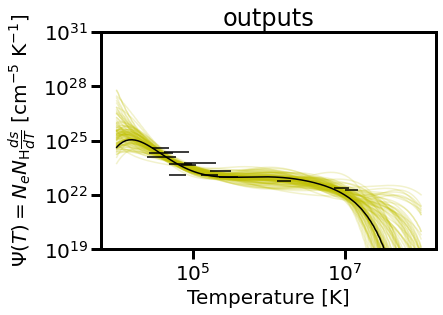

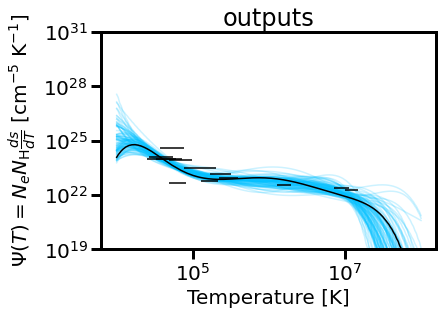

In [423]:
_, fitsf = plot_dem(samples=outf[1], lnprob=outf[0], 
                 flux_arr=outf[2], gofnt_matrix=outf[6],
                 log_temp=outf[4], temp=outf[3], 
                 flux_weighting=outf[5], 
                 main_color='k', sample_color='y', alpha=0.2,
                 sample_num=100, sample_label='samples', main_label='main', title_name='outputs')
plt.show()
_, fitsq = plot_dem(samples=outq[1], lnprob=outq[0], 
                 flux_arr=outq[2], gofnt_matrix=outq[6],
                 log_temp=outq[4], temp=outq[3], 
                 flux_weighting=outq[5], 
                 main_color='k', sample_color='deepskyblue', alpha=0.2,
                 sample_num=100, sample_label='samples', main_label='main', title_name='outputs')
plt.show()

# Paper Figure

/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_full/
H2
H2
H2
SiI
SiI
/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_short/
SV 1204.31082623514


/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_38242/3785366269.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Desktop/dem_comp.png', dpi=300,


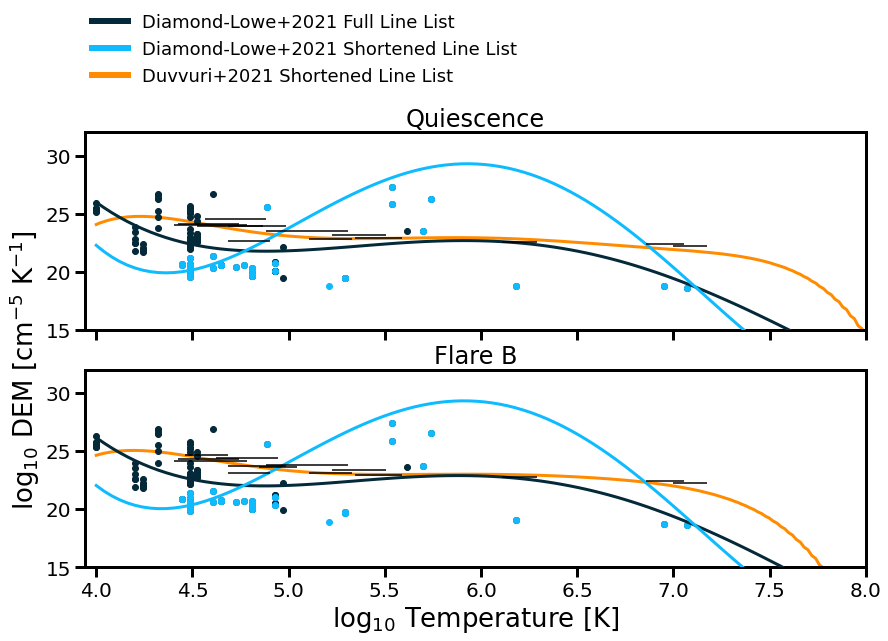

In [430]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,8), sharex=True, sharey=True)
fig.set_facecolor('w')

plot_paper_dem('/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_full/', ax1, ax2,
         c='#042938', label='Diamond-Lowe+2021 Full Line List')
plot_paper_dem('/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_short/', ax1, ax2,
         c='#0ebbff', label='Diamond-Lowe+2021 Shortened Line List')

ax1.plot(np.log10(fitsq[0]), np.log10(fitsq[1]), color='darkorange', lw=3,
         label='Duvvuri+2021 Shortened Line List')
ax1.hlines(np.log10(fitsq[-3]), np.log10(fitsq[-2]), 
           np.log10(fitsq[-1]), zorder=100, color='k')

ax2.plot(np.log10(fitsf[0]), np.log10(fitsf[1]), color='darkorange', lw=3)
ax2.hlines(np.log10(fitsf[-3]), np.log10(fitsf[-2]), 
           np.log10(fitsf[-1]), zorder=100, color='k')

ax1.set_title('Quiescence')
ax2.set_title('Flare B')
ax2.set_xlabel('log$_{10}$ Temperature [K]', fontsize=26)
ax2.set_ylabel('log$_{10}$ DEM [cm$^{-5}$ K$^{-1}$]',y=1, fontsize=26)
lgd = ax1.legend(bbox_to_anchor=(0, 1.2, 1., .05), loc=3, frameon=False,
                 ncol=1,  borderaxespad=0., fontsize=18, mode='expand')
for handle in lgd.legendHandles:
    handle.set_linewidth(6)
plt.ylim(15,32)
plt.xlim(3.94,8)

plt.savefig('/Users/arcticfox/Desktop/dem_comp.png', dpi=300,
            rasterize=True, bbox_inches='tight')

# Plot spectra

In [369]:
def get_euv(path):
    
    quies = pd.read_pickle(os.path.join(path, r'aumic_q_dem_models.pkl'))
    flare = pd.read_pickle(os.path.join(path, r'aumic_f_dem_models.pkl'))
    
    wave_q, euv_q = np.array([]), np.array([])
    wave_f, euv_f = np.array([]), np.array([])

    for k in flare['EUV']['DEMUV']['ions'].keys():
        wave_q = np.append(wave_q, quies['EUV']['DEMUV']['ions'][k]['centers'])
        euv_q = np.append(euv_q,
                          np.array(quies['EUV']['DEMUV']['ions'][k]['log10SFline']))

        wave_f = np.append(wave_f, flare['EUV']['DEMUV']['ions'][k]['centers'])
        euv_f = np.append(euv_f,
                          np.array(flare['EUV']['DEMUV']['ions'][k]['log10SFline']))
        
    argsq = np.argsort(wave_q)
    argsf = np.argsort(wave_f)

    wave_q, euv_q = wave_q[argsq], euv_q[argsq]
    wave_f, euv_f = wave_f[argsf], euv_f[argsf]
    
    euv_q = 10**(euv_q)/surface_scaling
    euv_f = 10**(euv_f)/surface_scaling
    
    qq = euv_q>0
    qf = euv_f>0

    return wave_q[qq], euv_q[qq], wave_f[qf], euv_f[qf]

In [386]:
def get_euv_duvvuri(path):
    flare_f = fits.open(os.path.join(path, 'flare/spectrum_au_mic_f_p17.fits'))
    flare_q = fits.open(os.path.join(path, 'quiescent/spectrum_au_mic_q_p17.fits'))
    
    return (flare_q[1].data['Wavelength'], flare_q[1].data['Flux_density'], 
            flare_f[1].data['Wavelength'], flare_f[1].data['Flux_density'])
    
    #return quies_w, quies_f, flare_w, flare_f
    #return flare_w, flare_f

In [387]:
wql, fql, wfl, ffl = get_euv('/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_full/')
wqs, fqs, wfs, ffs = get_euv('/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_short/')
wqd, fqd, wfd, ffd = get_euv_duvvuri('/Users/arcticfox/Documents/AUMic/final_dem_fits/gd/')

(1100.0, 1300.0)

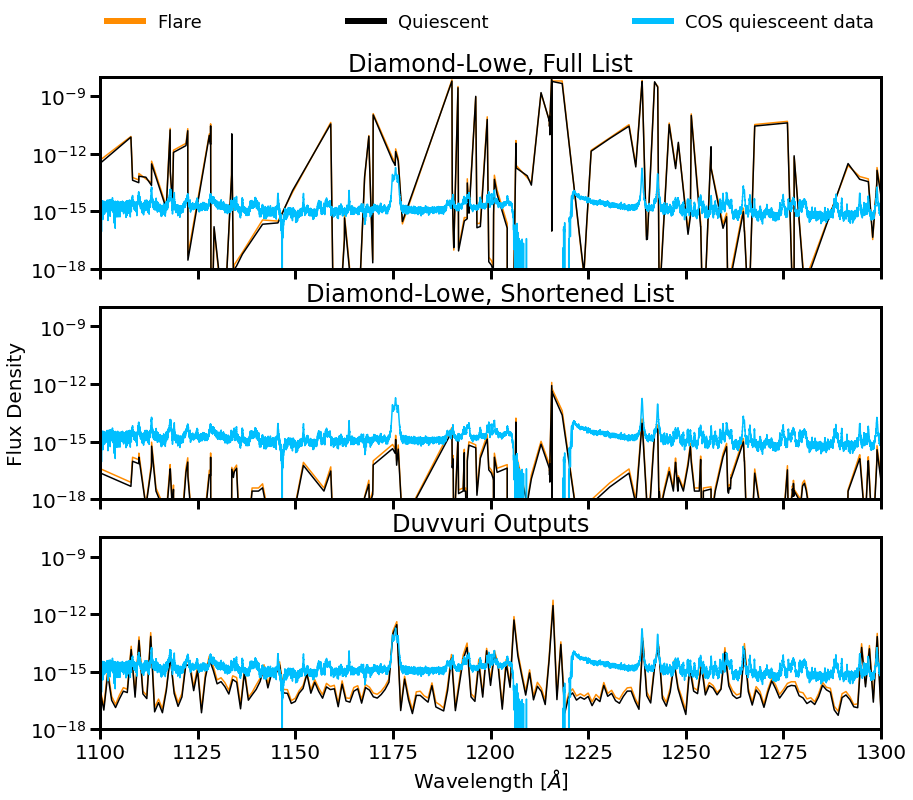

In [433]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharey=True, sharex=True,
                                  figsize=(14,12))
fig.set_facecolor('w')

ax1.plot(wfs, ffs, 'darkorange', label='Flare')
ax1.plot(wqs, fqs, 'k', label='Quiescent')
ax1.set_title('Diamond-Lowe, Full List')
ax1.plot(fwc.wavelength[0], mean_quiescent, color='deepskyblue', label='COS quiesceent data')

lgd = ax1.legend(bbox_to_anchor=(0, 1.2, 1., .05), loc=3, frameon=False,
                 ncol=3,  borderaxespad=0., fontsize=18, mode='expand')
for handle in lgd.legendHandles:
    handle.set_linewidth(6)

ax2.plot(wfl, ffl, 'darkorange', label='long')
q = wql>0
ax2.plot(wql[q], fql[q], 'k', label='short')
ax2.set_title('Diamond-Lowe, Shortened List')
ax2.plot(fwc.wavelength[0], mean_quiescent, color='deepskyblue')

ax3.plot(wfd, ffd, 'darkorange')
q = wqd > 0
ax3.plot(wqd[q], fqd[q], 'k')
ax3.set_title('Duvvuri Outputs')
ax3.plot(fwc.wavelength[0], mean_quiescent, color='deepskyblue')

ax2.set_ylabel('Flux Density')
ax3.set_xlabel('Wavelength [$\AA$]')

#plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-18,10**-8)
plt.xlim(1100,1300)

#plt.savefig('/Users/arcticfox/Desktop/spectra_comp.png', dpi=300,
#            rasterize=True, bbox_inches='tight')

- bin up the flux from both models with the shortened line list
- see how well they both match up with the data
- should reproduce certain x-ray line fluxes and FUV lines
- copy Hannah's paper for COS observations section
    - Wilson's phase 2

# Comparing to specific line fluxes

In [858]:
xray_lines = np.array([12.12, 13.7, 14.21, 14.99, 16.01, 16.76,
                       17.07, 18.96, 21.59, 21.8, 22.09, 24.77, 33.72])

In [669]:
dpath = '/Users/arcticfox/Documents/GitHub/cos_flares/data/'
xmm_wavelength, xmm_spectra, xm_err = np.load(os.path.join(dpath, 'xmm_spec.npy'),
                                              allow_pickle=True)
xmm_spectra *= 1e-10

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_38242/726738441.py:4: RuntimeWarning: invalid value encountered in multiply
  xmm_spectra *= 1e-10


In [903]:
uv_lines = np.array([1163.85, 118.06, 1136.49, 1152.88, 1175.59, 1238.82, 1242.8,
                     1296.16, 1298.96, 1318.98, 1326.65, 1329.1, 1335.0, 1251.71])
uv_binsize = np.array([0.5, 1, 2, 0.5, 1, 1.5, 1.5, 0.3, 0.8, 0.5, 0.5, 1, 2, 0.8])

# Final Paper Plot

In [904]:
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from dem_plotting import plot_hdl_dem, plot_binned_spectrum, compare_with_data

SV 1204.31082623514


/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_plotting.py:160: RuntimeWarning: divide by zero encountered in log10
/Users/arcticfox/Documents/GitHub/cos_flares/src/dem_plotting.py:159: RuntimeWarning: divide by zero encountered in log10
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_38242/350091944.py:103: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Documents/AUMic/paper/dem_comp.pdf', dpi=300,


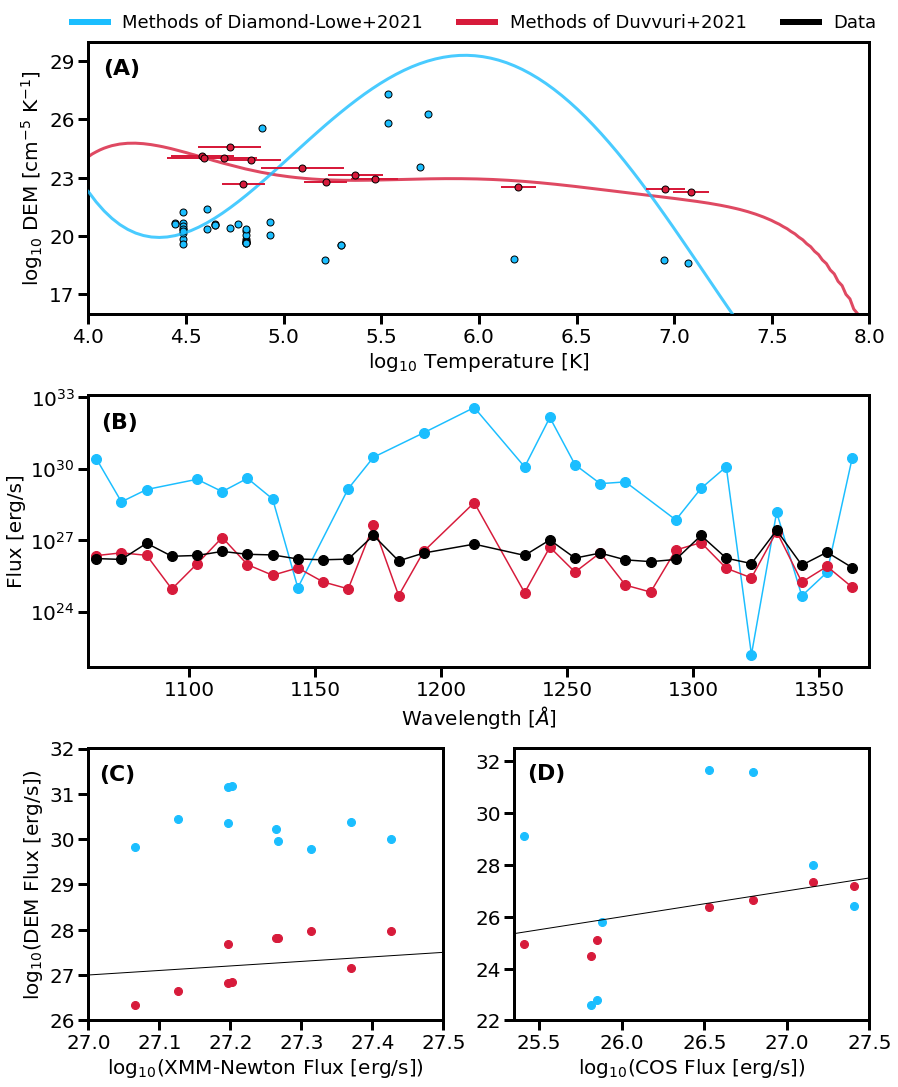

In [945]:
fig = plt.figure(figsize=(14,18))
gs = GridSpec(nrows=3, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

fig.set_facecolor('w')

dc = '#d71b3b'
hdlc = '#1bbeff'

####################################################
######## FIRST PLOT : DEM MODEL COMPARISON ########
####################################################
plot_hdl_dem('/Users/arcticfox/Documents/AUMic/final_dem_fits/hdl_short/', ax1, ax2=None,
         c=hdlc, label='Methods of Diamond-Lowe+2021', alpha=0.8)

ax1.plot(np.log10(fitsq[0]), np.log10(fitsq[1]), color=dc, lw=3,
         label='Methods of Duvvuri+2021', alpha=0.8)

ax1.hlines(np.log10(fitsq[-3]), np.log10(fitsq[-2]), 
           np.log10(fitsq[-1]), zorder=100, color=dc, lw=2)

ax1.errorbar((np.log10(fitsq[-2])+np.log10(fitsq[-1]))/2, np.log10(fitsq[-3]),
              fmt='o', zorder=100, color=dc, 
              markeredgecolor='k', ms=7)

ax1.plot(np.arange(3,4,2), np.arange(100,101,2), 'k', lw=3, label='Data')

lgd = ax1.legend(bbox_to_anchor=(-0.03, 1.01, 0., .05), 
                 loc=3, frameon=False,
                 ncol=3,  borderaxespad=0., fontsize=18)
for handle in lgd.legendHandles:
    handle.set_linewidth(6)
    handle.set_alpha(1)
    
ax1.set_xlabel('log$_{10}$ Temperature [K]', fontsize=20)
ax1.set_ylabel('log$_{10}$ DEM [cm$^{-5}$ K$^{-1}$]', fontsize=20)
ax1.set_ylim(16,30)
ax1.set_yticks(np.arange(17,31,3))
ax1.set_xlim(4,8)
ax1.text(s='(A)', x=4.075, y=28.3, fontweight='bold', fontsize=22)

####################################################
########### SECOND PLOT : BINNED SPECTRA ###########
####################################################
bins = np.arange(fwc.wavelength[0][0], fwc.wavelength[0][-1], 10)
bad = np.where((bins>1205) & (bins<1222))[0]
bins = np.delete(bins, bad)
plot_binned_spectrum(wqs, fqs, distance.value, ax=ax2, bins=bins,
                     c=hdlc)
plot_binned_spectrum(wqd, fqd, distance.value, ax=ax2, bins=bins,
                     c=dc)
plot_binned_spectrum(fwc.wavelength[0], mean_quiescent, 
                     distance.value, ax=ax2, bins=bins,
                     c='k')
ax2.set_yscale('log')
ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('Flux [erg/s]')
ax2.set_xlim(1060,1370)
ax2.text(s='(B)', x=1065, y=5*10**31, fontweight='bold', fontsize=22)

####################################################
######### THIRD & FOURTH PLOTS : LINE COMP #########
####################################################

compare_with_data(wqd, fqd, xmm_wavelength, xmm_spectra, xray_lines,
                  distance=distance.value,
                  ax=ax3, c=dc)#, binsize=uv_binsize)
compare_with_data(wqs, fqs, xmm_wavelength, xmm_spectra, xray_lines,
                  distance=distance.value,
                  ax=ax3, c=hdlc)#, binsize=uv_binsize)

ax3.plot(np.arange(0,40,1), np.arange(0,40,1), 'k', lw=1)
ax3.text(s='(C)', x=27.015, y=31.3, fontweight='bold', fontsize=22)
ax3.set_xlim(27, 27.5)
ax3.set_ylim(26,32)
ax3.set_xlabel('log$_{10}$(XMM-Newton Flux [erg/s])')
ax3.set_ylabel('log$_{10}$(DEM Flux [erg/s])')

####################################################

compare_with_data(wqd, fqd, fwc.wavelength[0], mean_quiescent, uv_lines,
                  distance=distance.value,
                  ax=ax4, c=dc, binsize=uv_binsize)
compare_with_data(wqs, fqs, fwc.wavelength[0], mean_quiescent, uv_lines,
                  distance=distance.value,
                  ax=ax4, c=hdlc, binsize=uv_binsize)
ax4.plot(np.arange(0,40,1), np.arange(0,40,1), 'k', lw=1)
ax4.set_xlabel('log$_{10}$(COS Flux [erg/s])')
ax4.text(s='(D)', x=25.43, y=31.3, fontweight='bold', fontsize=22)
ax4.set_xlim(25.35, 27.5)
ax4.set_ylim(22,32.5)


for ax in [ax1,ax2,ax3,ax4]:
    ax.set_rasterized(True)


plt.subplots_adjust(hspace=0.3)
plt.savefig('/Users/arcticfox/Documents/AUMic/paper/dem_comp.pdf', dpi=300,
            rasterize=True, bbox_inches='tight')